In [1]:
import os
import time

from joblib import dump, load

import matplotlib.pyplot as plt
from IPython import display

from imageio import imread
import numpy as np 
import scipy

import theano.tensor as T
import lasagne.layers
from lasagne.nonlinearities import elu
import theano

from tqdm import tqdm_notebook

from nn_utils import build_UNet, iterate_minibatches
from train_data_preparation import prepare_data, extract_random_patches, extract_grid_patches
from sklearn.metrics import average_precision_score

In [2]:
run processing_functions.ipynb

In [3]:
patch_size = 64
base_n_filters = 32
nonlinearity = elu
batch_size = 128

In [13]:
carb_stacks = ['carb71', 'carb96558', 'carbRNF', 'SPE_carb10_58_box3']
soil_stacks = ['SoilAh-1', 'SoilB-2', 'TeTree_subset1', 'TiTree_subset2']
urna_stacks = ['Urna_22', 'Urna_30', 'Urna_34']

In [5]:
def create_predictor(weights_name):
    input_image = T.tensor4('input')
    target = T.matrix('output', dtype='int64')

    net = build_UNet(n_input_channels=1, 
                     BATCH_SIZE=None, 
                     num_output_classes=2,
                     pad='same', 
                     nonlinearity=nonlinearity,
                     input_dim=(patch_size, patch_size), 
                     base_n_filters=base_n_filters, 
                     do_dropout=True,
                     weights=load(weights_name))
    predictions = lasagne.layers.get_output(net['output_flattened'], input_image)
    get_predictions = theano.function([input_image], predictions)
    return get_predictions

In [6]:
def get_predictions(input_stack_path, output_stack_path, predictor, images_number=None):
    #input_stack = []
    output_stack = []
    results = []
    
    if images_number is None:
        images_number = len(os.listdir(input_stack_path))
        
    for i, (fgray, fbin) in enumerate(zip(sorted(os.listdir(input_stack_path)), 
                                          sorted(os.listdir(output_stack_path)))):
        input_img = imread(os.path.join(input_stack_path, fgray))
        #input_stack.append(input_img.reshape(input_img.shape + (1, )))

        output_img = imread(os.path.join(output_stack_path, fbin))
        output_stack.append(output_img.reshape(output_img.shape + (1, )))

        prediction = predict_image(input_img, predictor, patch_size, n_input_channels=1)
        prediction = prediction.reshape(prediction.shape + (1, ))
        results.append(prediction)
        if i > images_number:
            break
        if i % 100 == 0:
            print('Progress: {} of {} images'.format(i, images_number))

    #input_stack = np.concatenate(input_stack, axis=2)
    output_stack = np.concatenate(output_stack, axis=2)
    prediction = np.concatenate(results, axis=2)
    
    #return input_stack, output_stack, prediction
    return output_stack, prediction

In [7]:
def get_stacks(input_stack_path, output_stack_path):
    input_stack = []
    output_stack = []
        
    images_number = len(os.listdir(input_stack_path))
    for i, (fgray, fbin) in enumerate(zip(sorted(os.listdir(input_stack_path)), 
                                          sorted(os.listdir(output_stack_path)))):
        input_img = imread(os.path.join(input_stack_path, fgray))
        input_stack.append(input_img.reshape(input_img.shape + (1, )))

        output_img = imread(os.path.join(output_stack_path, fbin))
        output_stack.append(output_img.reshape(output_img.shape + (1, )))

        if i % 100 == 0:
            print('Progress: {} of {} images'.format(i, images_number))

    input_stack = np.concatenate(input_stack, axis=2)
    output_stack = np.concatenate(output_stack, axis=2)
    
    return input_stack, output_stack

In [8]:
def iou(prediction, target, threshold):
    rounded = np.where(prediction > threshold, 
                       np.ones_like(prediction, dtype=np.float32),
                       np.zeros_like(prediction, dtype=np.float32))
    return (rounded * target).sum() / (rounded + target - rounded * target).sum()

In [9]:
def logloss(prediction, target):
    eps = 1e-6
    prediction = np.where(np.abs(prediction) < eps, np.full(prediction.shape, eps, dtype=np.float32), prediction)
    prediction = np.where(np.abs(prediction - 1) < eps, np.full(prediction.shape, 1 - eps, dtype=np.float32), prediction)
    return -(target * np.log(prediction) + (1 - target) * np.log(1 - prediction)).mean()

In [10]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score

def accuracy(prediction, target, threshold):
    rounded = np.where(prediction > threshold, 
                       np.ones_like(prediction, dtype=np.float32),
                       np.zeros_like(prediction, dtype=np.float32))
    return (rounded == target).mean()

def precision(prediction, target, threshold):
    rounded = np.where(prediction > threshold, 
                       np.ones_like(prediction, dtype=np.float32),
                       np.zeros_like(prediction, dtype=np.float32))
    return precision_score(target.flatten(), rounded.flatten())

def recall(prediction, target, threshold):
    rounded = np.where(prediction > threshold, 
                       np.ones_like(prediction, dtype=np.float32),
                       np.zeros_like(prediction, dtype=np.float32))
    return recall_score(target.flatten(), rounded.flatten())

In [11]:
def metric_curve(prediction, output_stack, num_steps, metric):
    metrics = []
    
    left = 1 - np.logspace(-1, 0, num_steps / 2, base=2)[::-1][:-1]
    right = np.logspace(-1, 0, num_steps / 2, base=2)
    
    for x in np.concatenate([left, right]):
        metrics.append(metric(prediction, output_stack, x))
    return np.concatenate([left, right]), metrics

In [ ]:
trained_stack_names = [
    'carb96558_SoilB-2', 
    'carb96558_Urna_22', 
    'SoilB-2_Urna_22', 
    'carb96558',
    'SoilB-2',
    'Urna_22',    
#     'SoilB-2_Urna_22_carb96558'
]

predicting_stack_names = carb_stacks + soil_stacks + urna_stacks
total_results = {}

for trained_stack_name in trained_stack_names:
    weights_name = ''.join([trained_stack_name, '_weights/UNet_params_ep009.jbl'])
    weights_path = os.path.join('../output_data/weights', weights_name)
    results = {}
    
    predictor = create_predictor(weights_path)

    for predicting_stack_name in predicting_stack_names:
        cresults = {}
        input_stack_path = os.path.join('../all_data/binary_data', predicting_stack_name, 'NLM')
        output_stack_path = os.path.join('../all_data/binary_data', predicting_stack_name, 'CAC')

        output_stack, prediction = get_predictions(input_stack_path, output_stack_path, predictor, images_number=250)
        output_stack = (output_stack.astype(np.float32) / 255).astype(np.int8)

        cresults['logloss'] = logloss(prediction, output_stack)
        cresults['PR-AUC'] = average_precision_score(output_stack.flatten(), prediction.flatten())
        cresults['iou'] = metric_curve(prediction, output_stack, 30, iou)
        cresults['accuracy'] = metric_curve(prediction, output_stack, 30, accuracy)
        cresults['precision'] = metric_curve(prediction, output_stack, 30, precision)
        cresults['recall'] = metric_curve(prediction, output_stack, 30, recall)

        print('Stack: {}\n   logloss: {}\n   PR-AUC: {}\n'
              .format(predicting_stack_name, cresults['logloss'], cresults['PR-AUC']))
        results[predicting_stack_name] = cresults
        dump(results, '../output_data/' + trained_stack_name + '.jbl')
    total_results[trained_stack_name] = results
dump(total_results, 'total_results.jbl')

Progress: 0 of 250 images
Progress: 100 of 250 images
Progress: 200 of 250 images


/home/efim/.local/share/virtualenvs/course_work-fzaykAtj/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Stack: carb71
   logloss: 0.042090609669685364
   PR-AUC: 0.999890394712158

Progress: 0 of 250 images
Progress: 100 of 250 images
Progress: 200 of 250 images
Stack: carb96558
   logloss: 0.011308523826301098
   PR-AUC: 0.999984304432162

Progress: 0 of 250 images
Progress: 100 of 250 images
Progress: 200 of 250 images
Stack: carbRNF
   logloss: 0.6818713545799255
   PR-AUC: 0.9274313676549324

Progress: 0 of 250 images
Progress: 100 of 250 images
Progress: 200 of 250 images
Stack: SPE_carb10_58_box3
   logloss: 0.05900448560714722
   PR-AUC: 0.9999090863531496

Progress: 0 of 250 images
Progress: 100 of 250 images
Progress: 200 of 250 images
Stack: SoilAh-1
   logloss: 0.034155093133449554
   PR-AUC: 0.9998996057619574

Progress: 0 of 250 images
Progress: 100 of 250 images
Progress: 200 of 250 images
Stack: SoilB-2
   logloss: 0.023560691624879837
   PR-AUC: 0.9999774706655887

Progress: 0 of 250 images
Progress: 100 of 250 images
Progress: 200 of 250 images
Stack: TeTree_subset1
   l

In [38]:
def get_predictions(input_stack_path, output_stack_path, predictor, image_number=0):   
    input_img = imread(os.path.join(input_stack_path, sorted(os.listdir(input_stack_path))[image_number]))
    output_img = imread(os.path.join(output_stack_path, sorted(os.listdir(output_stack_path))[image_number]))

    prediction = predict_image(input_img, predictor, patch_size, n_input_channels=1)
#     prediction = prediction.reshape(prediction.shape)
    
    return input_img, output_img, prediction

In [86]:
def compare(source, dest, truth, out_path, threshold=0.1):    
    binary = np.where(dest > threshold, 255, 0)
    
    fig = plt.figure(figsize=(25, 15))
    
    ax1 = plt.subplot(221)
    ax1.imshow(dest, cmap='gray')
    ax1.set_title('Predicted labeling', fontsize=20)
    
    ax2 = plt.subplot(222)
    ax2.imshow(truth, cmap='gray')
    ax2.set_title('True labeling', fontsize=20)
    
    true_positive = np.logical_and(binary == 0, truth == 0)
    false_positive = np.logical_and(binary == 0, truth == 255)
    false_negative = np.logical_and(binary == 255, truth == 0)
    
    ax3 = plt.subplot(223)
#     truth = truth.reshape(truth.shape + (1, ))
#     truth = np.concatenate([truth, truth, truth], axis=2)
#     truth[pos] = np.array([255, 0, 0])
    ax3.imshow(source, cmap='gray')
    ax3.set_title('True labeling with marked difference', fontsize=20)
   
    ax4 = plt.subplot(224)
    source = source.reshape(source.shape + (1, ))
    source = np.concatenate([source, source, source], axis=2)
    source[false_negative] = np.array([0, 0, 255])
    source[false_positive] = np.array([255, 0, 0])
    source[true_positive] = np.array([0, 255, 0])
    ax4.imshow(source)
    ax4.set_title('Input image with marked difference', fontsize=20)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)
    plt.savefig(fname=out_path)
    plt.show()

In [87]:
carb_stacks = ['carb71', 'carb96558', 'carbRNF', 'SPE_carb10_58_box3']
soil_stacks = ['SoilAh-1', 'SoilB-2', 'TeTree_subset1', 'TiTree_subset2']
urna_stacks = ['Urna_22', 'Urna_30', 'Urna_34']
predicting_stack_names = carb_stacks + soil_stacks + urna_stacks

In [88]:
trained_stack_names = [
    'carb96558_SoilB-2', 
    'carb96558_Urna_22', 
    'SoilB-2_Urna_22', 
    'carb96558',
    'SoilB-2',
    'Urna_22',    
    'SoilB-2_Urna_22_carb96558'
]

In [89]:
image_number = 250
threshold = 0.1
lx = 0
rx = 100
ly = 0
ry = 100

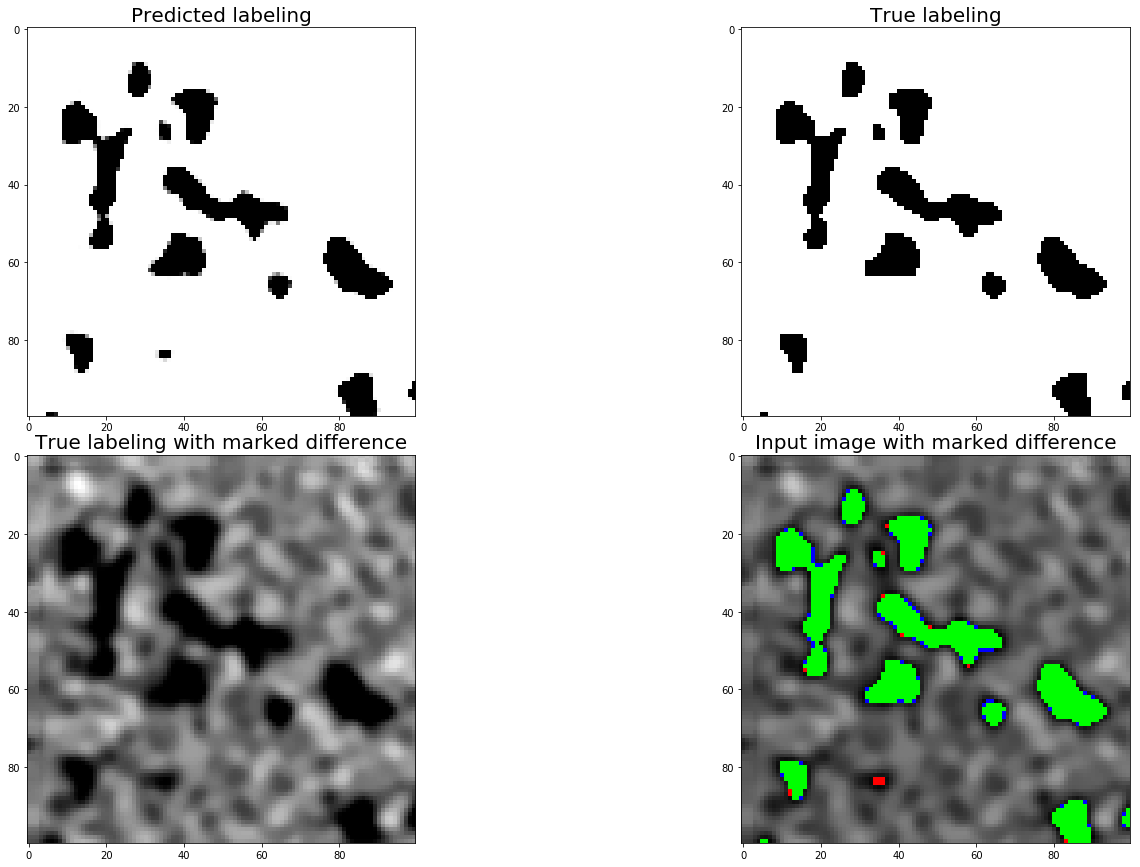

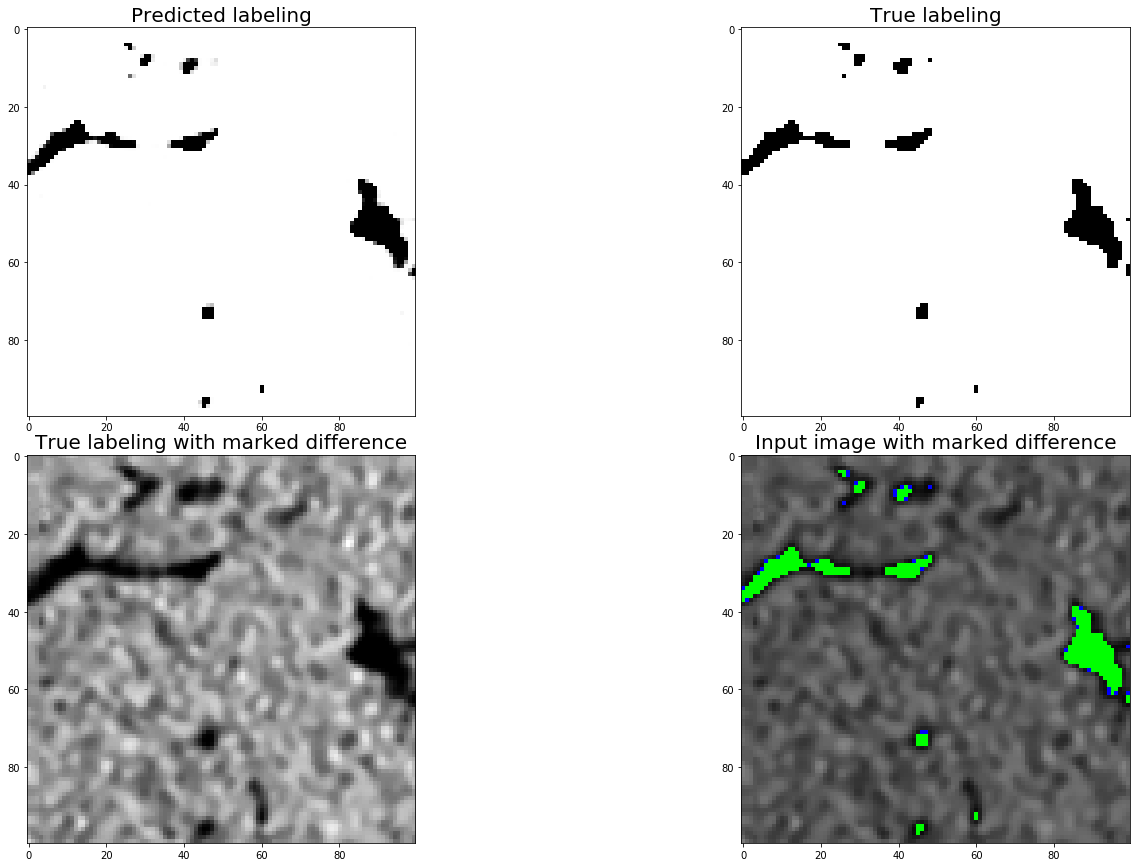

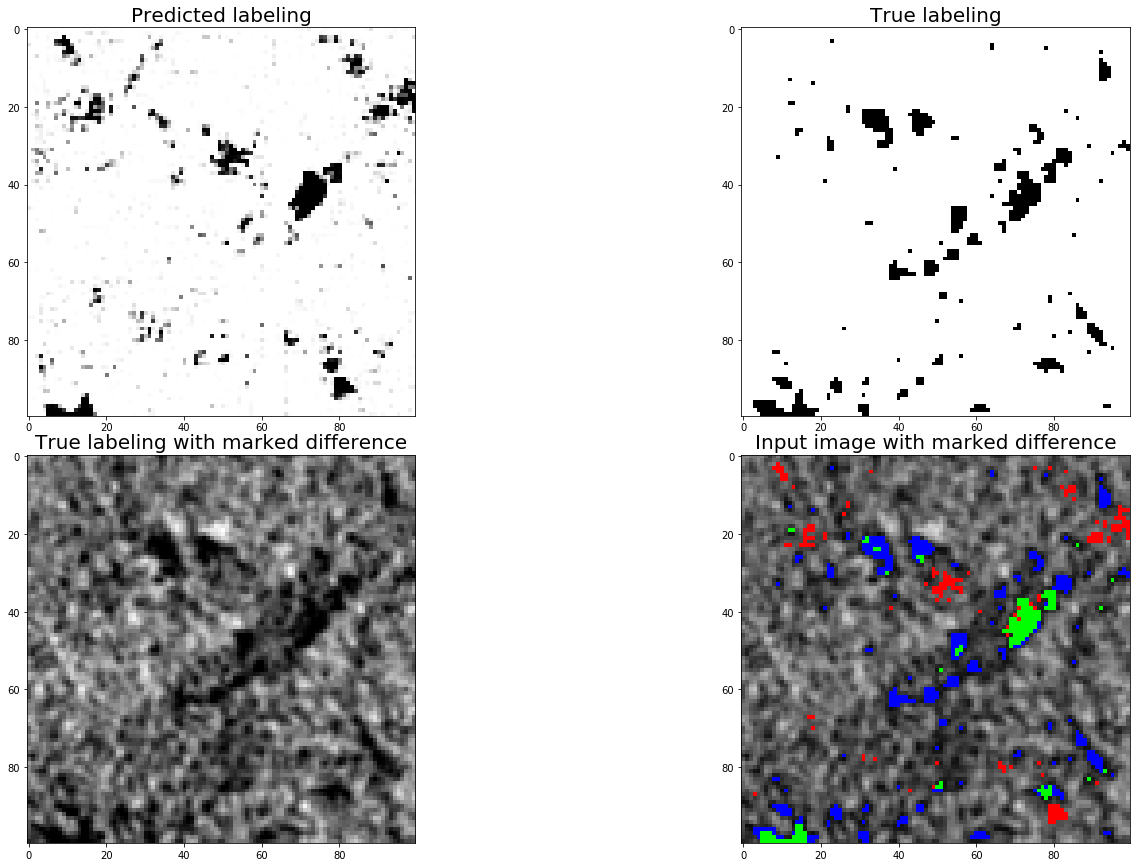

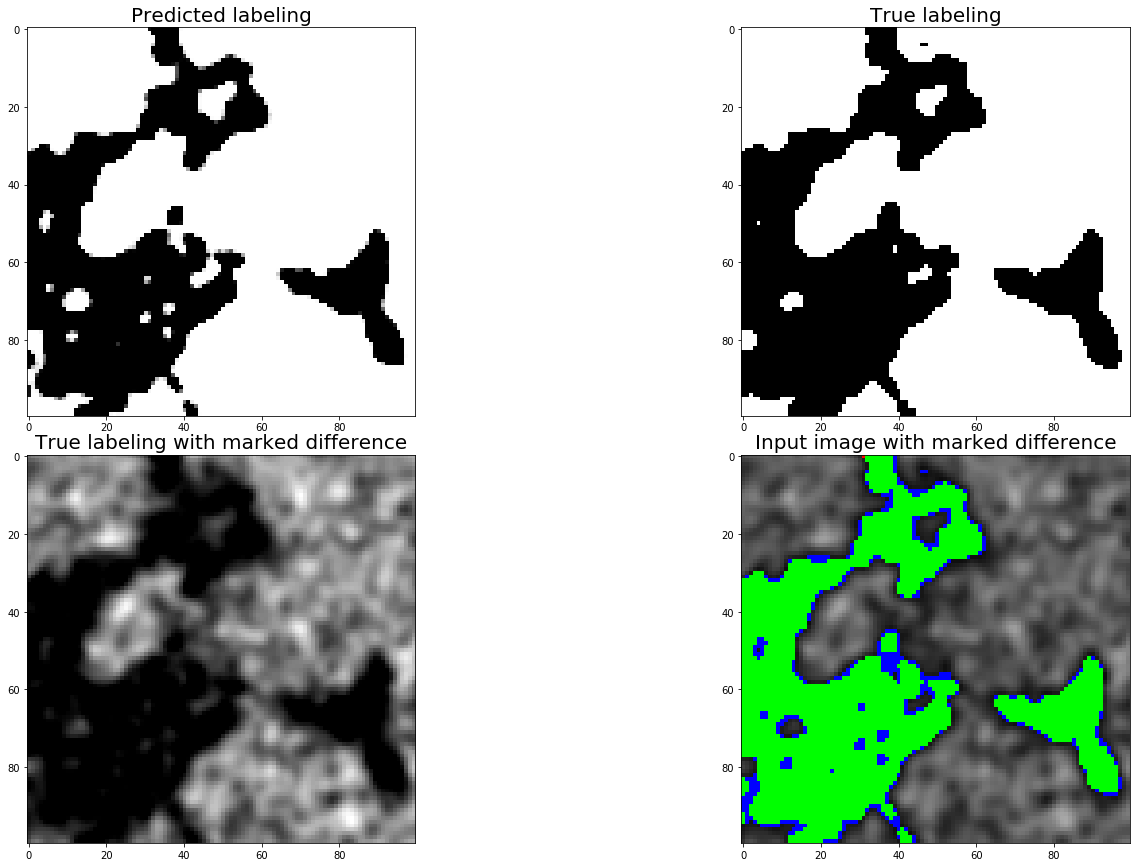

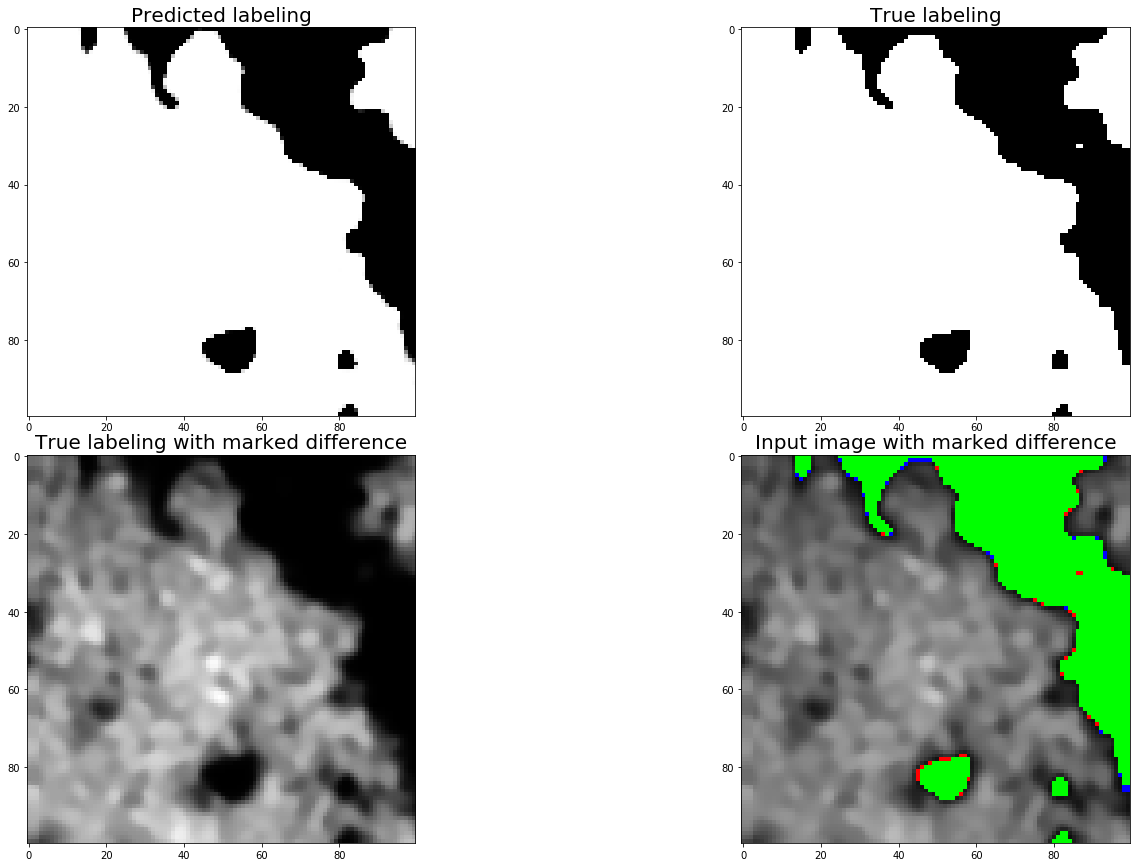

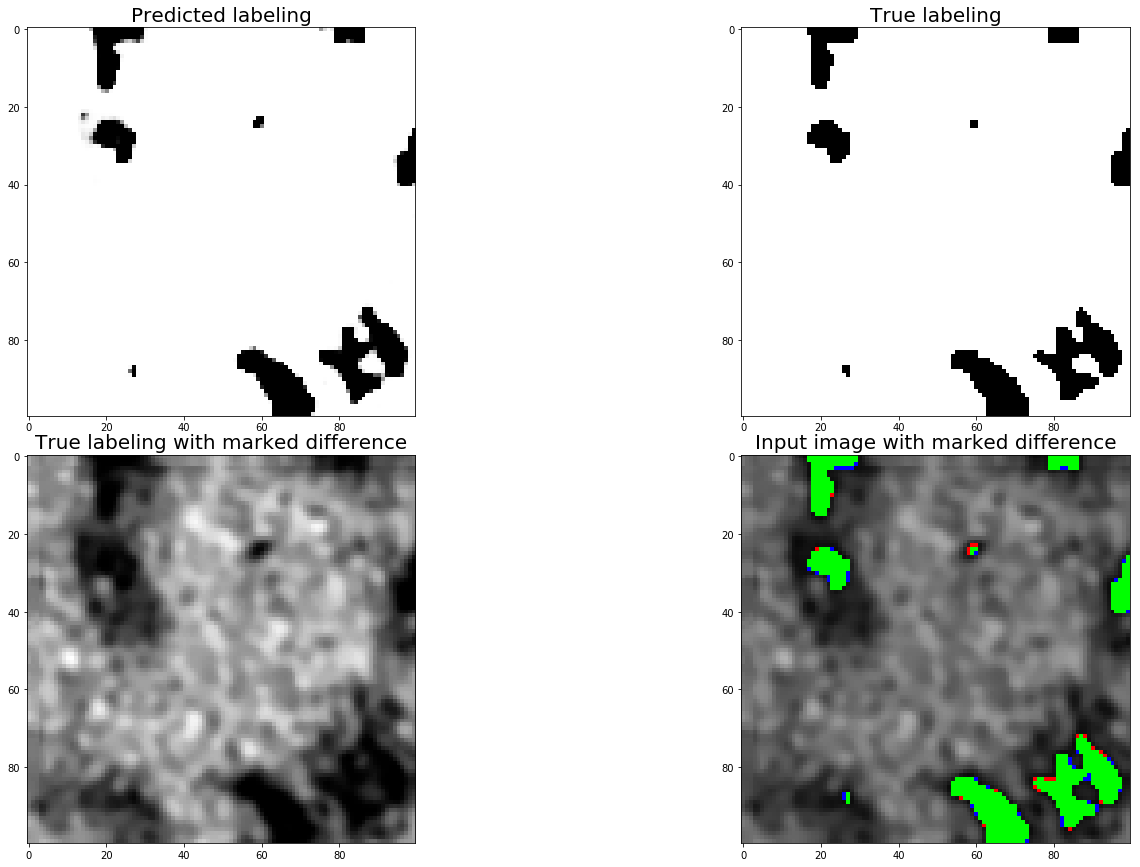

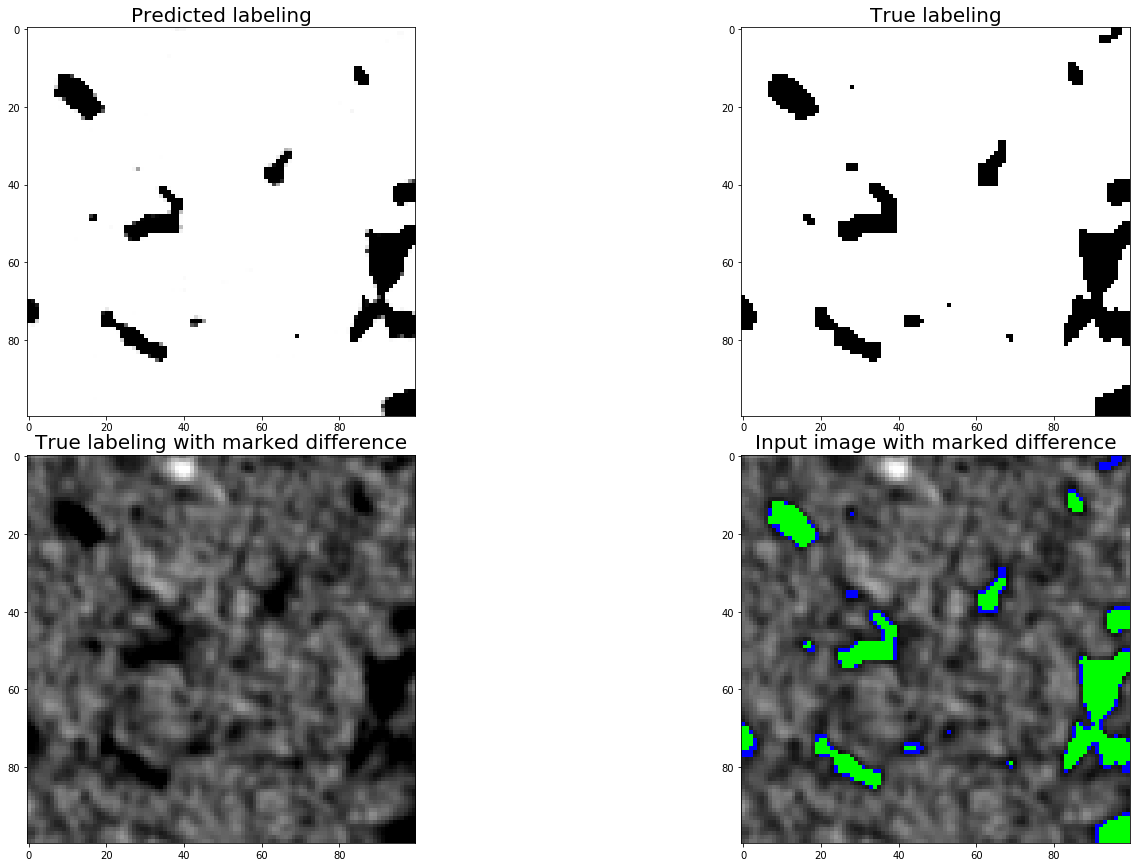

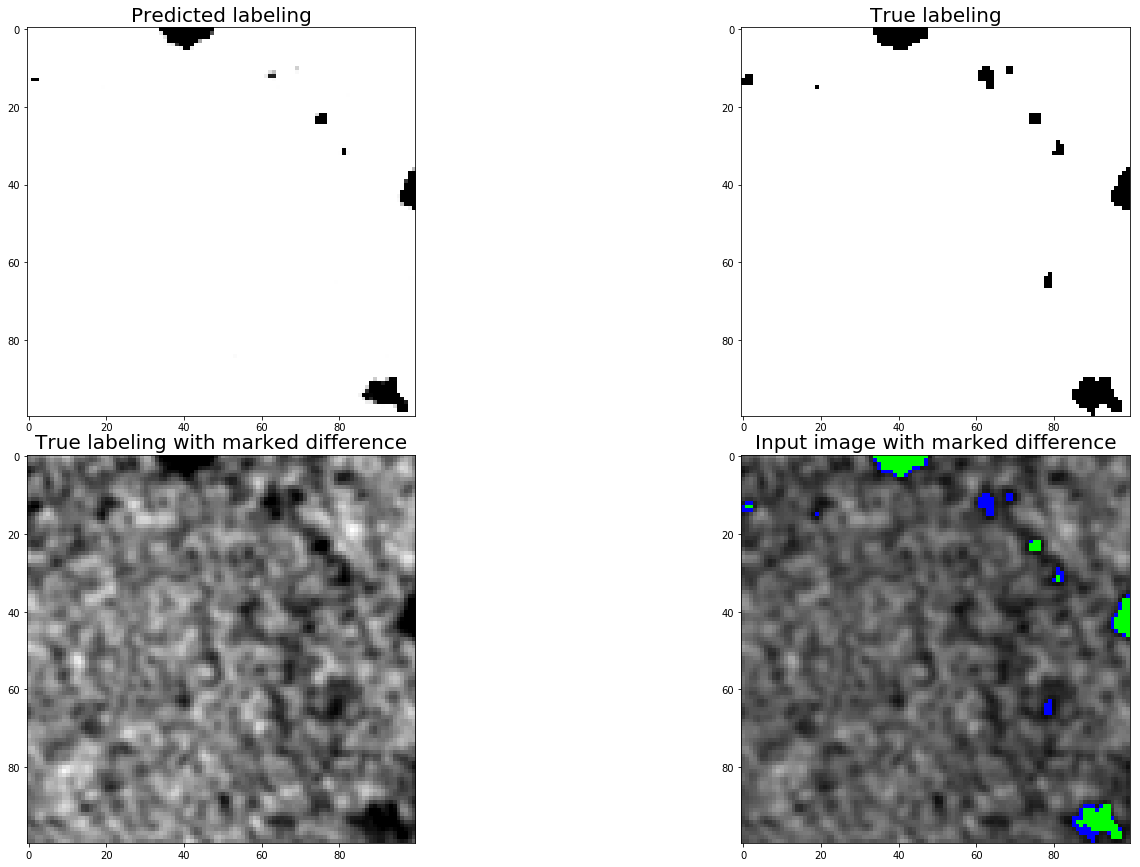

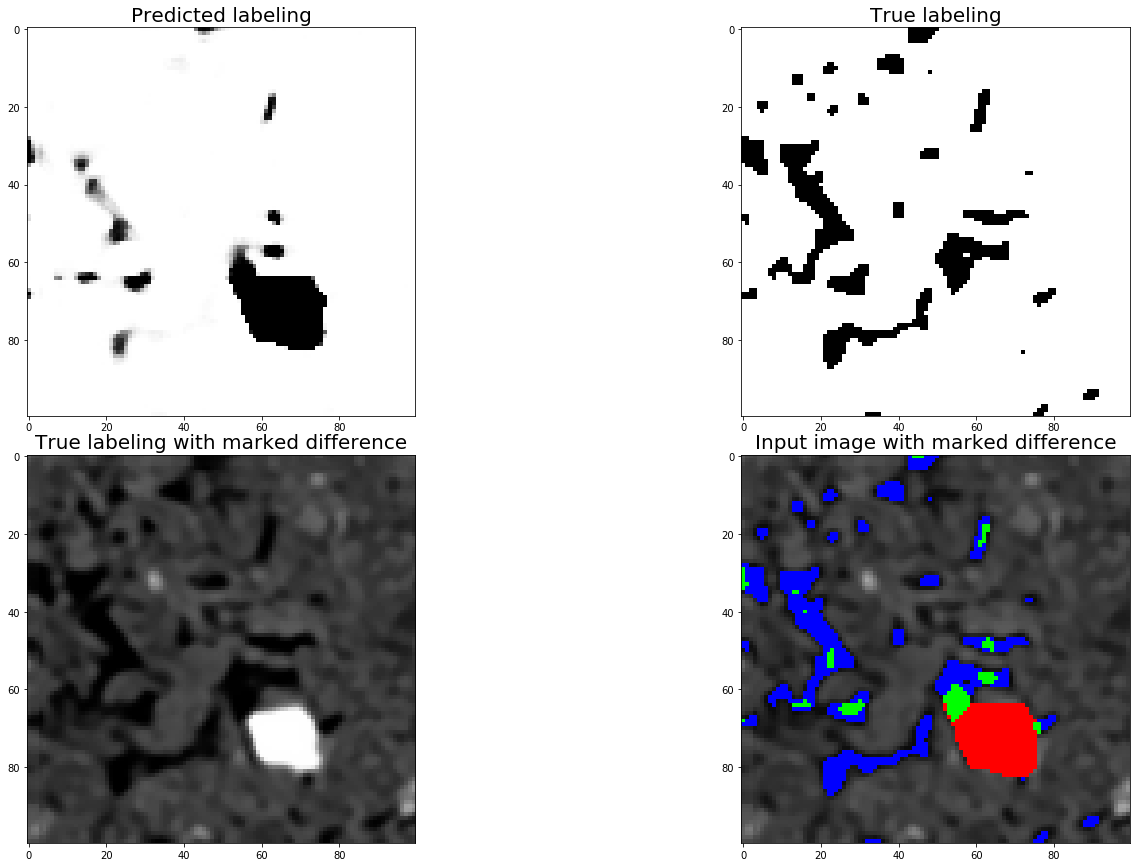

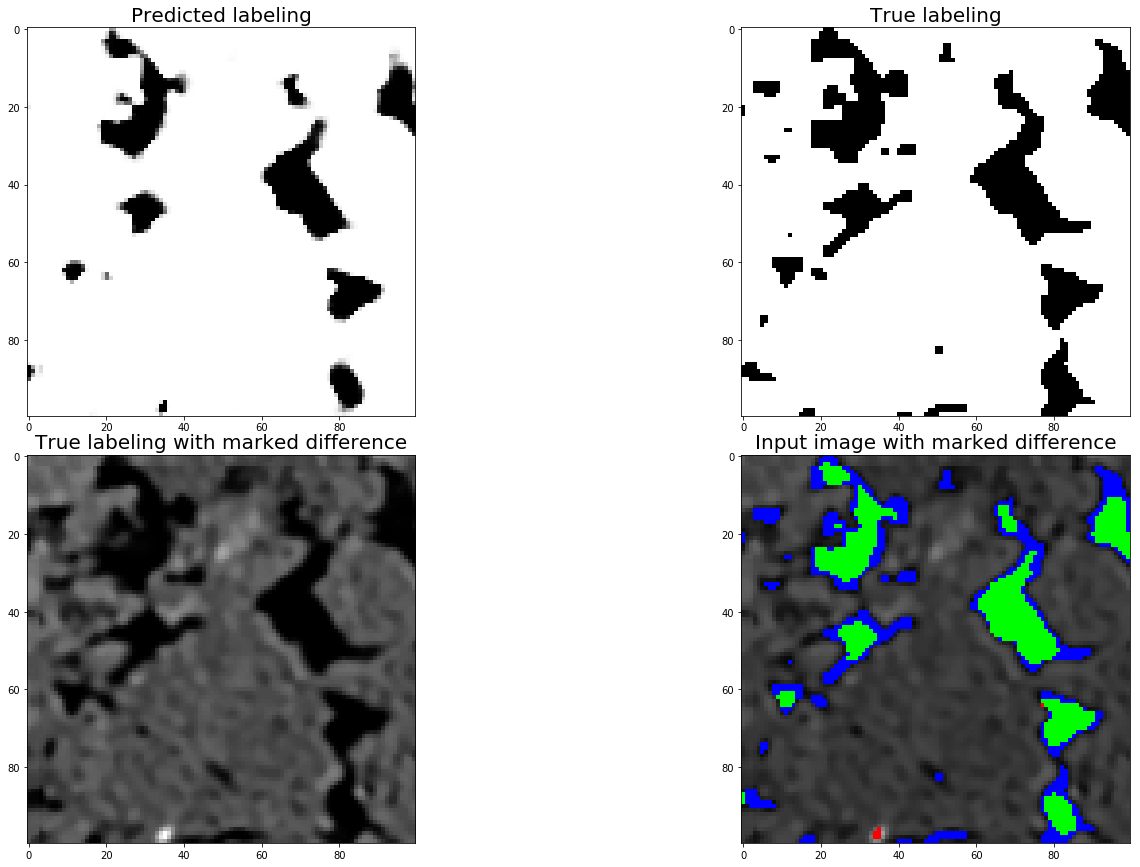

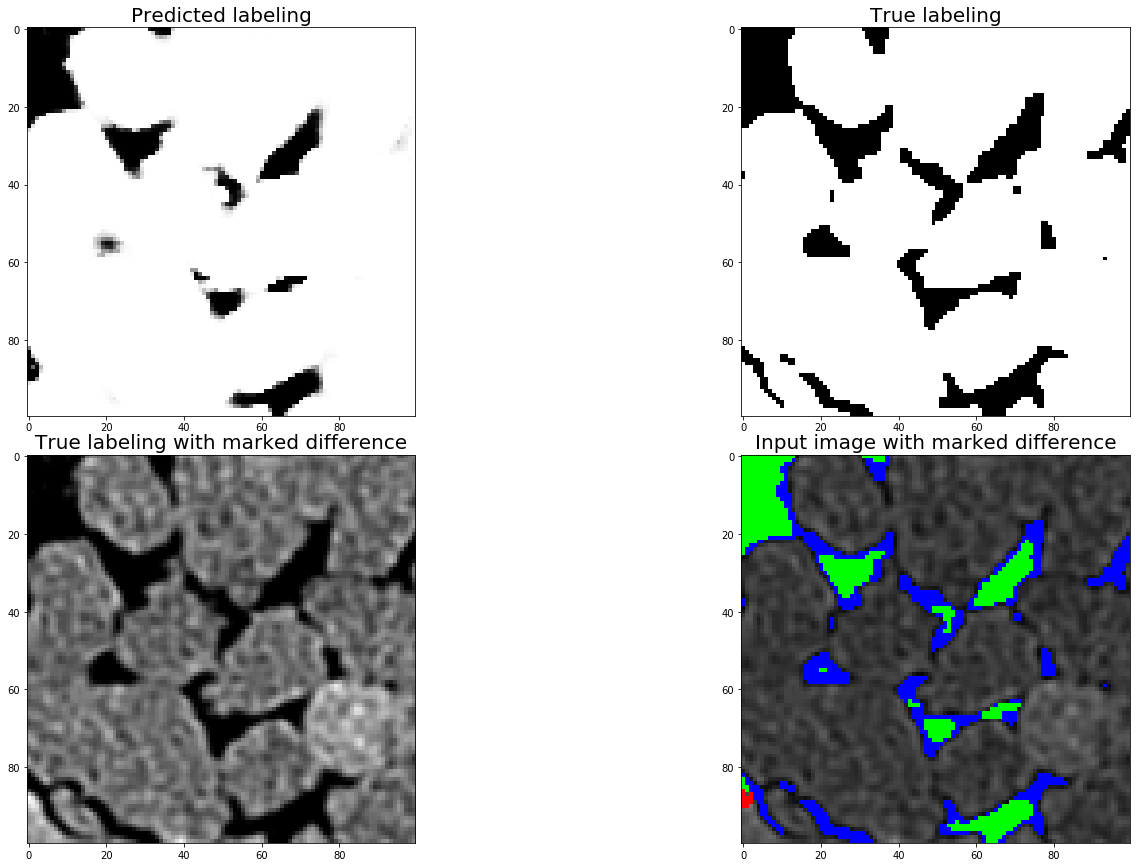

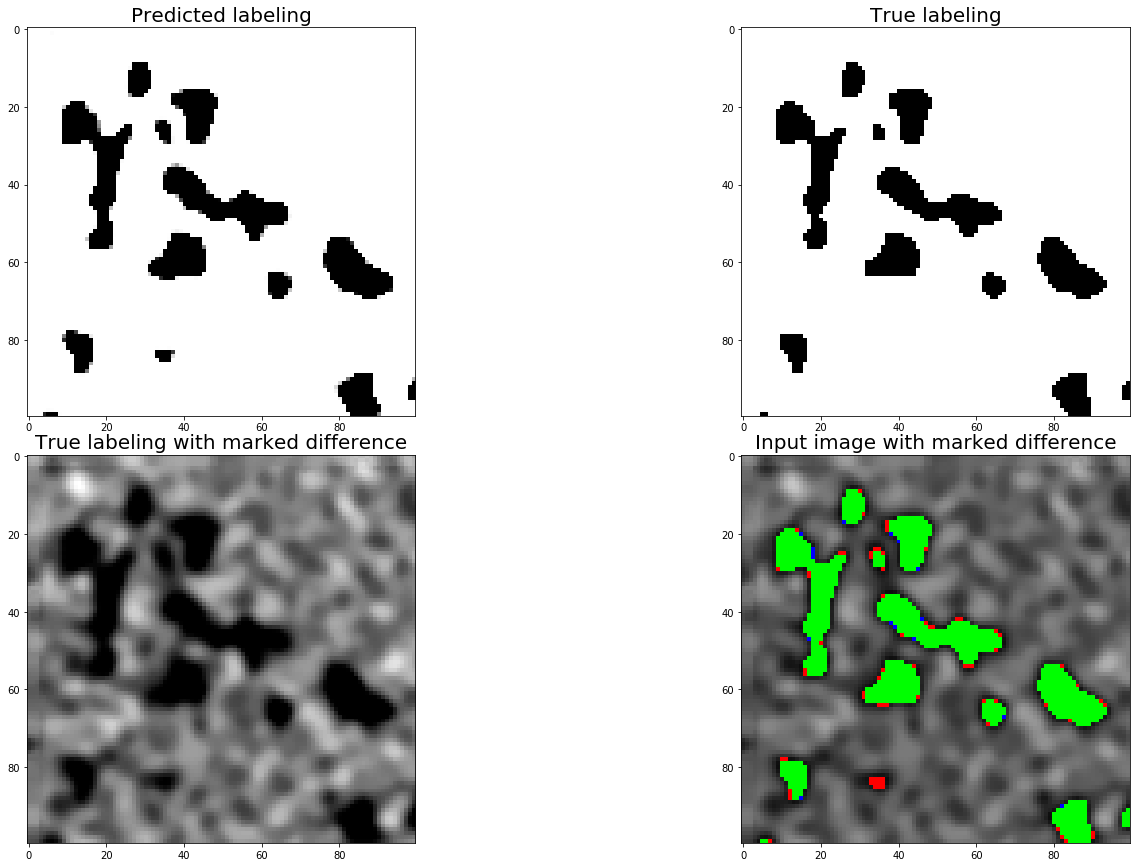

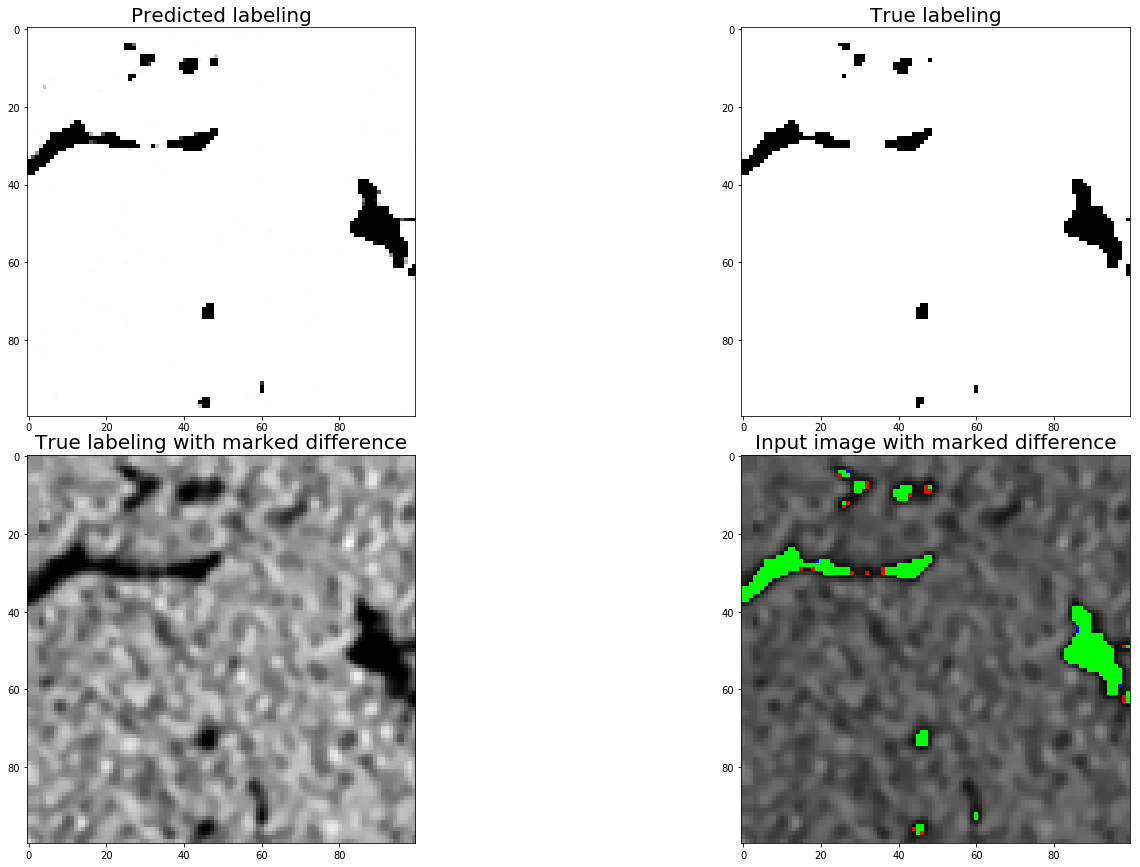

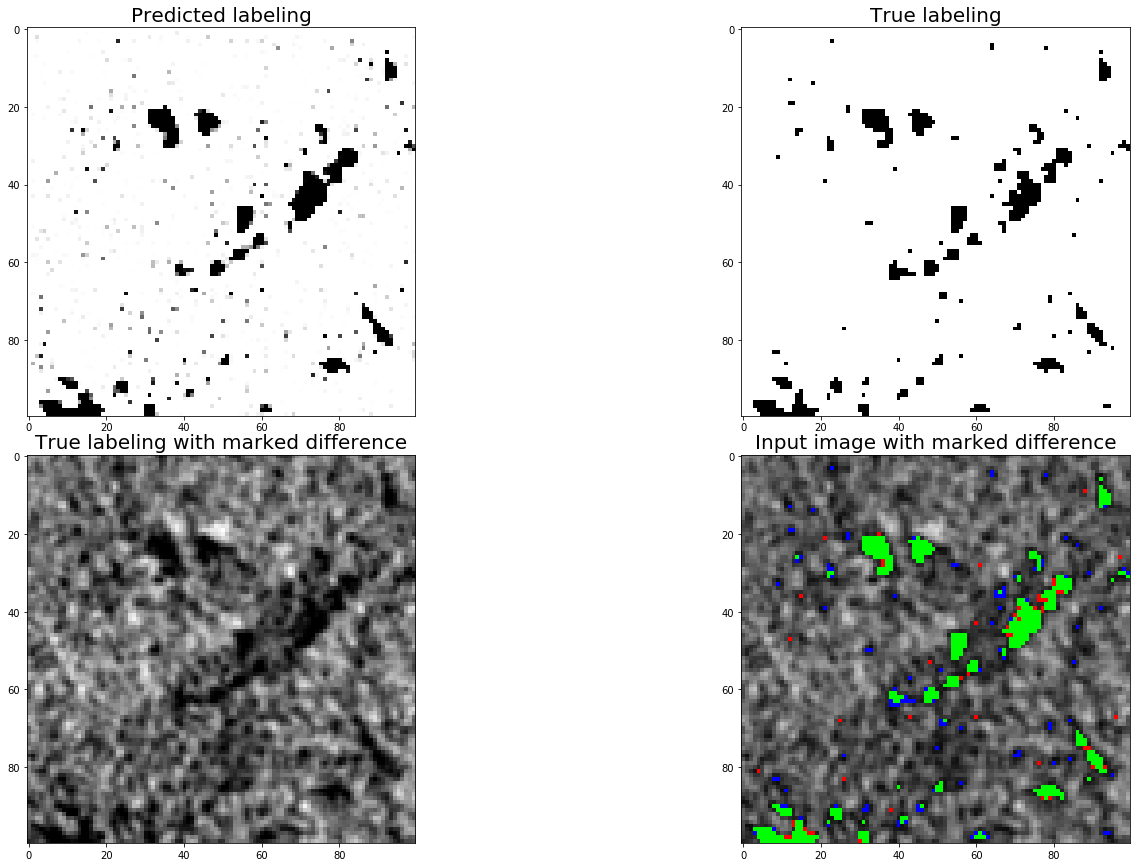

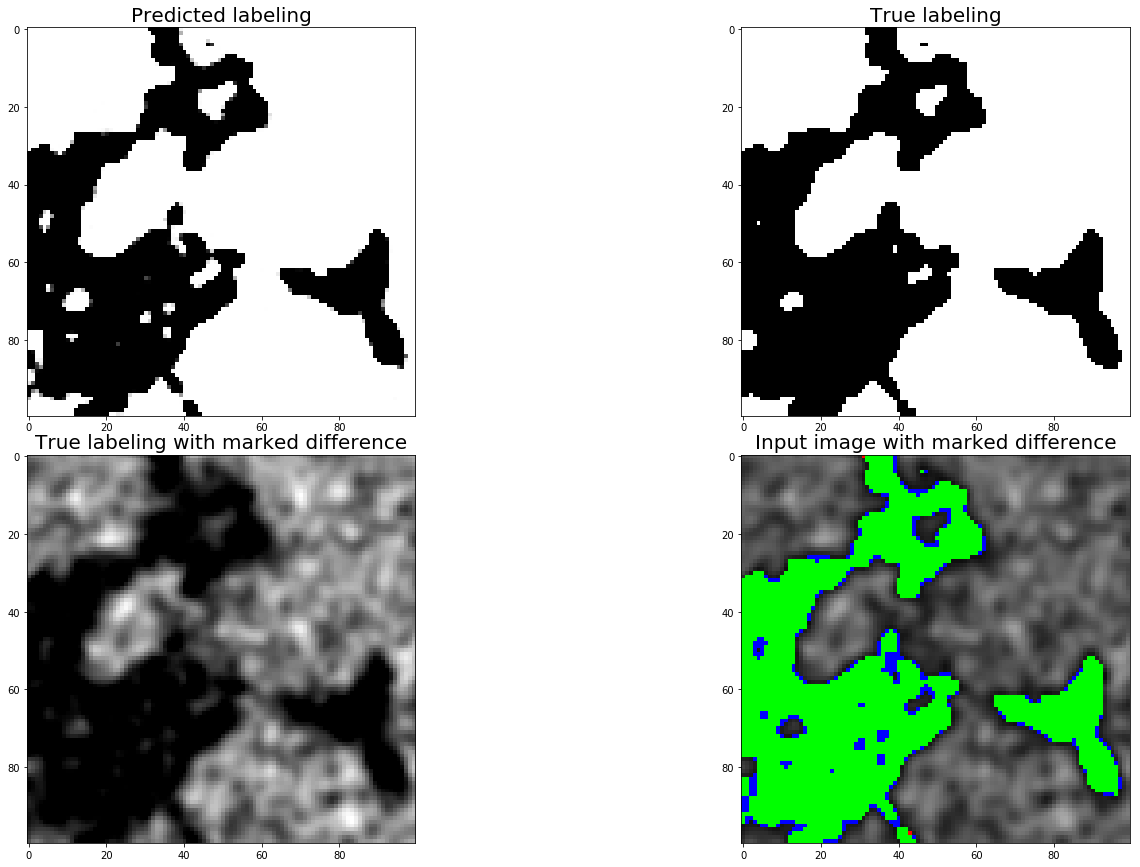

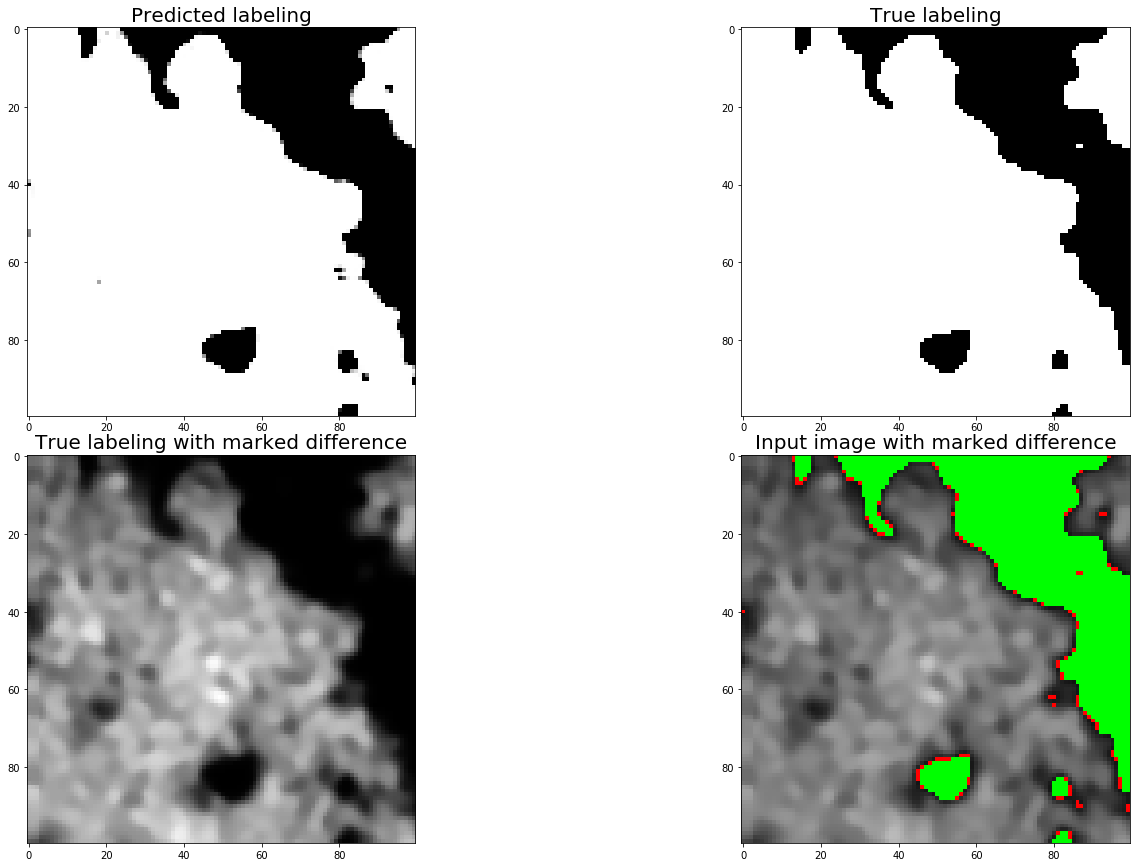

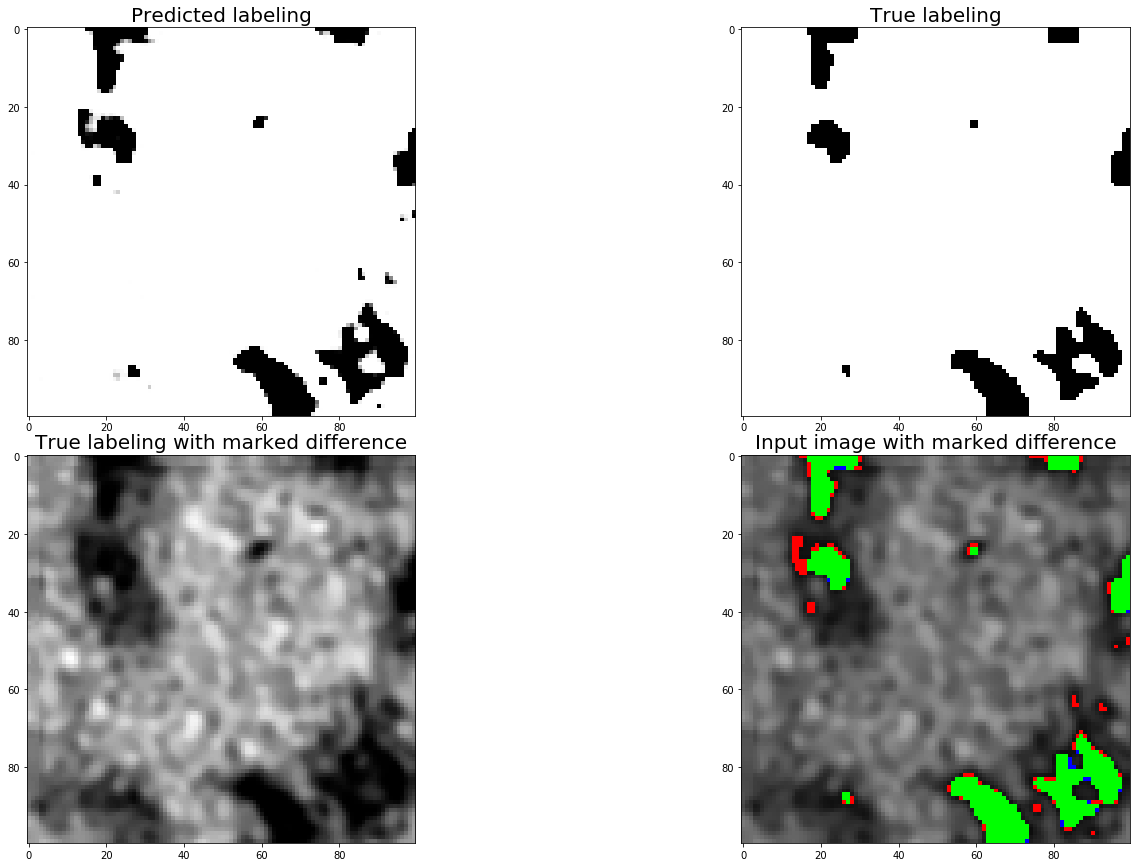

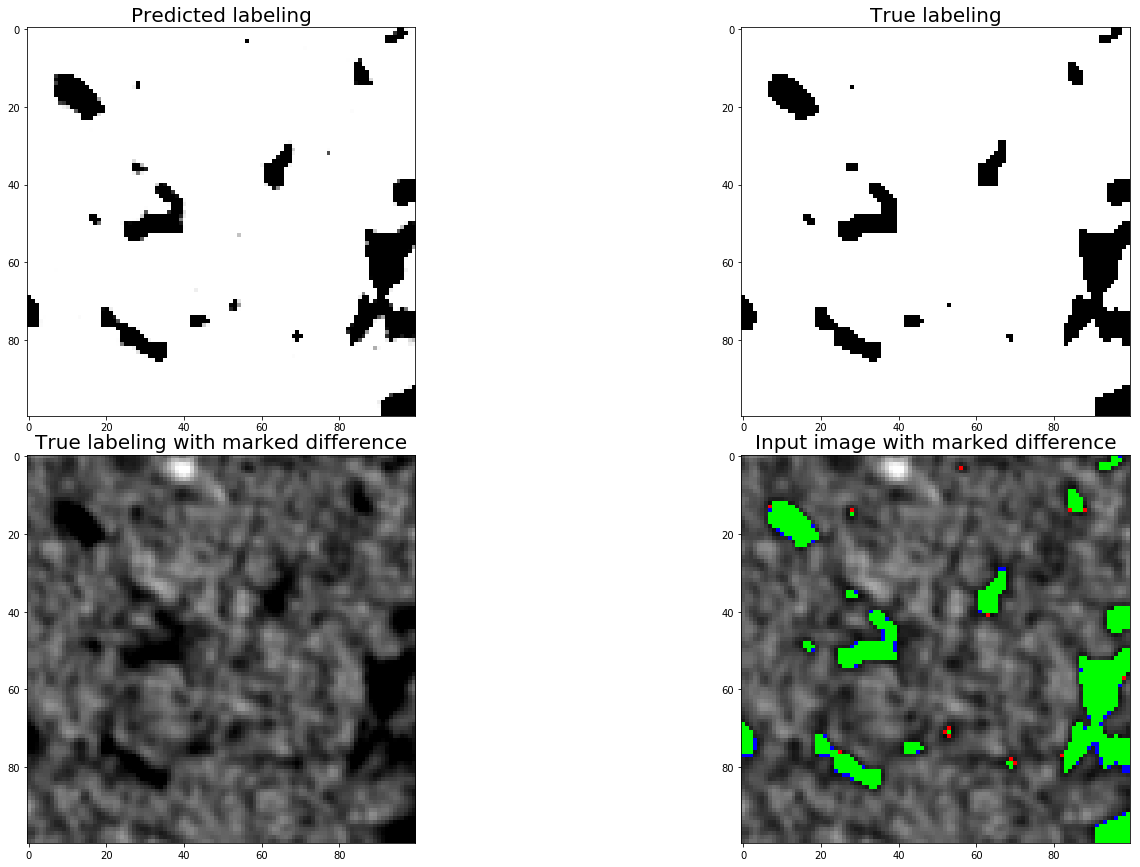

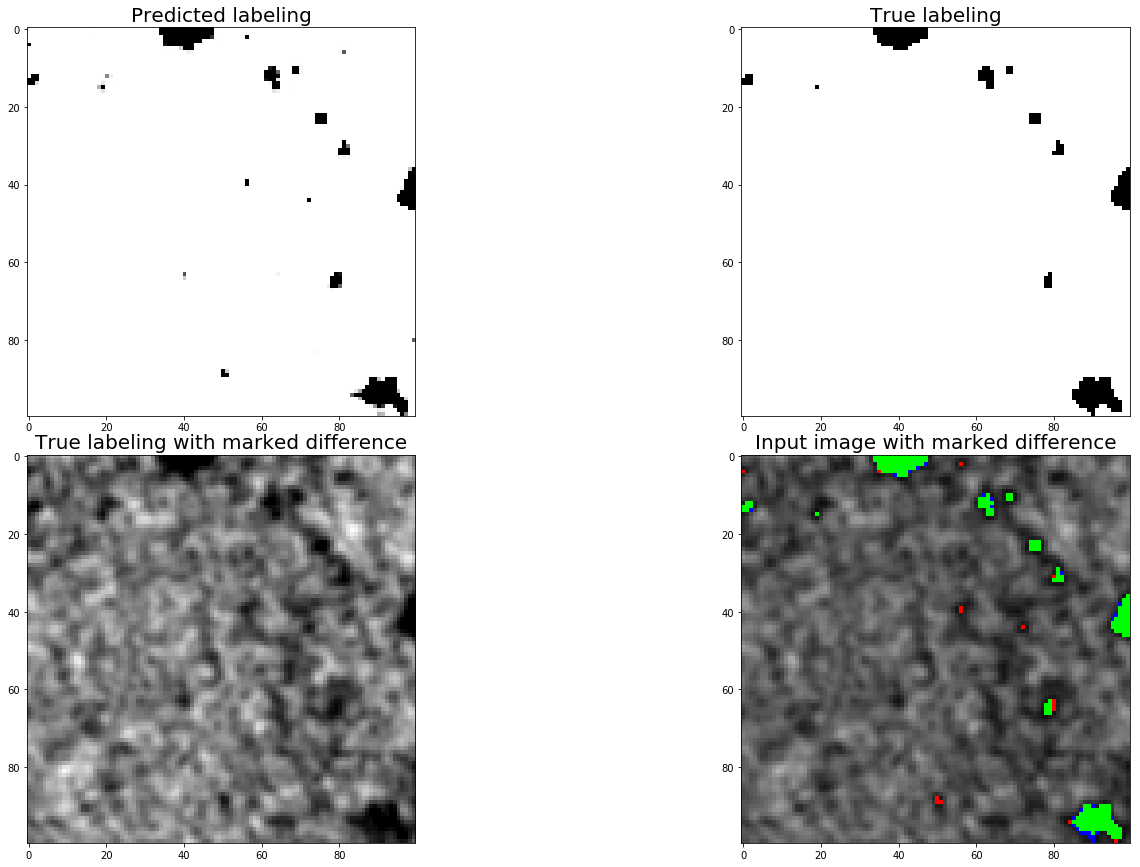

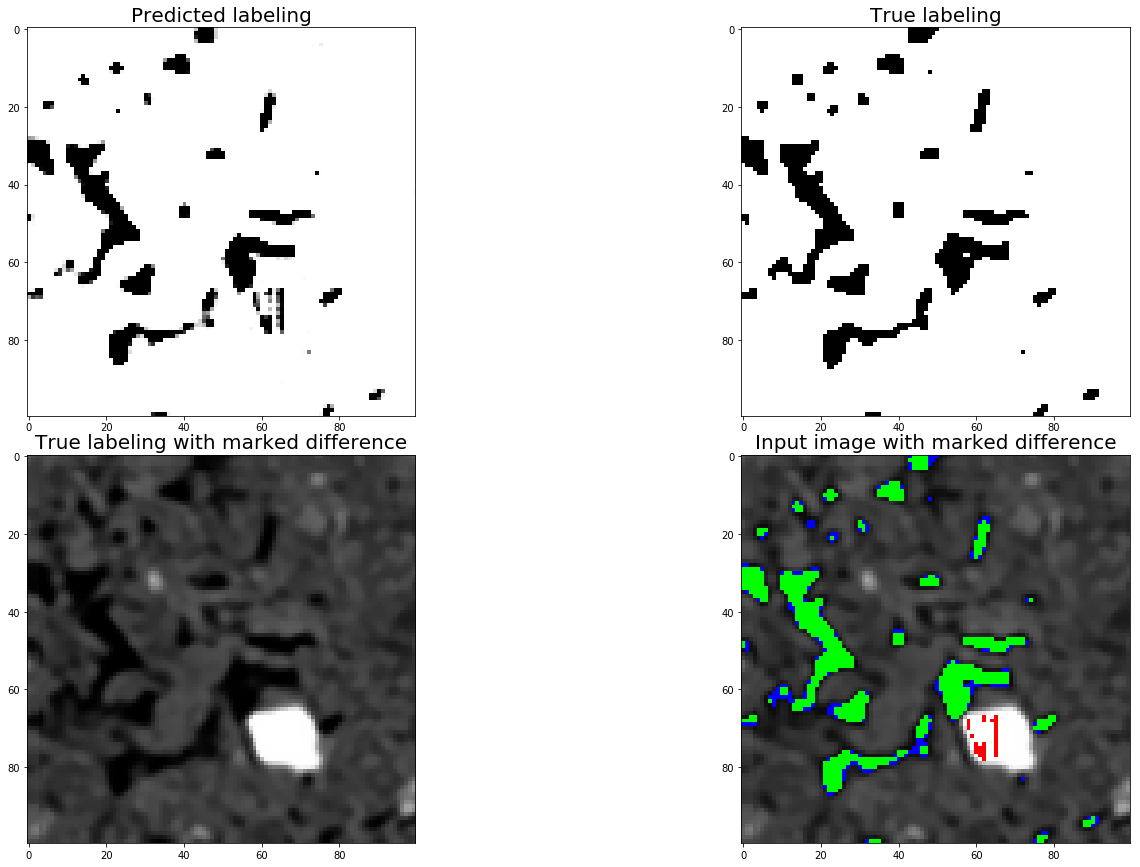

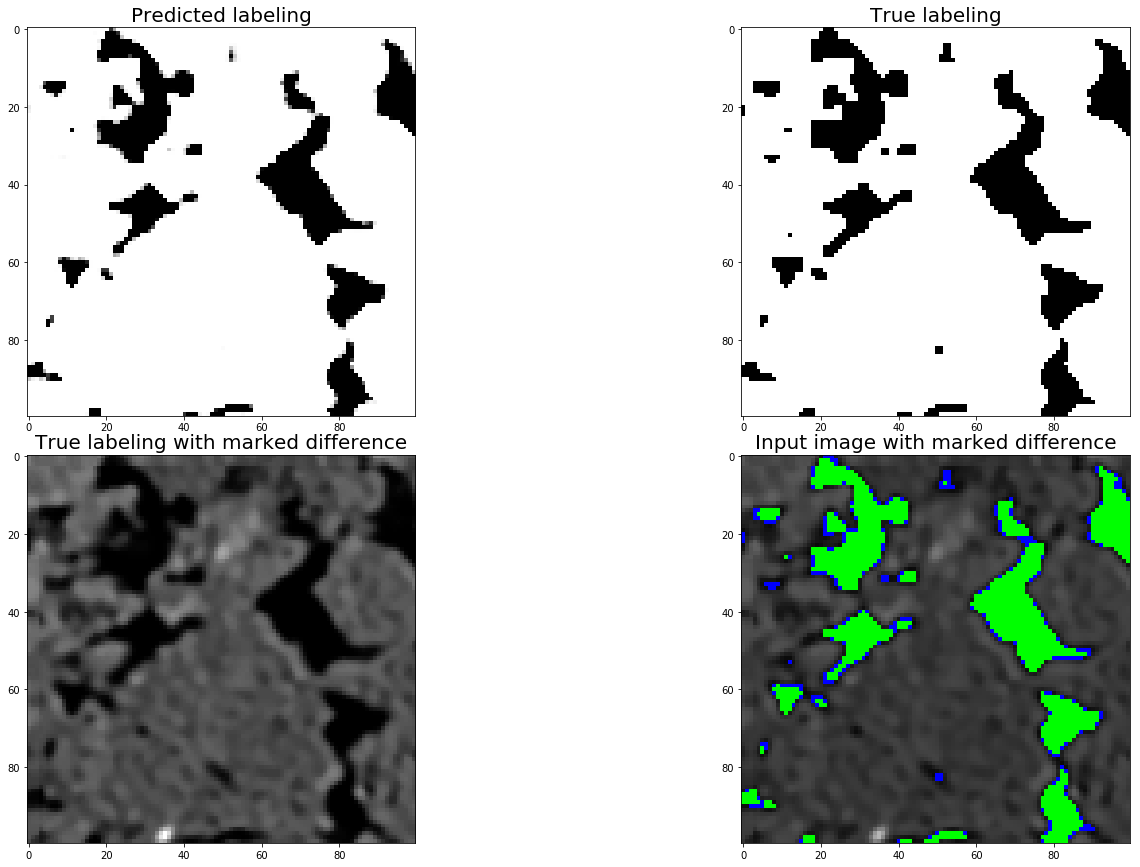

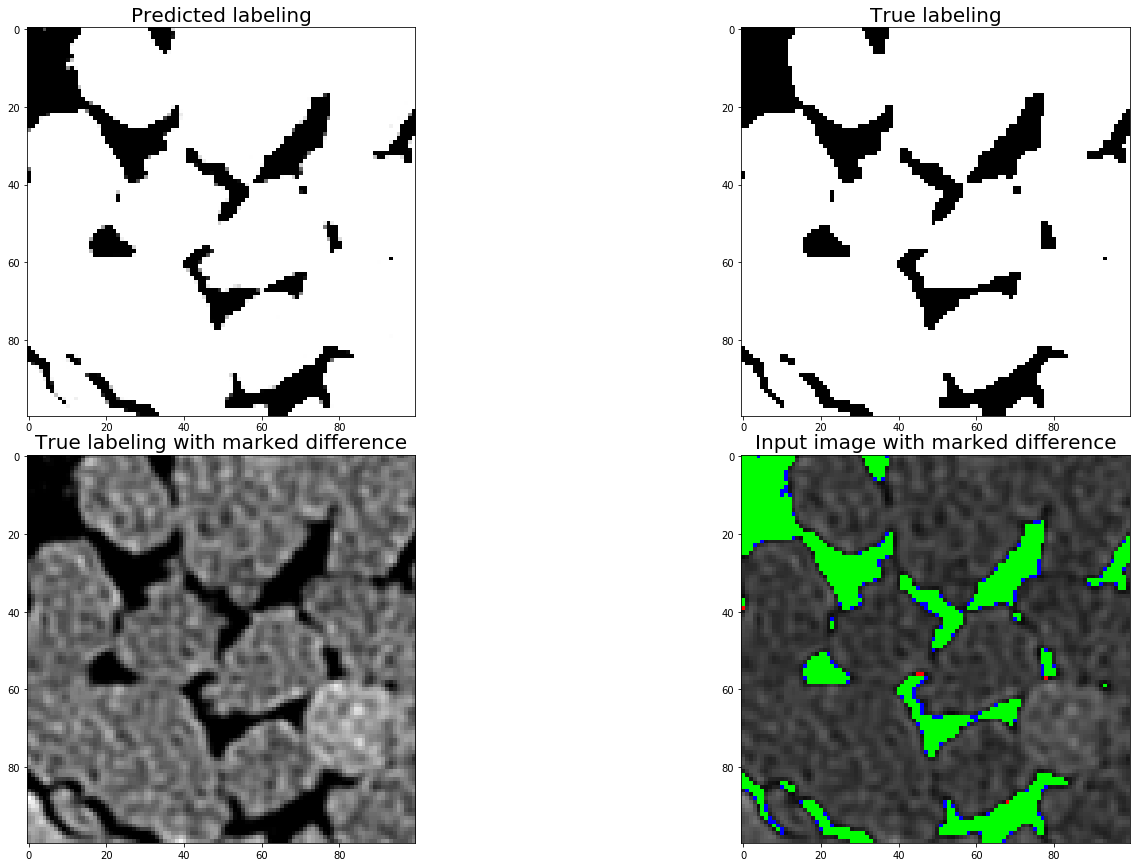

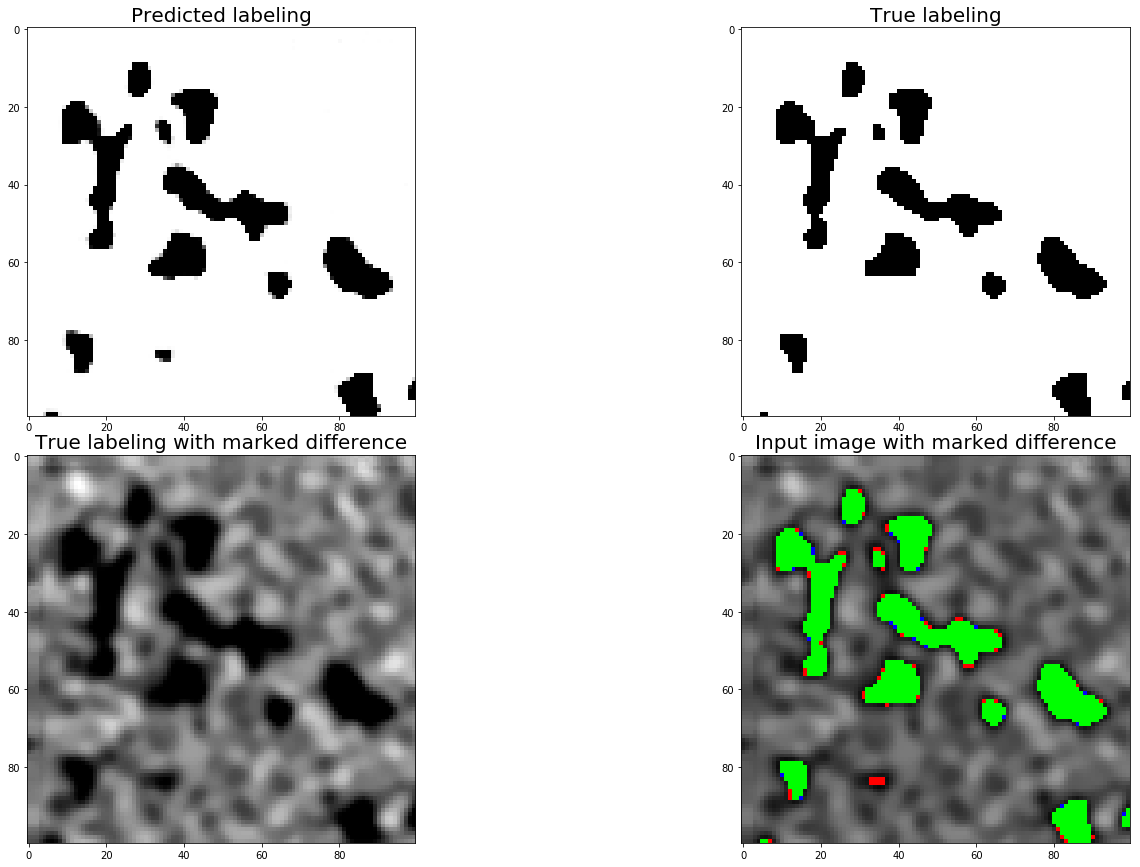

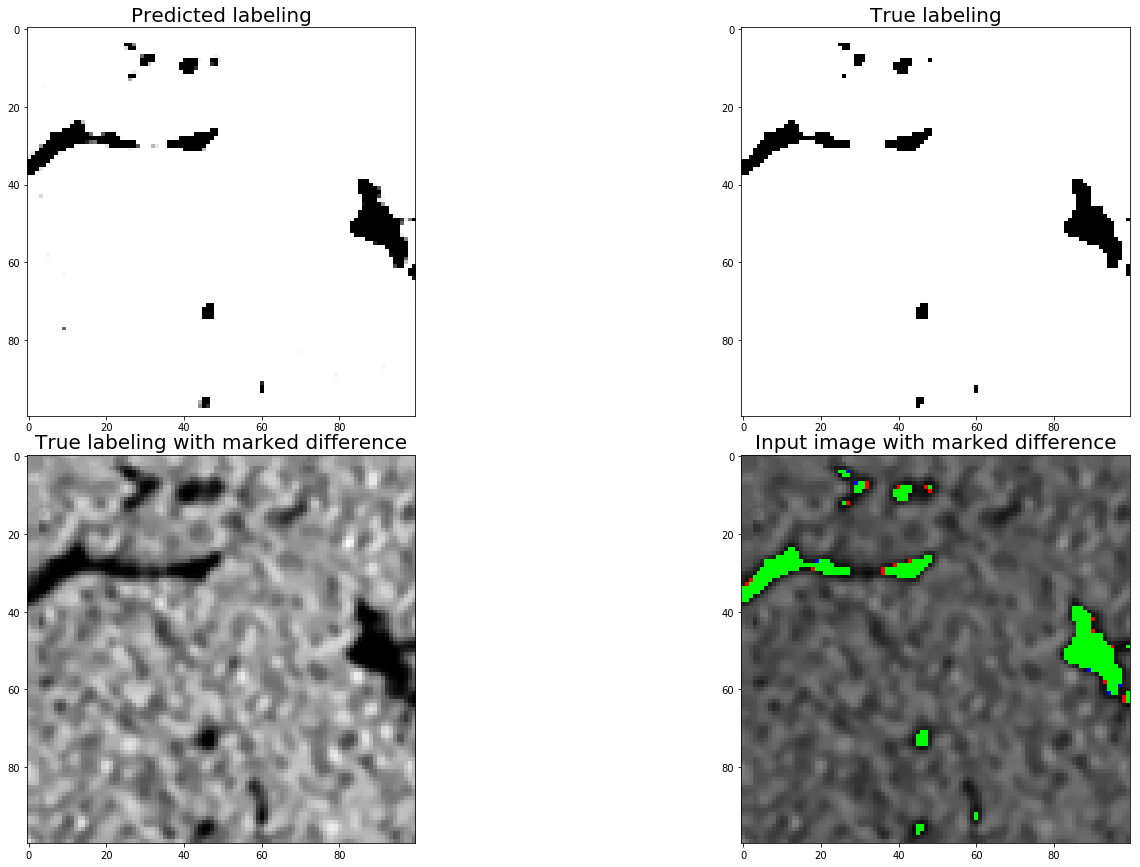

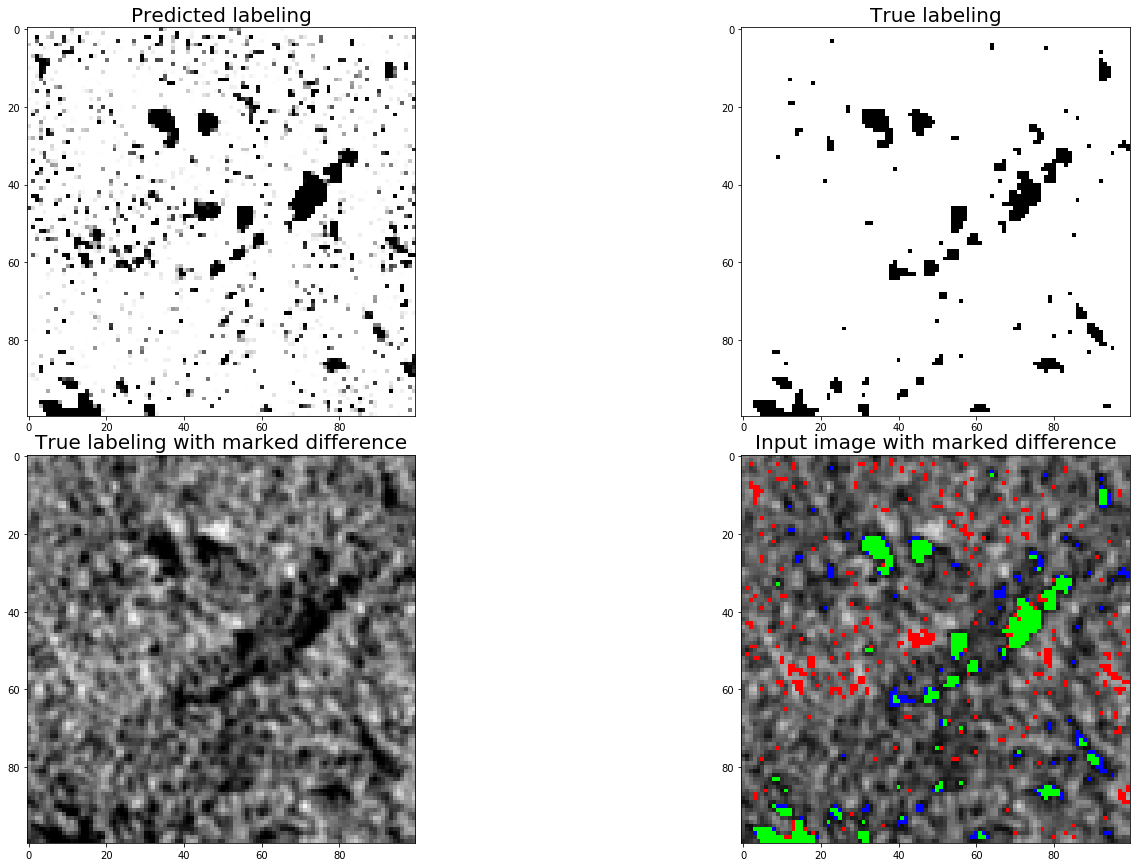

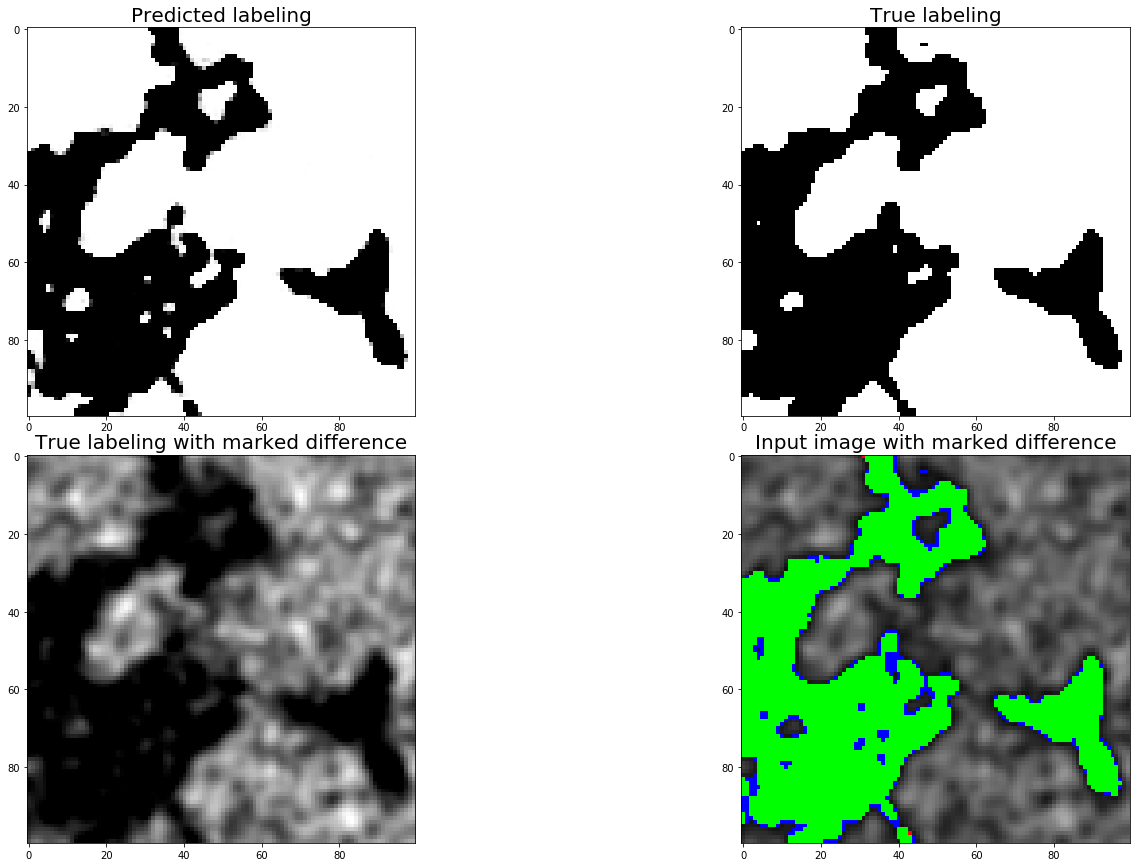

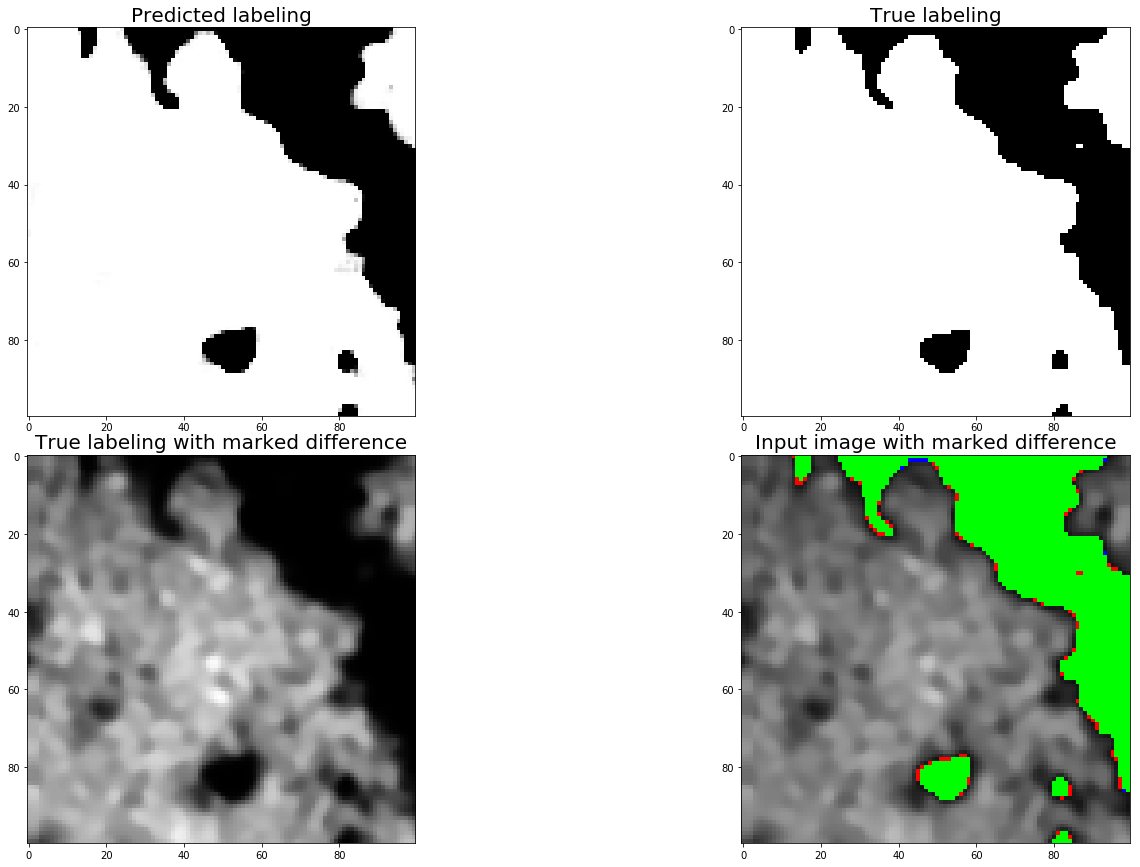

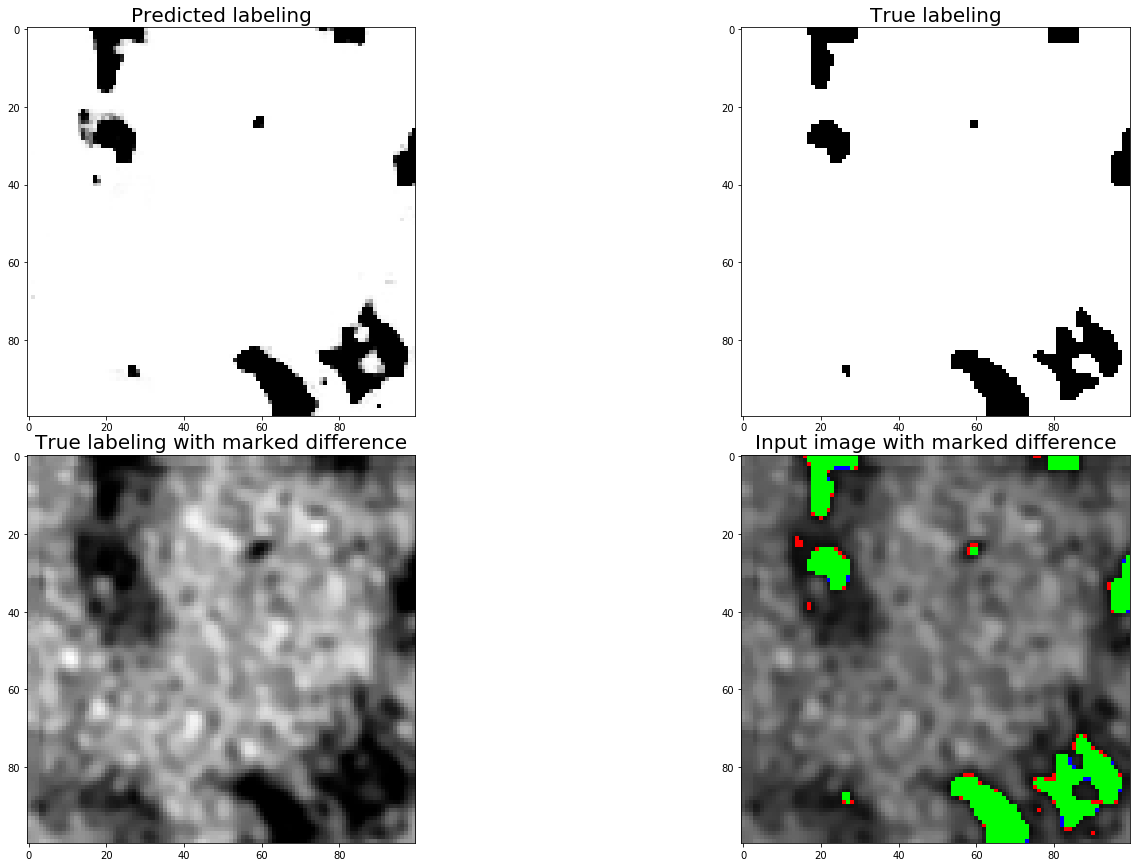

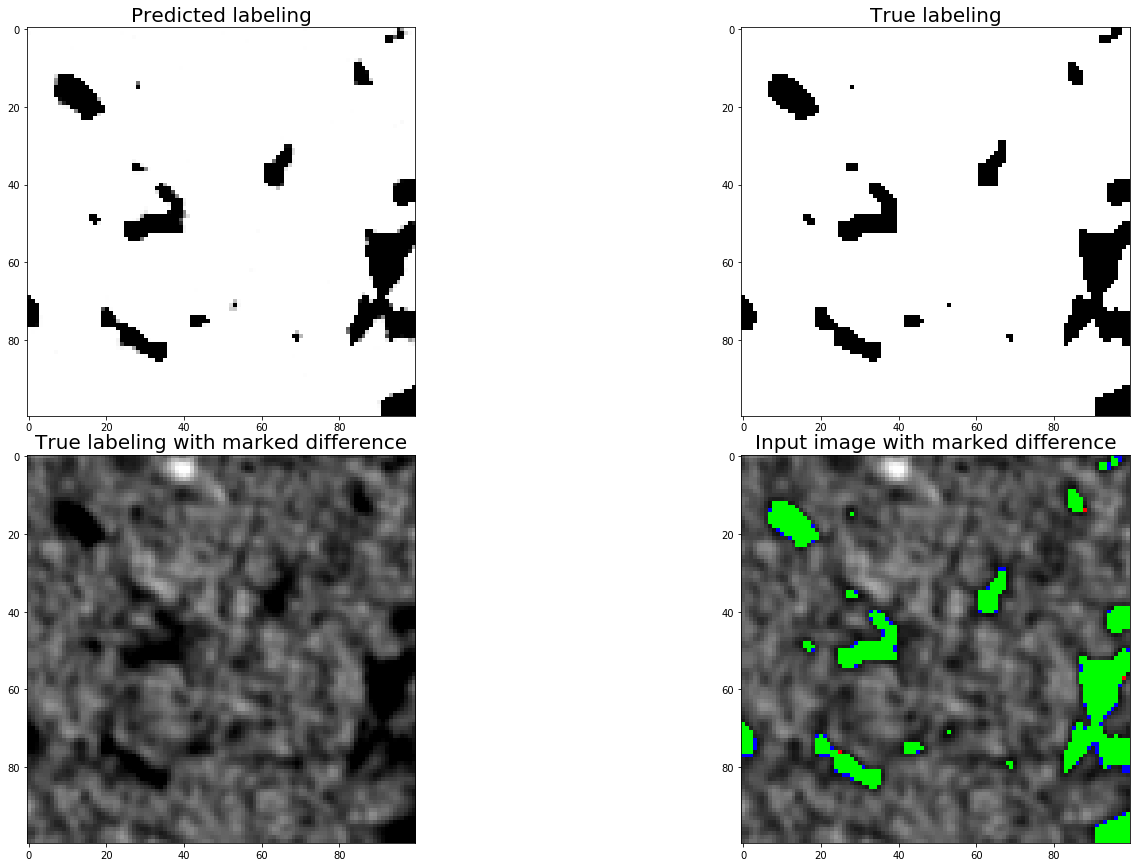

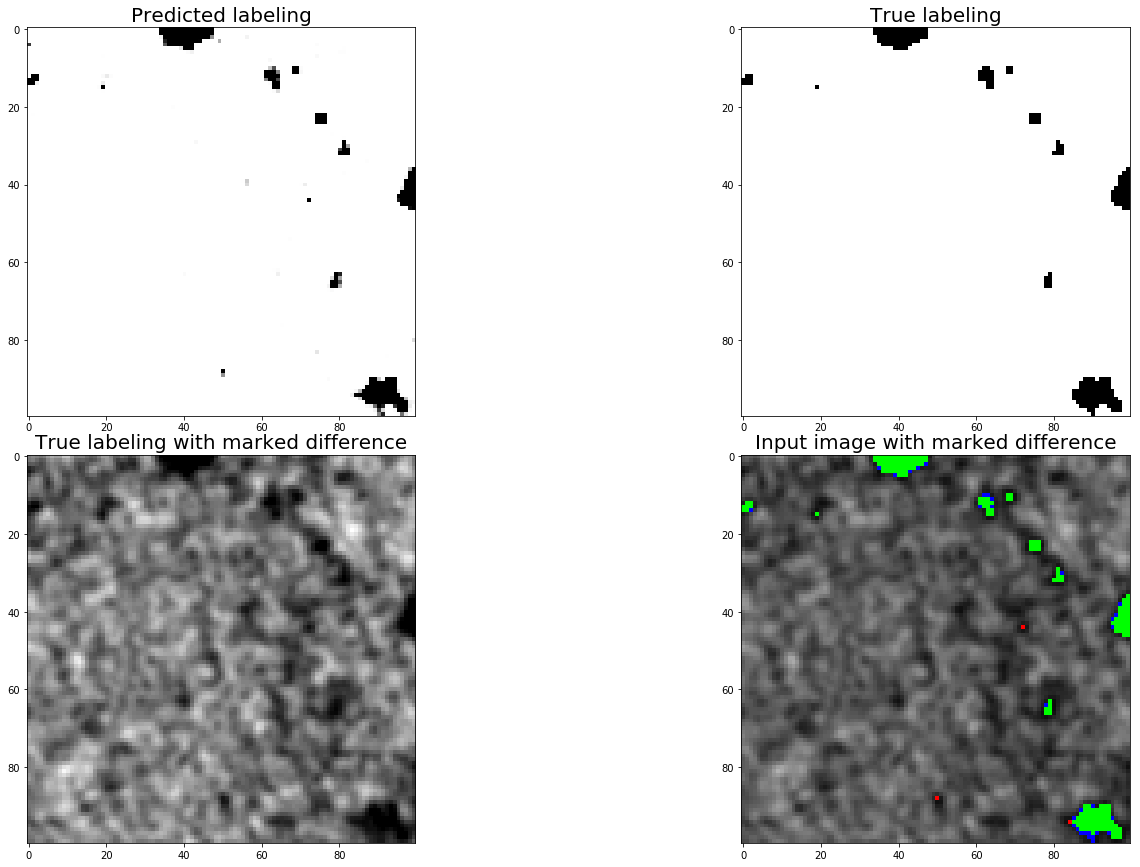

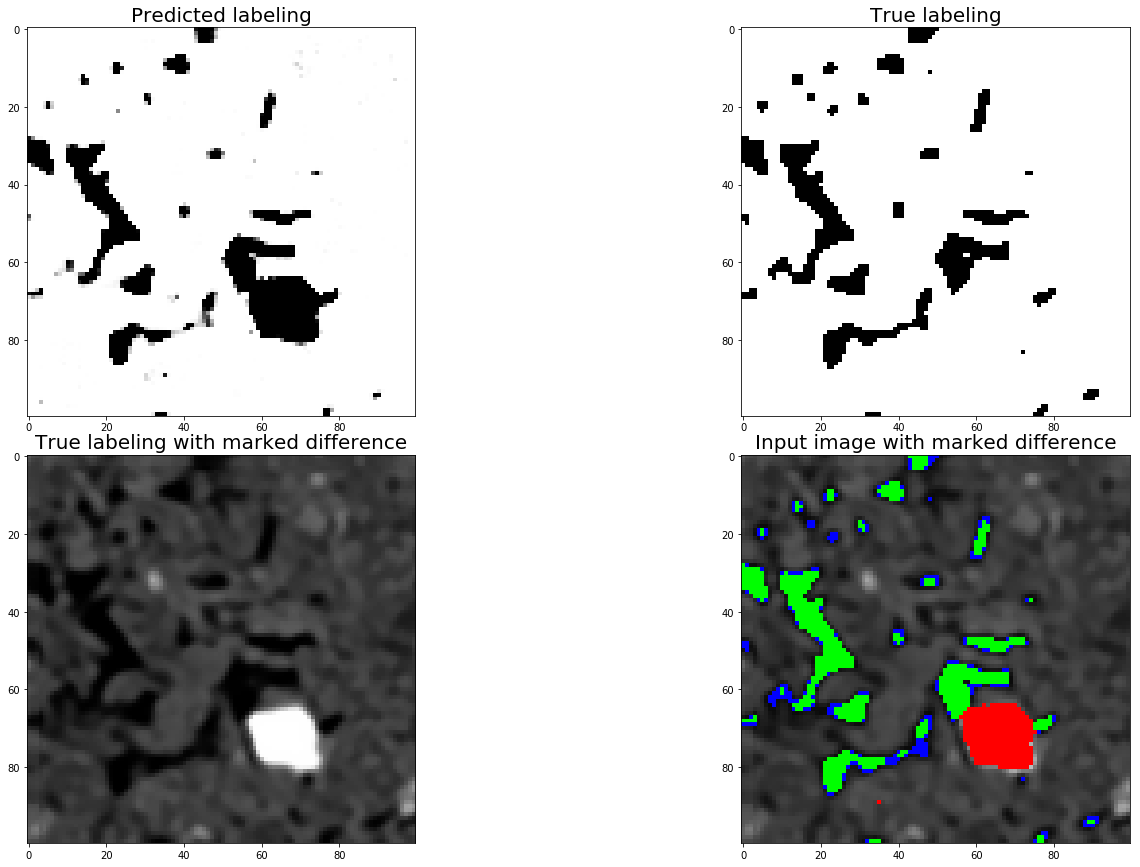

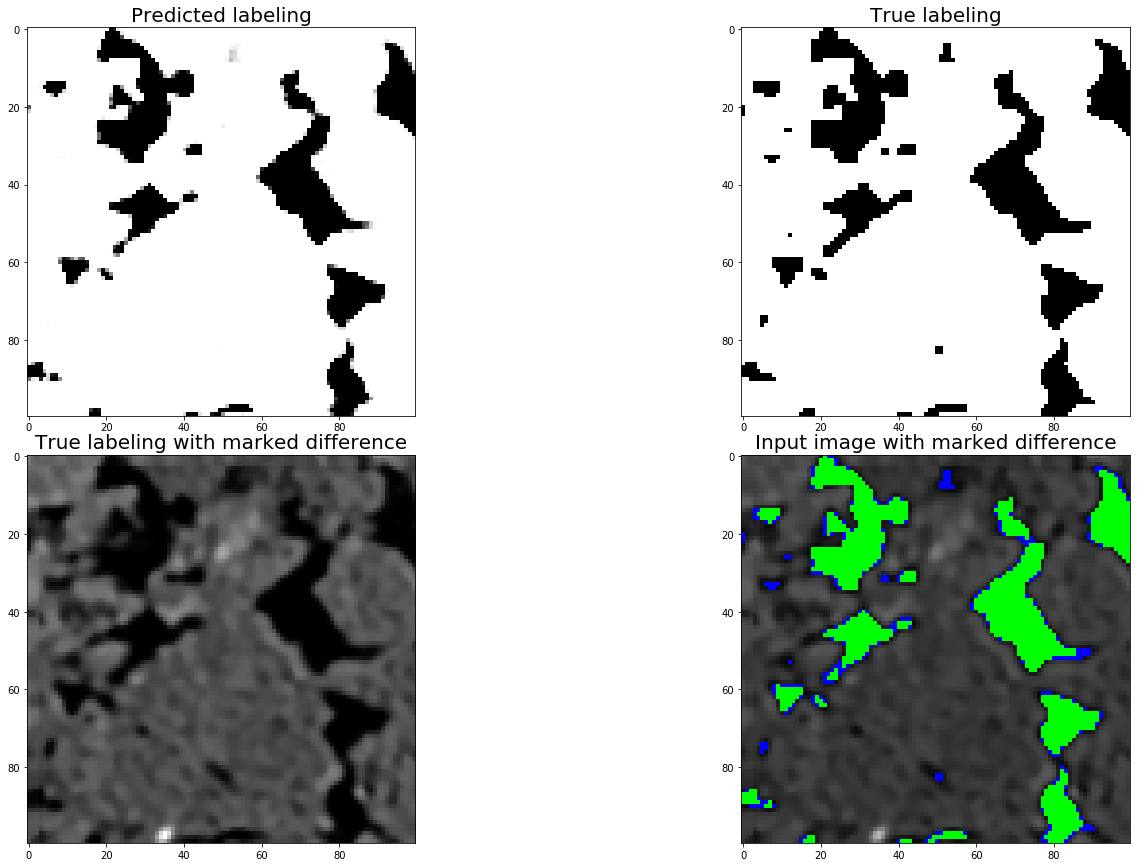

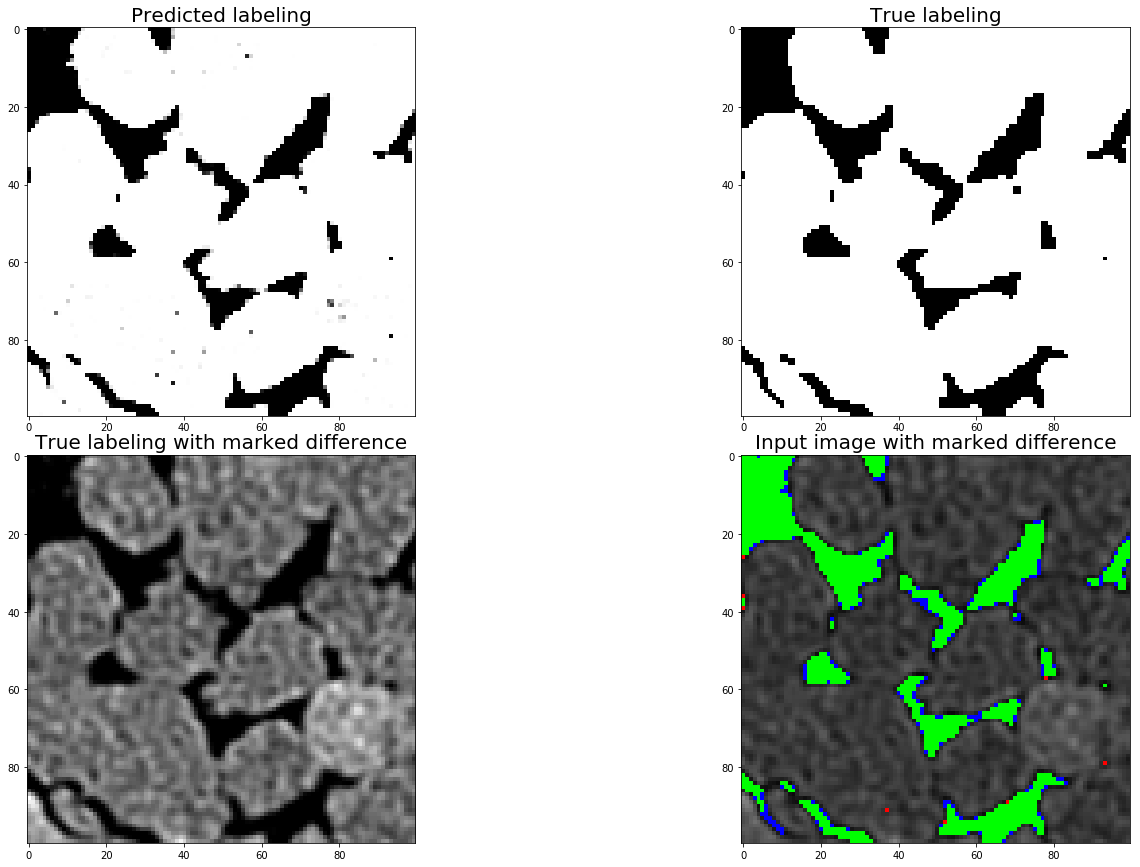

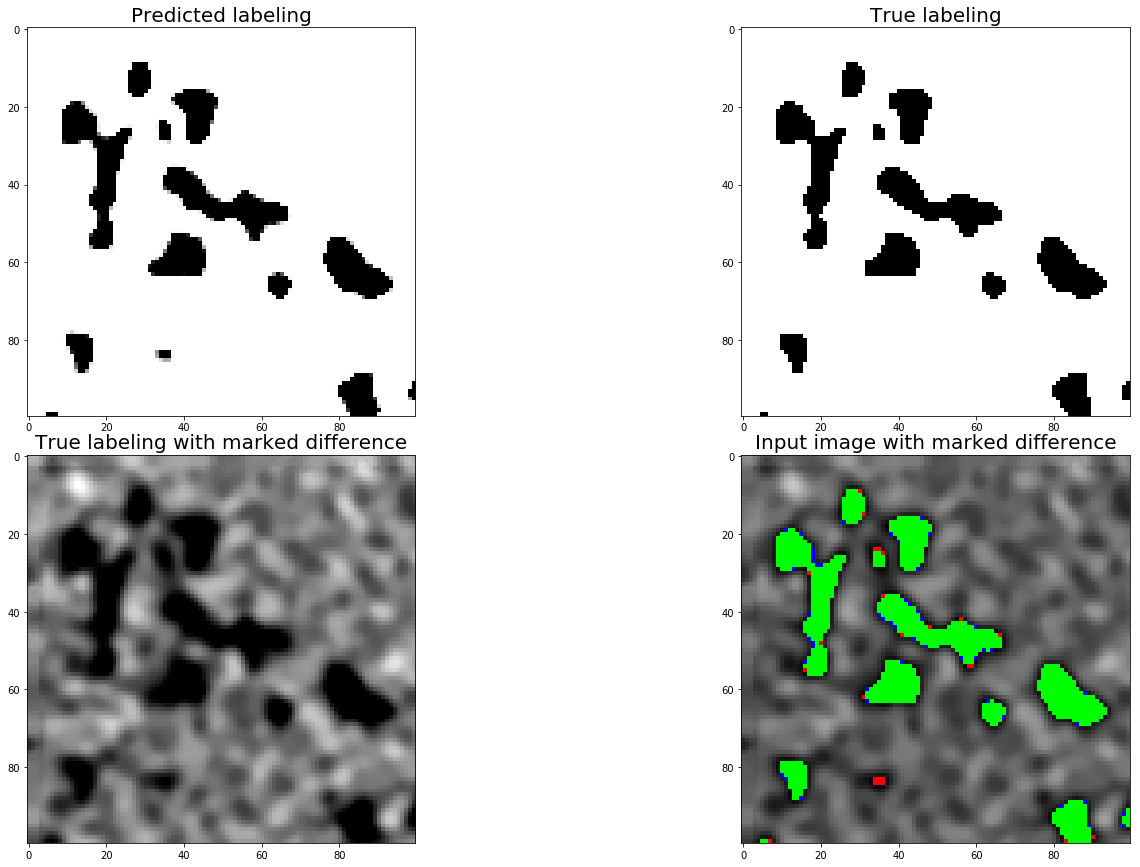

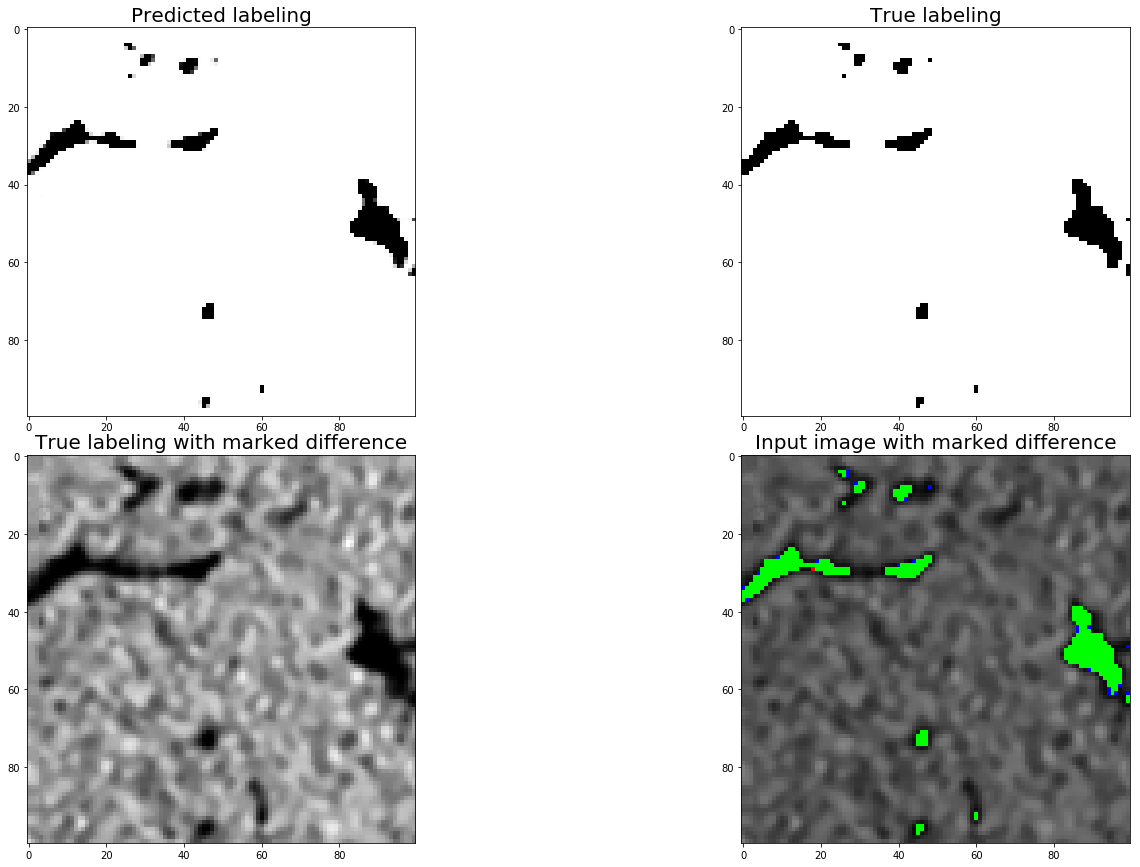

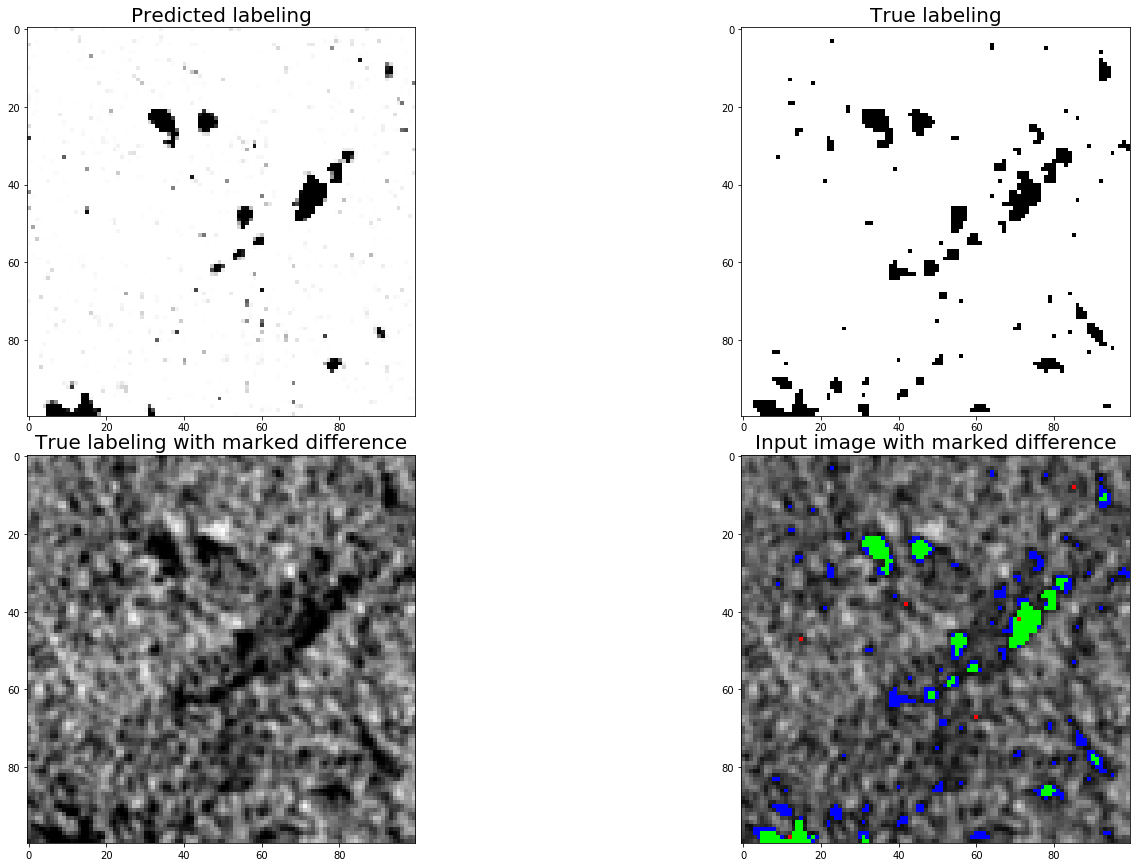

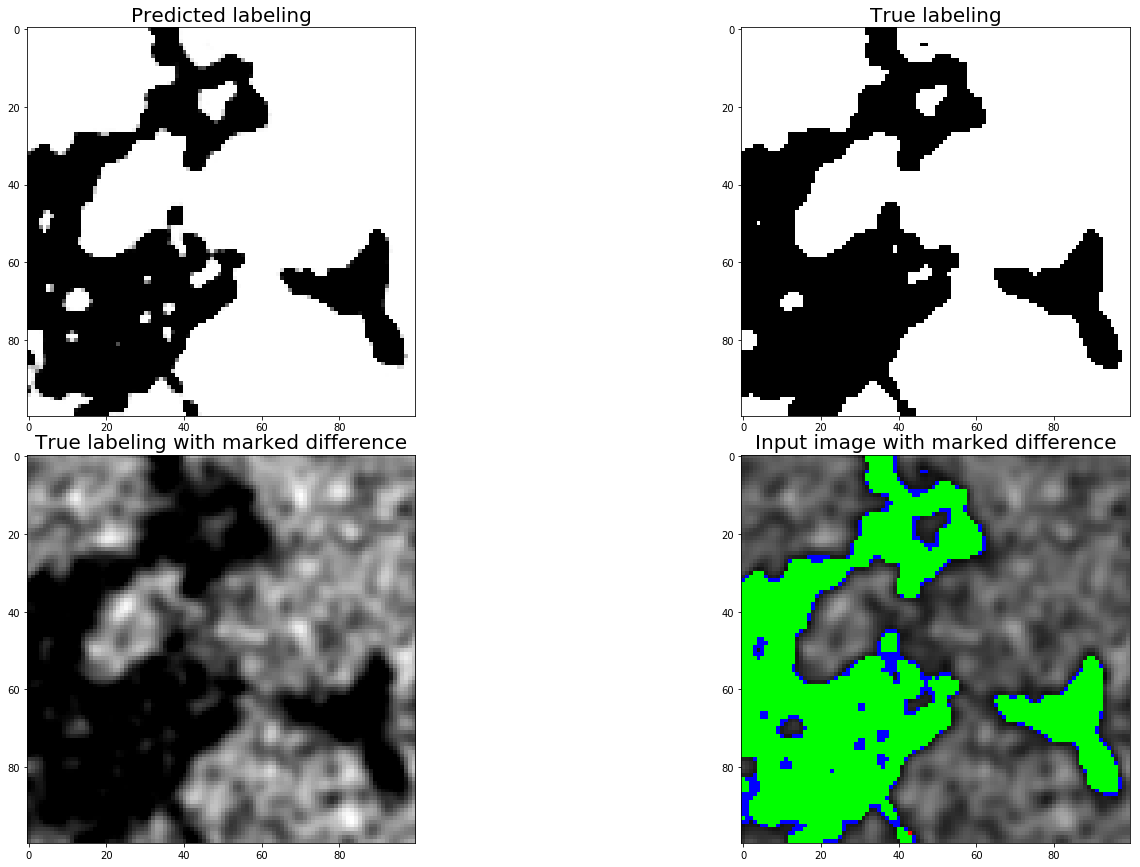

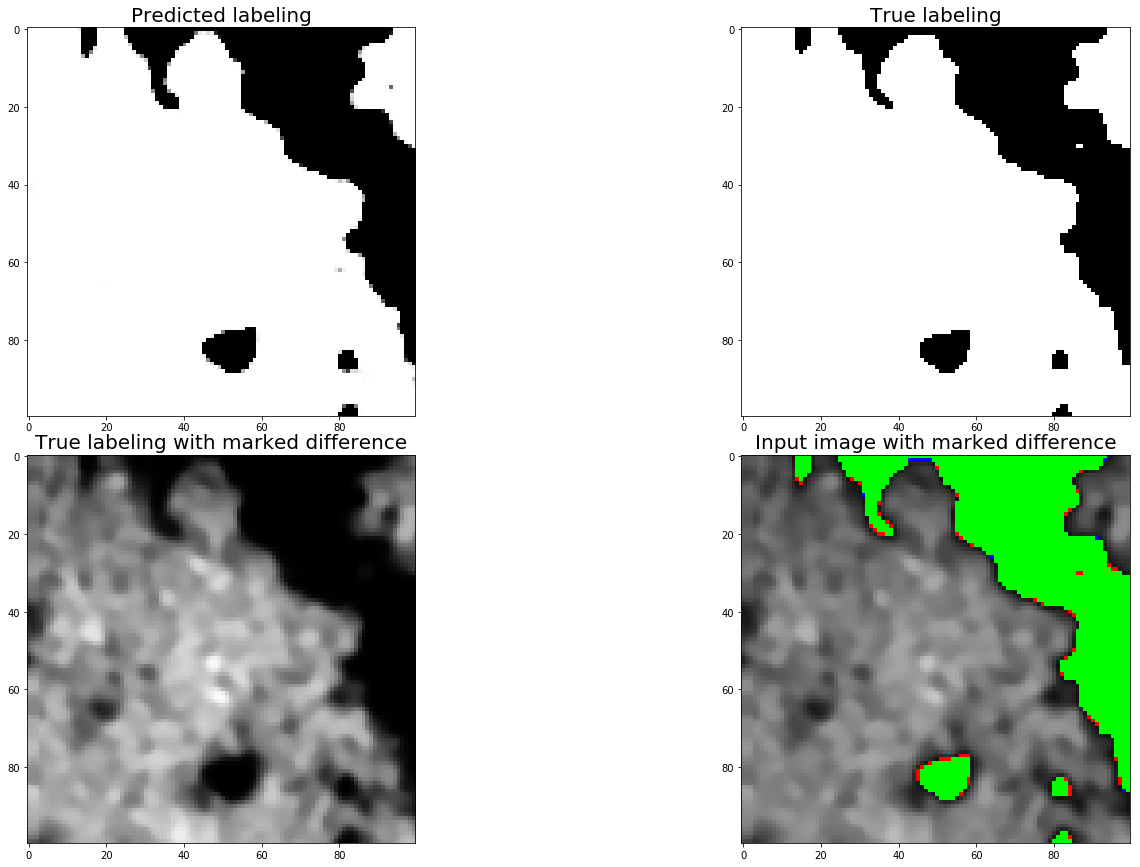

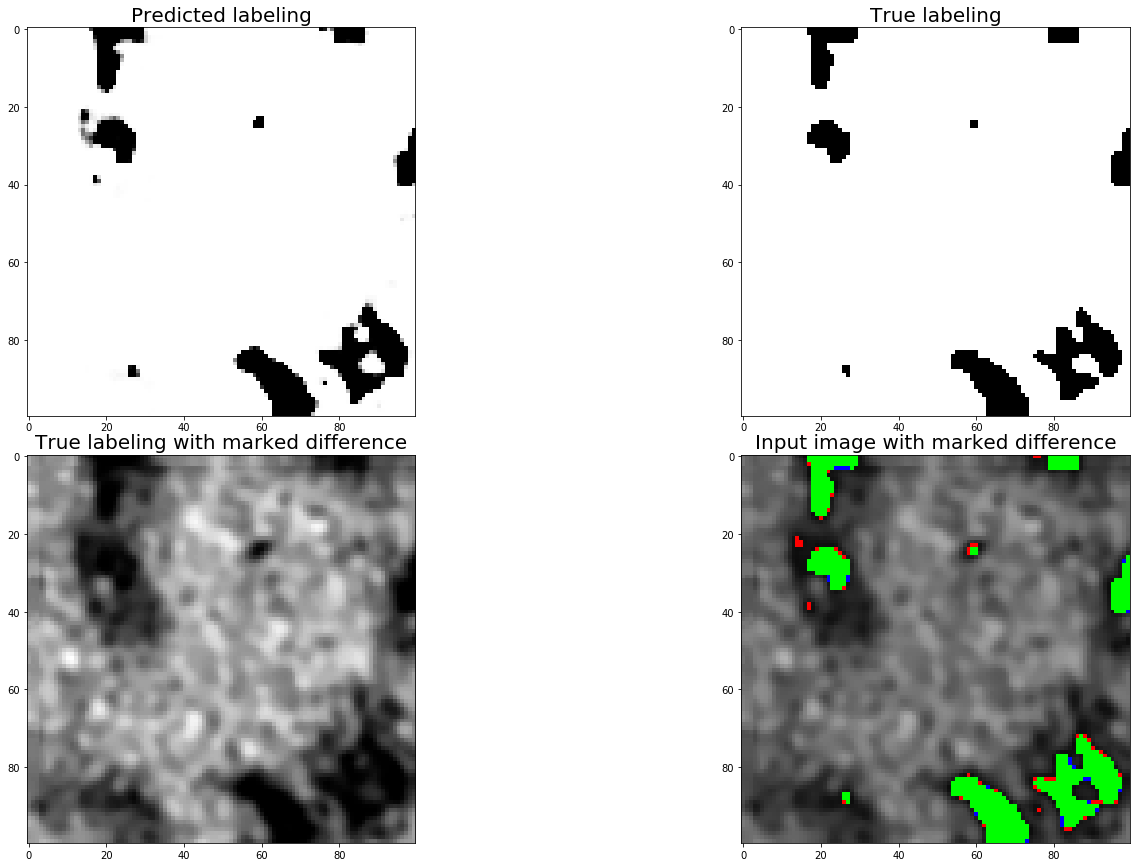

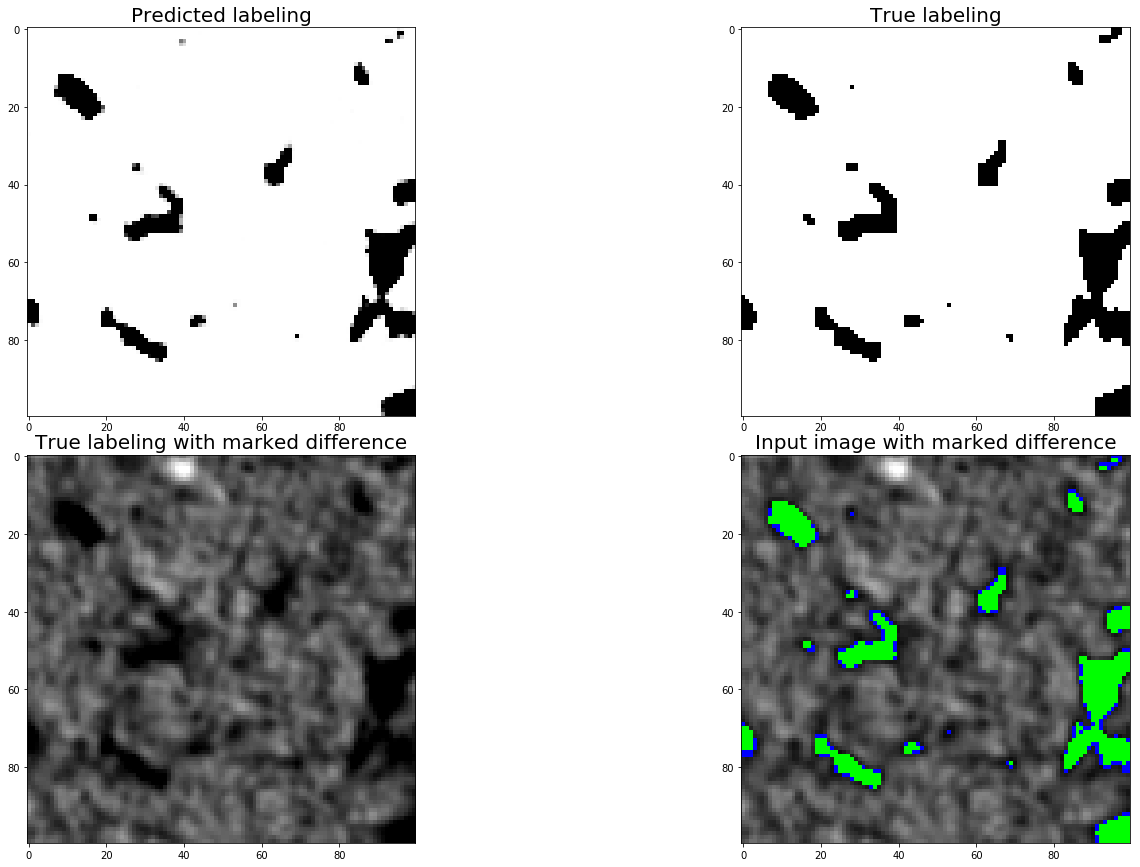

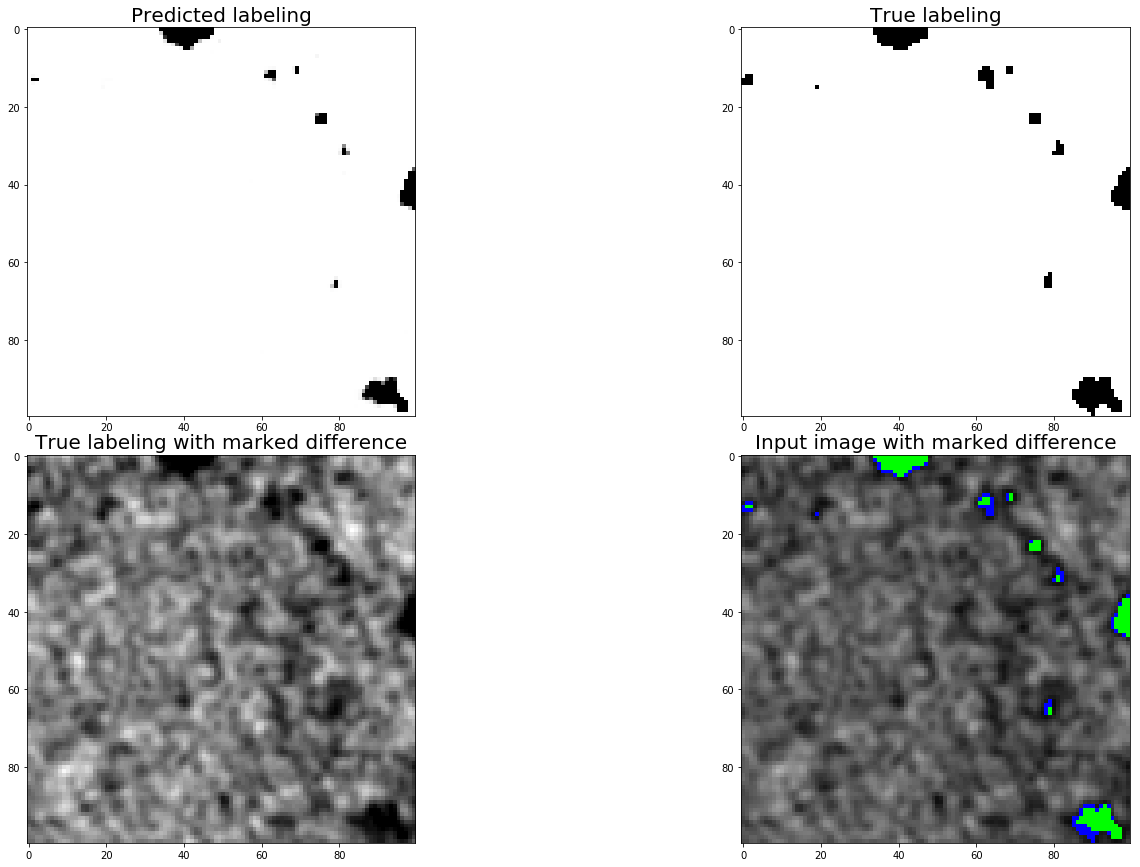

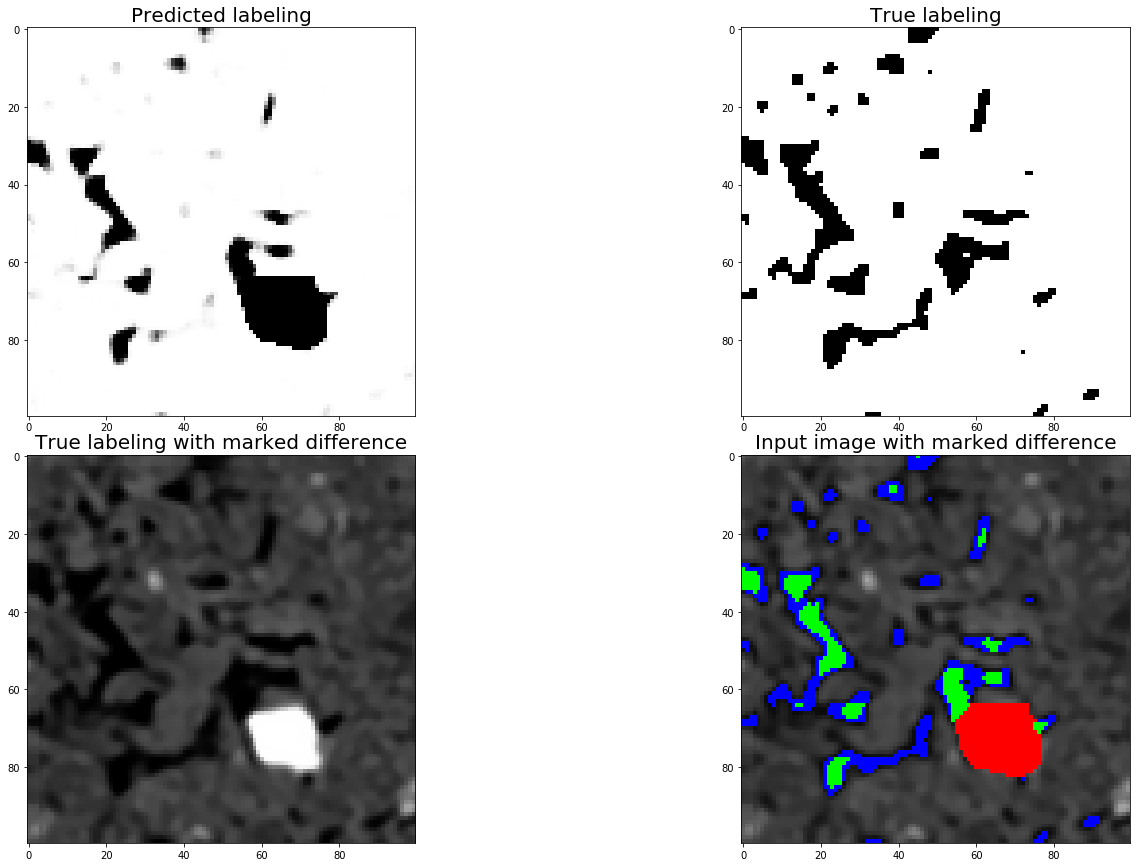

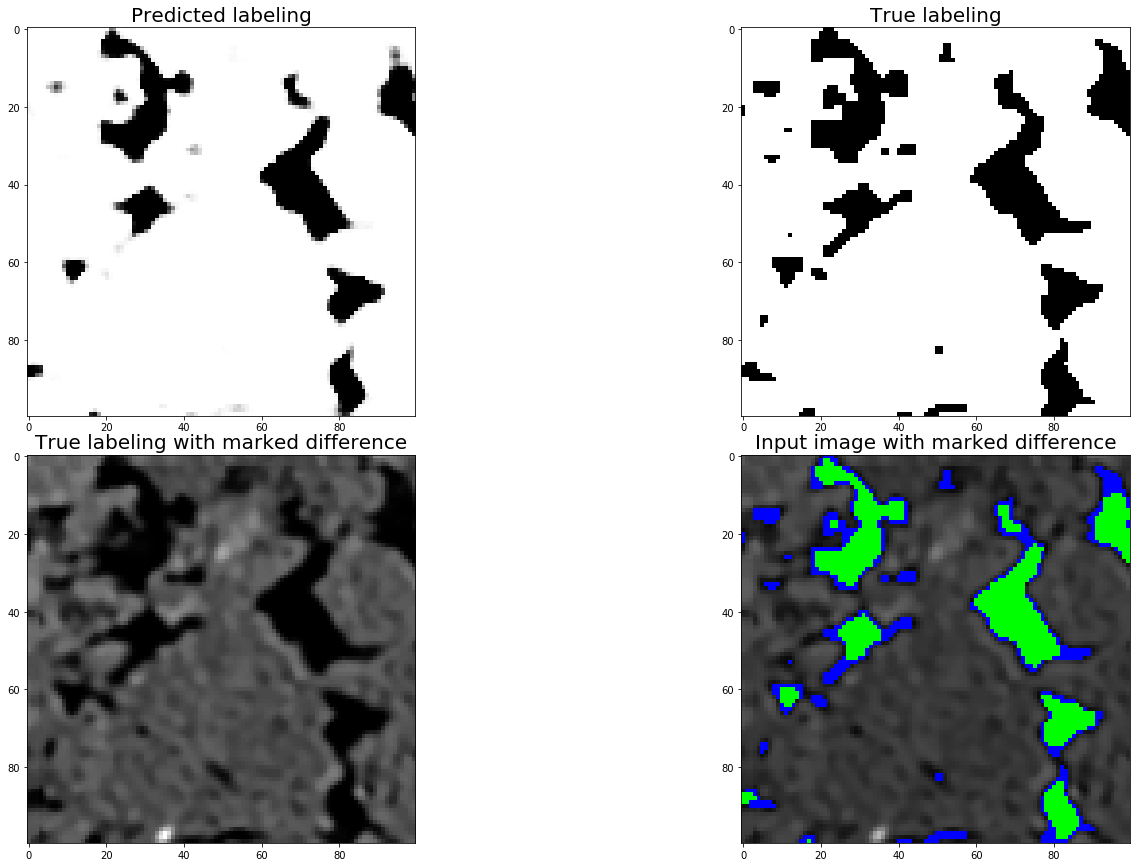

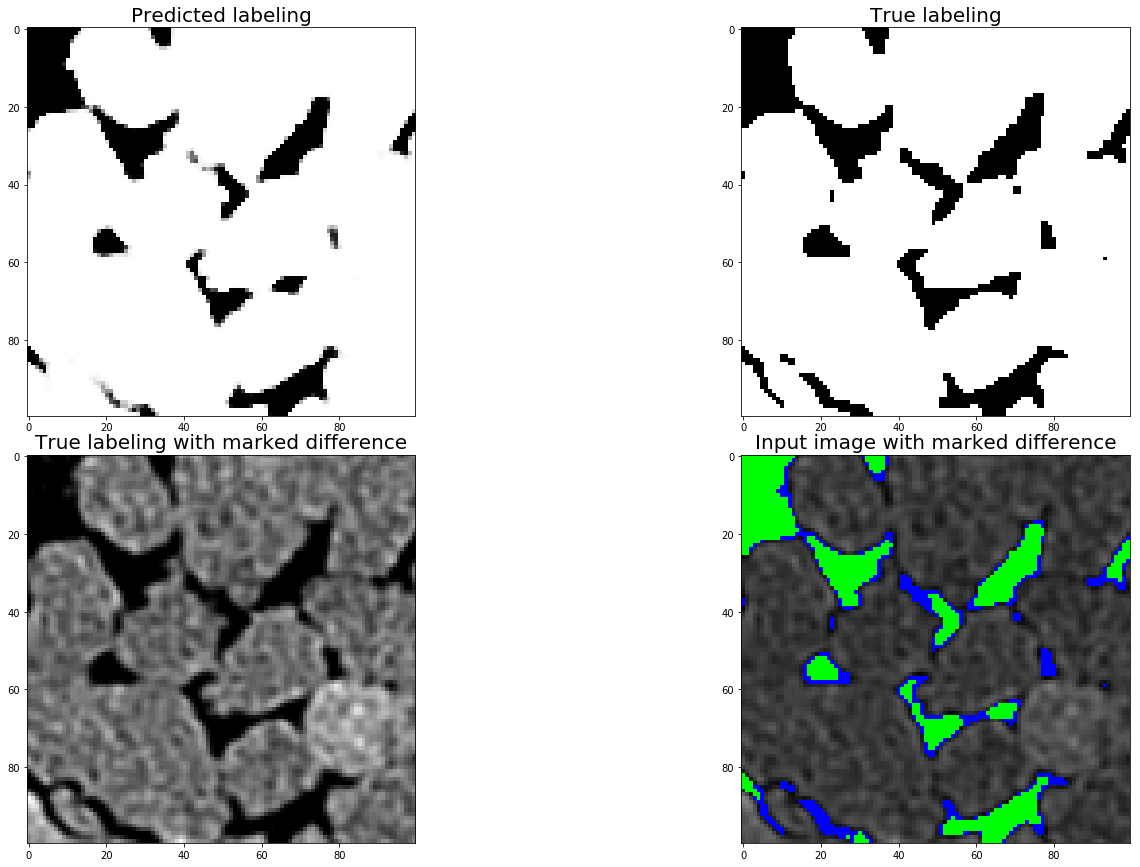

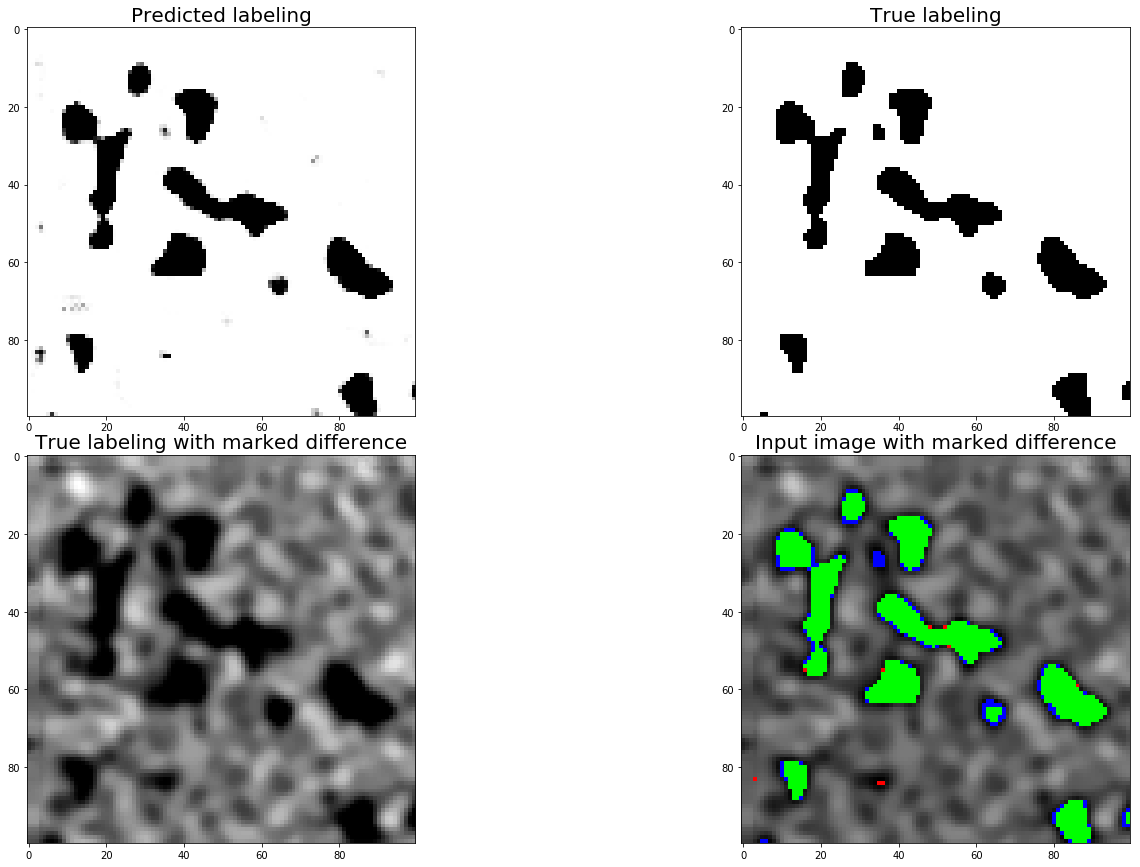

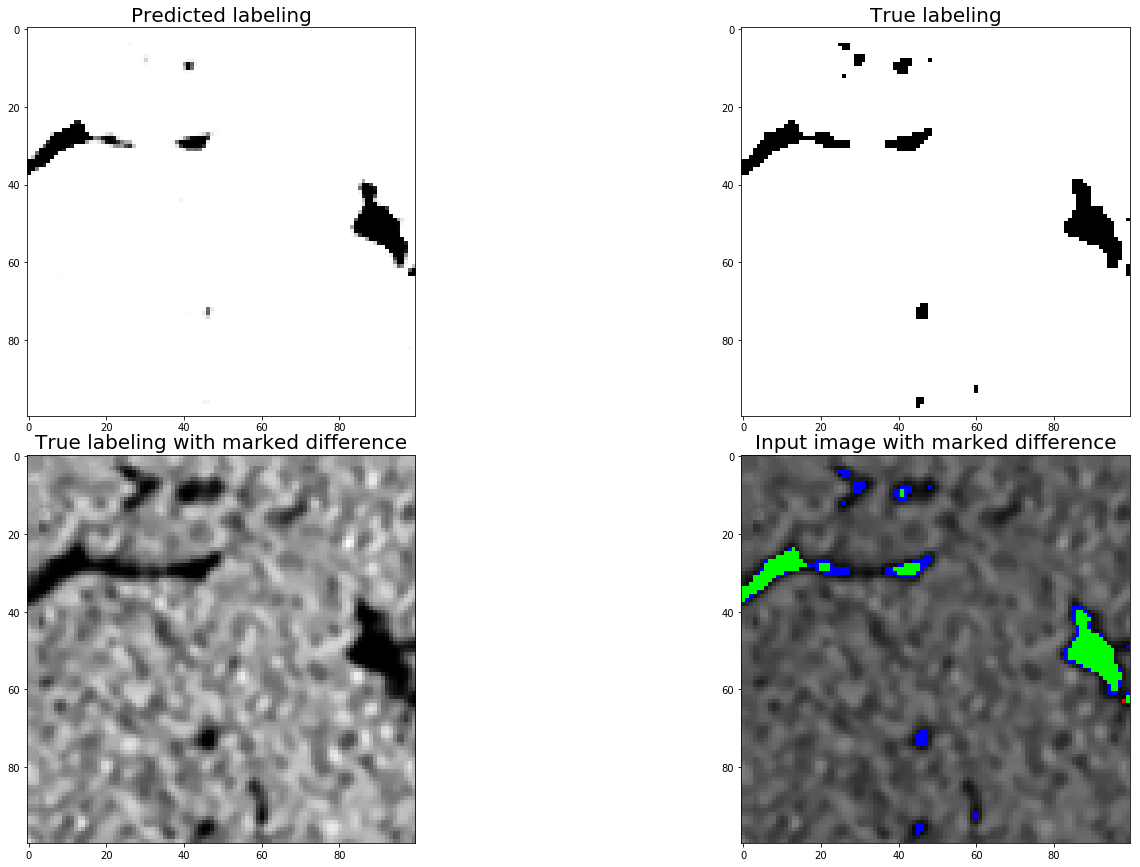

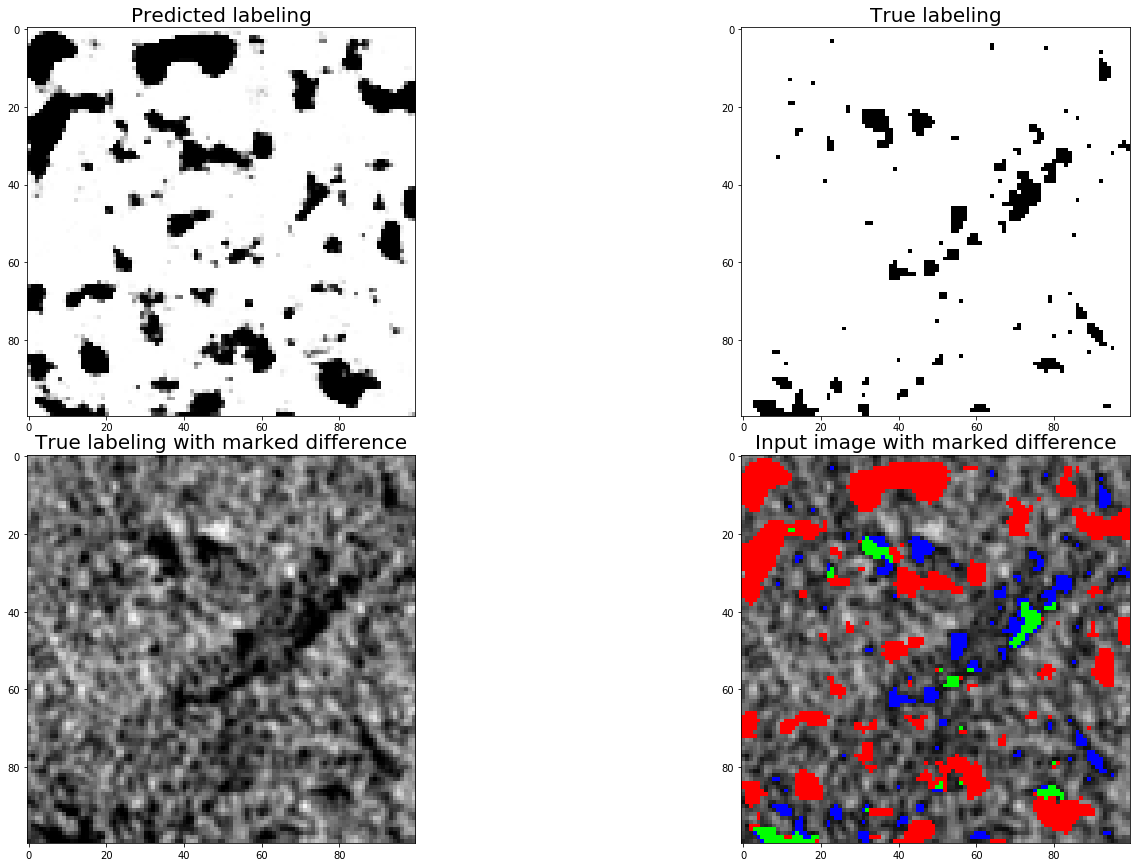

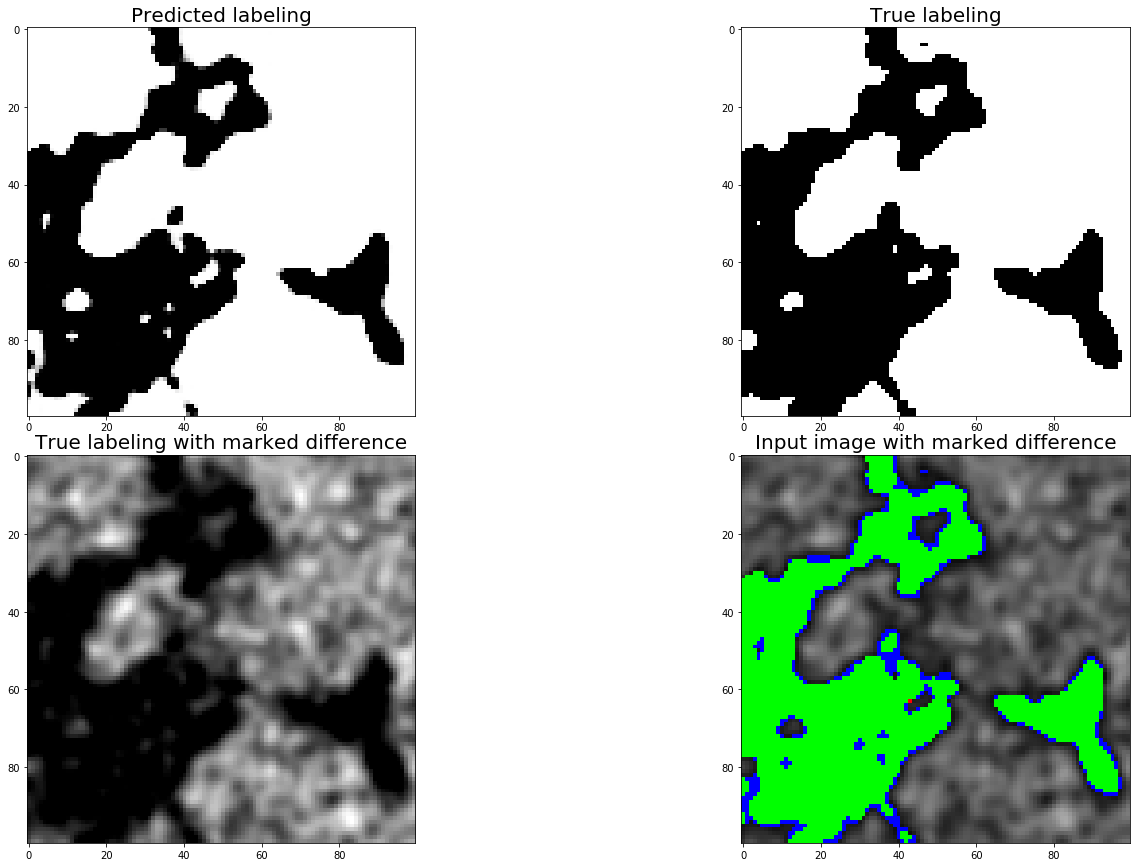

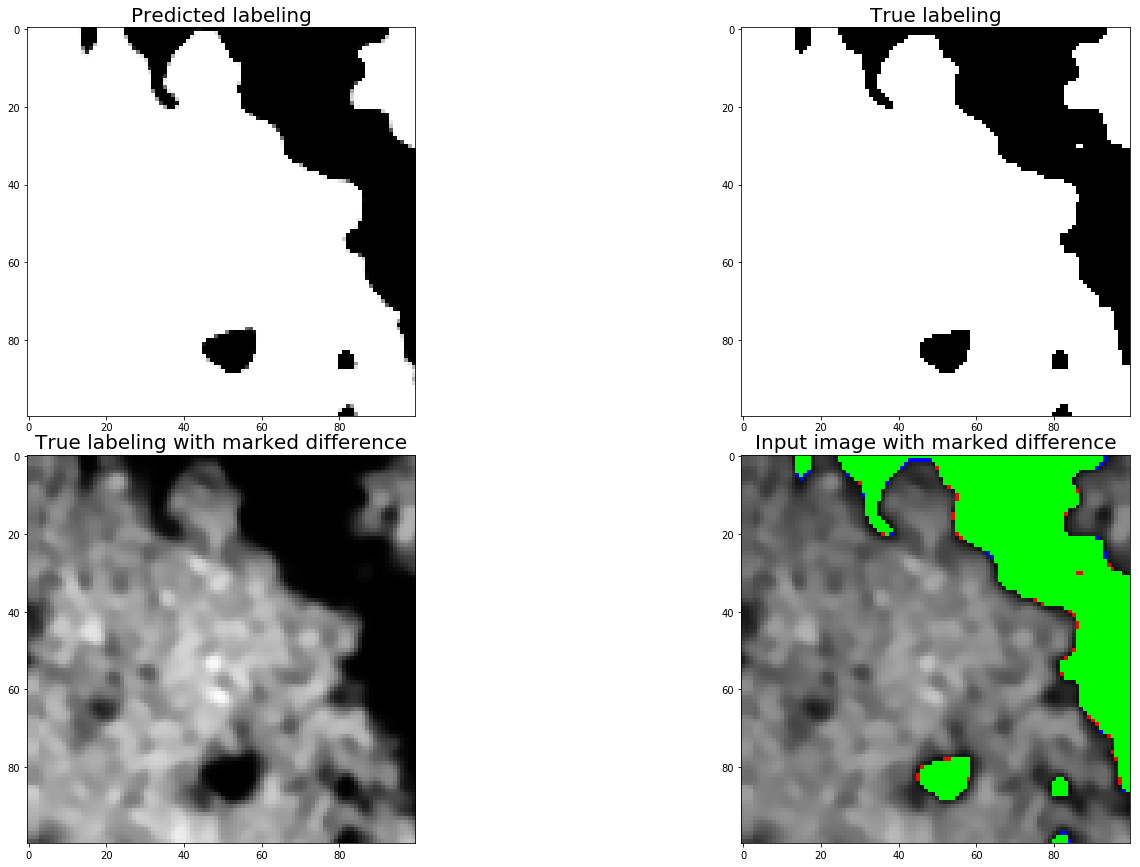

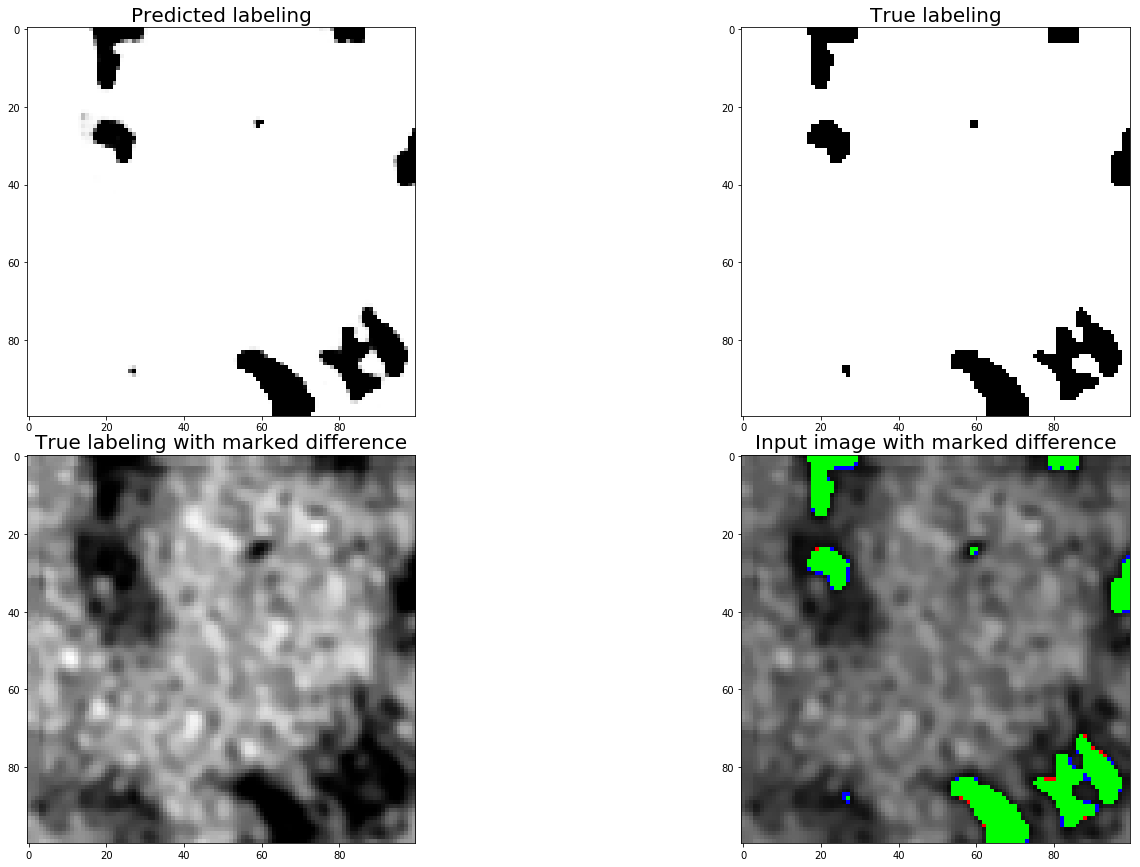

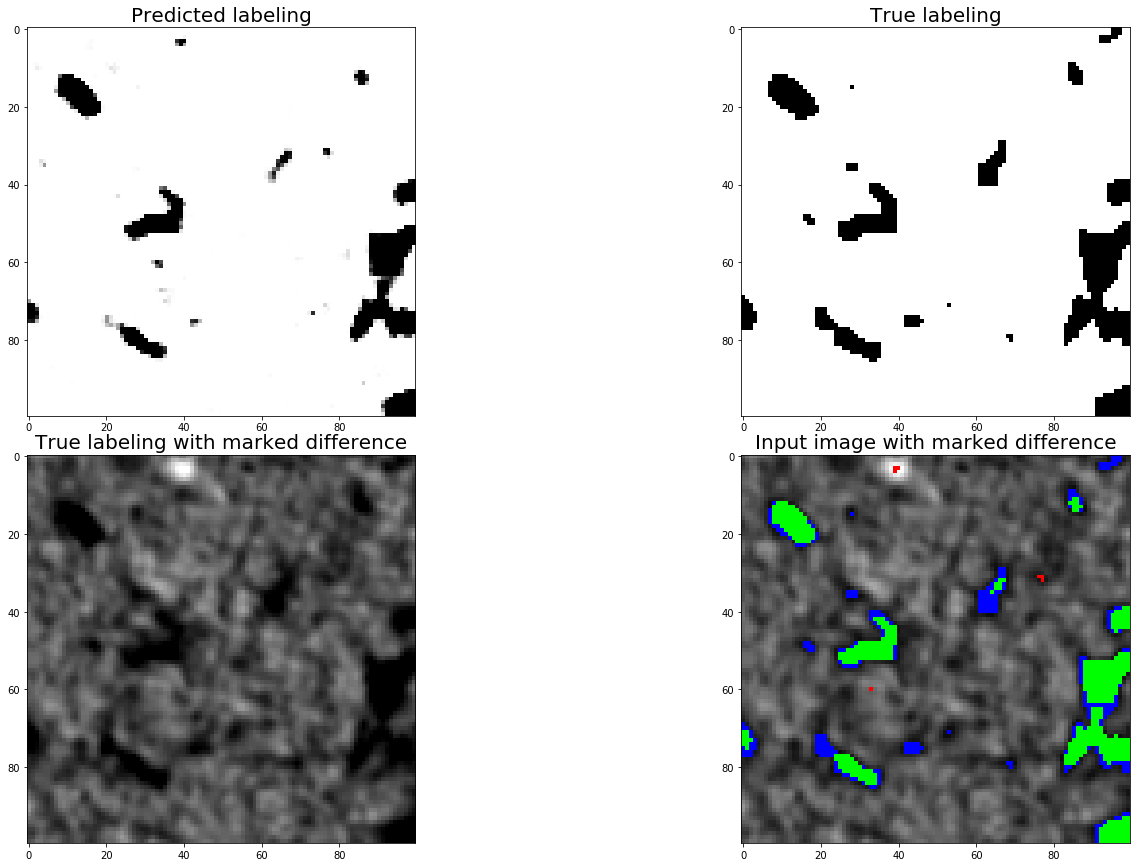

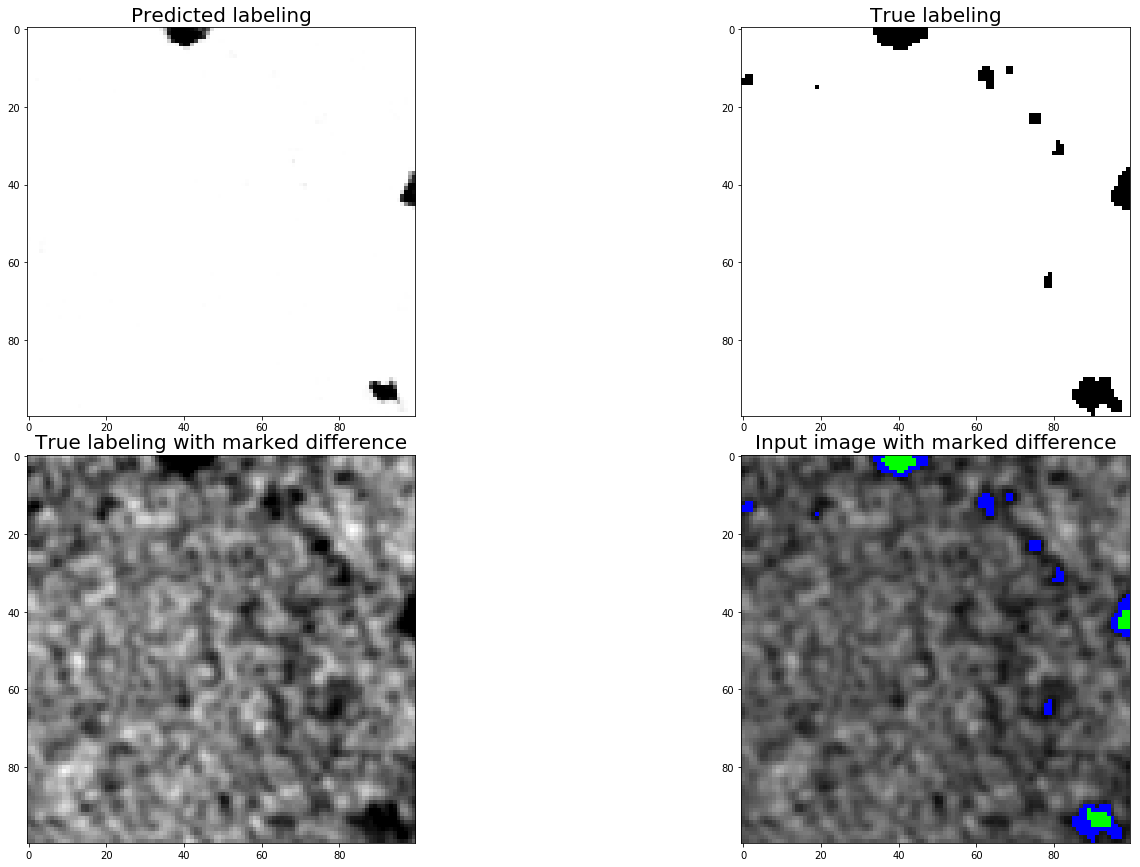

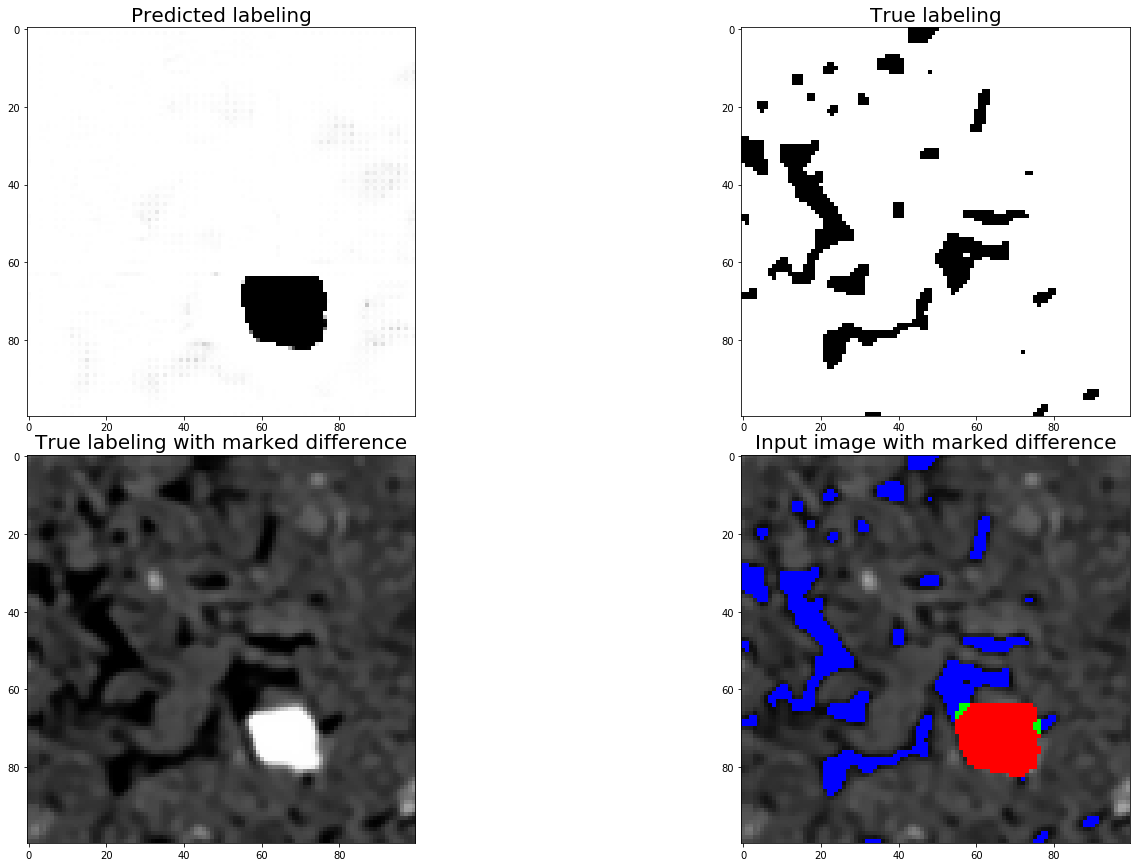

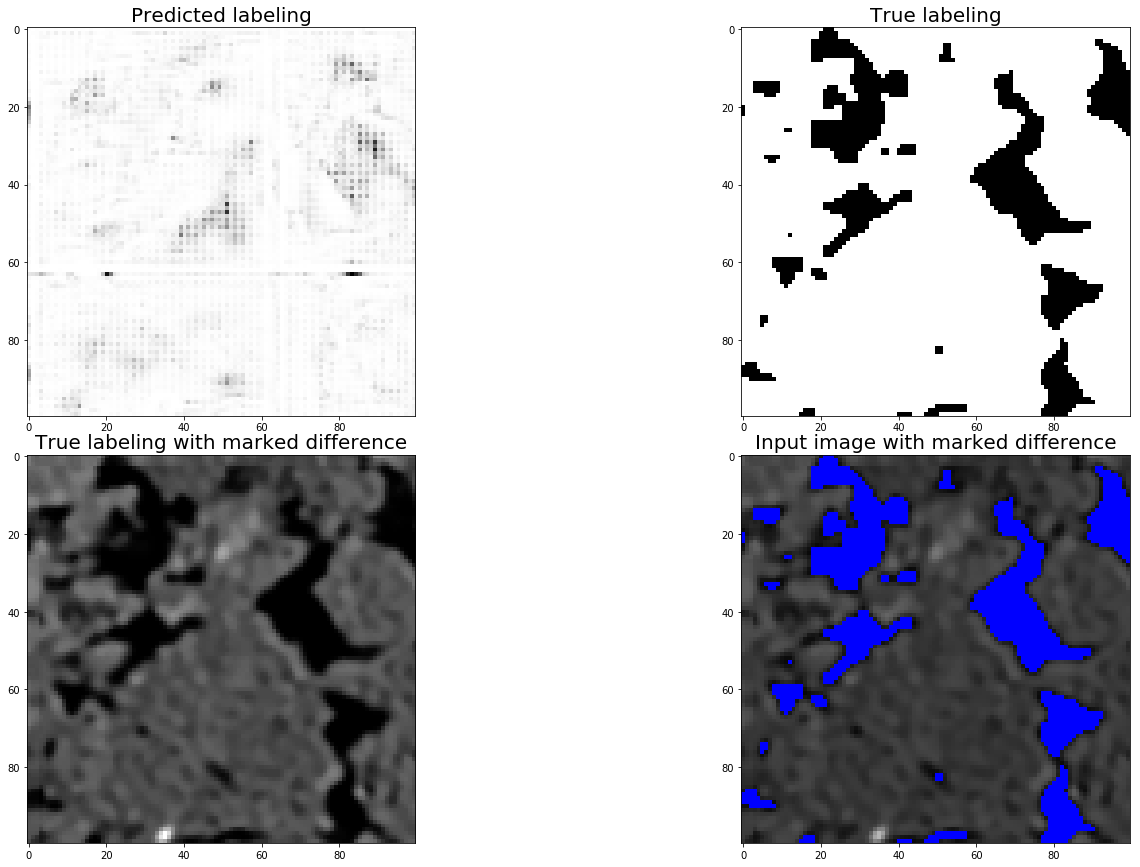

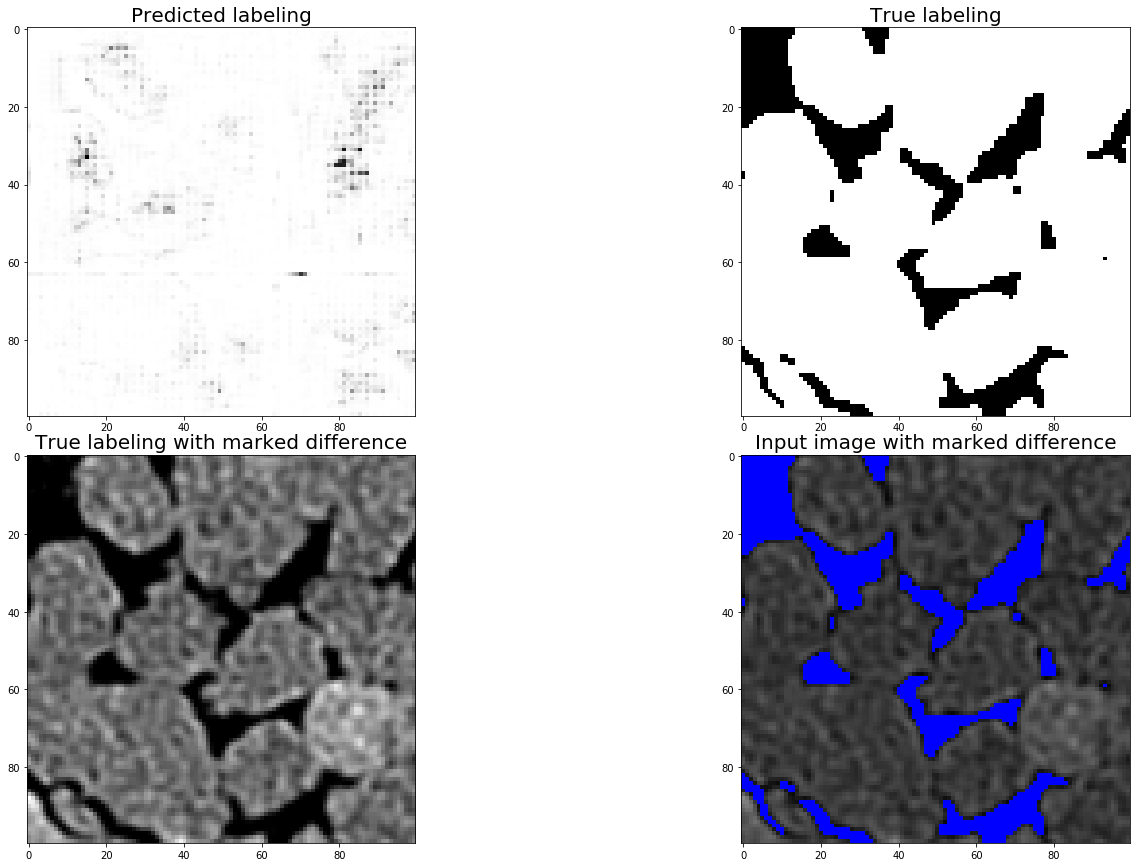

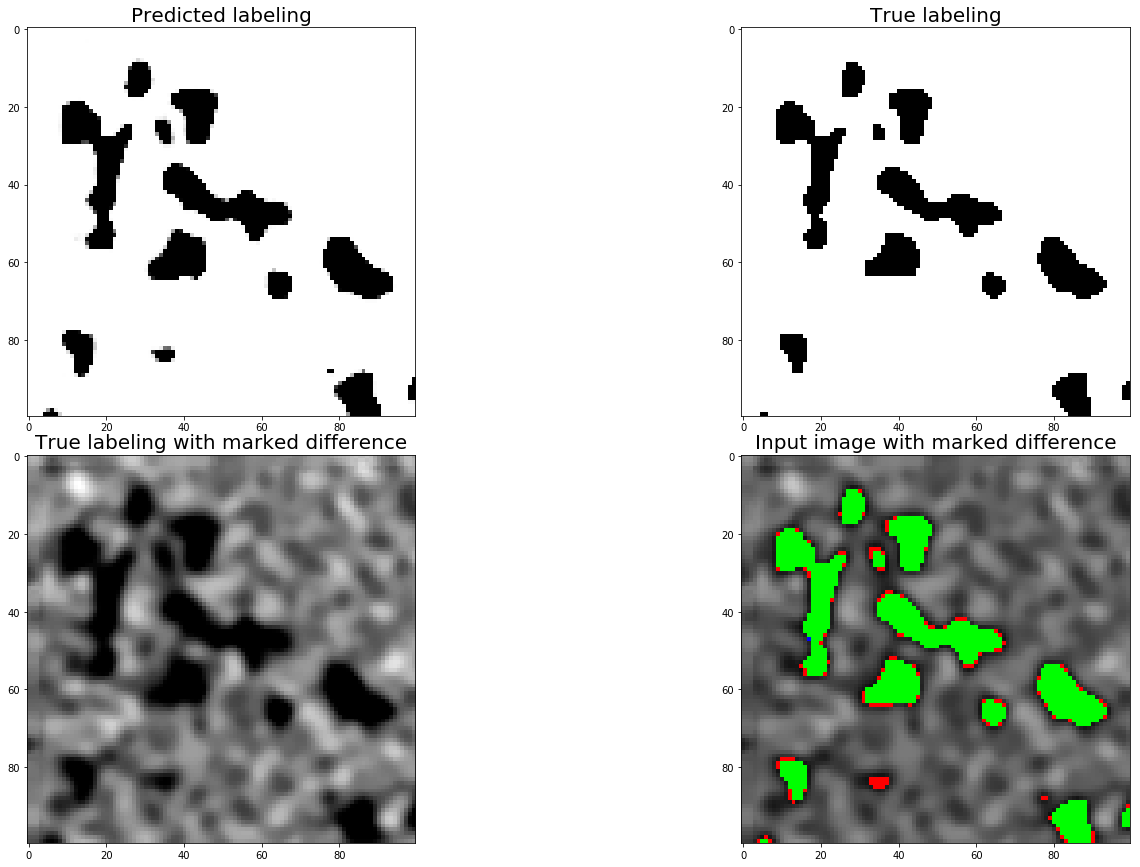

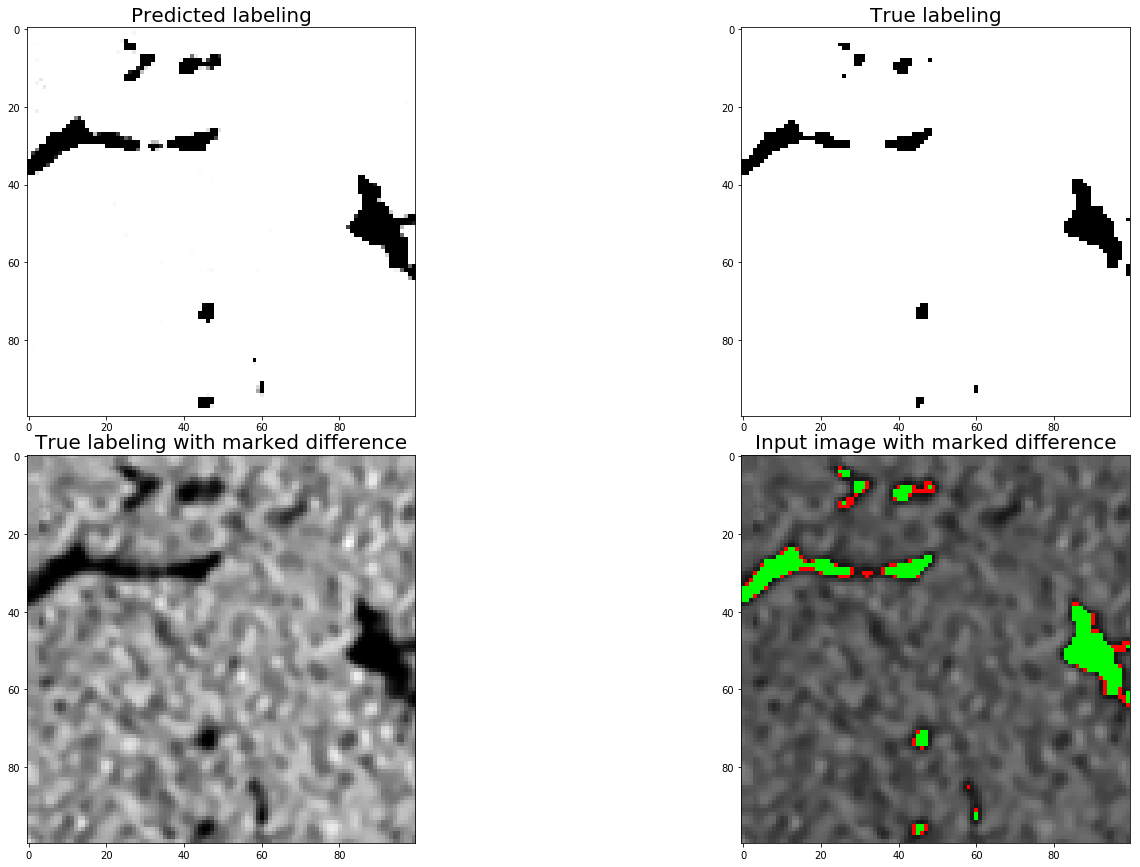

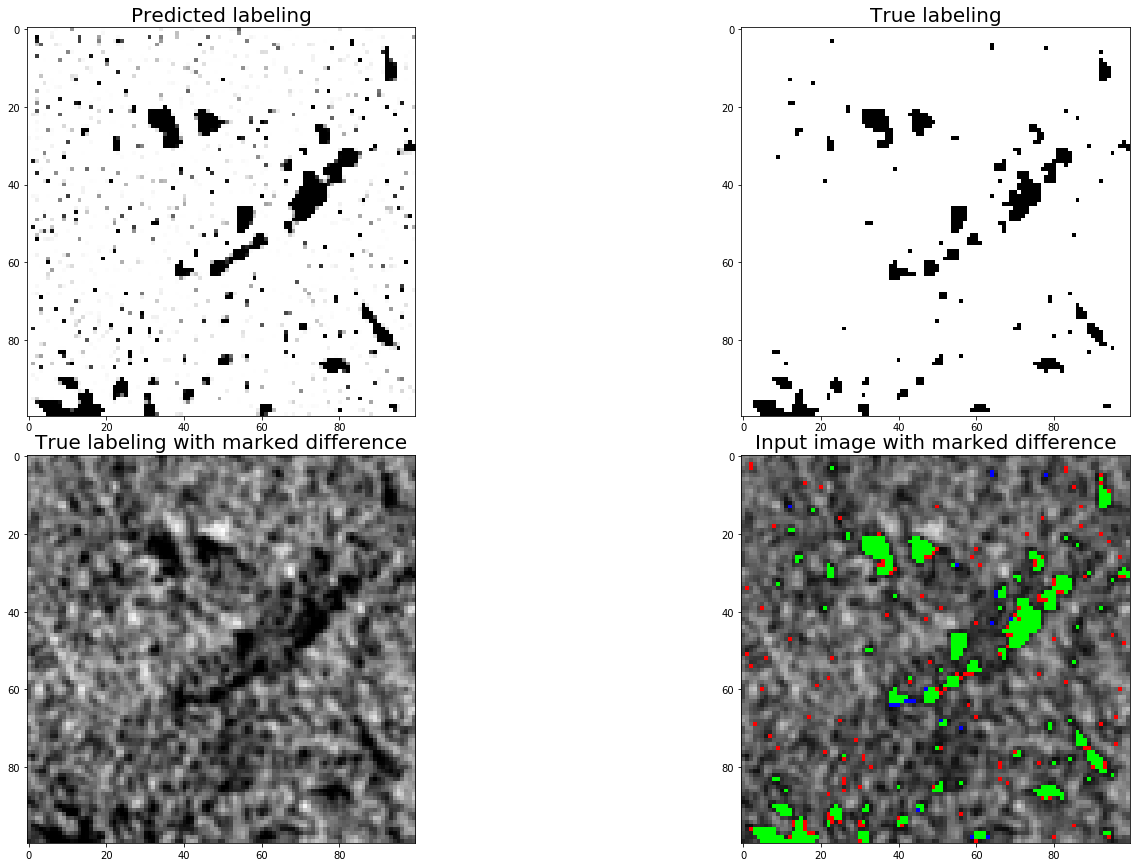

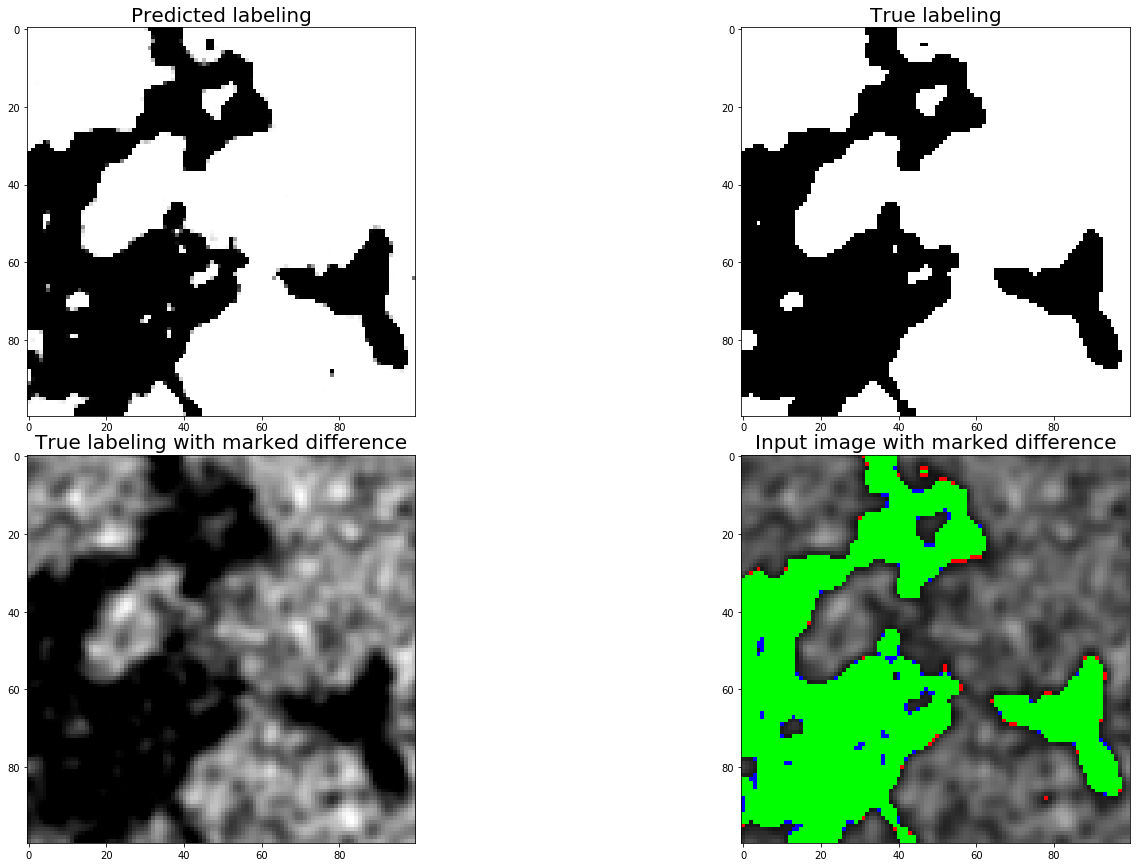

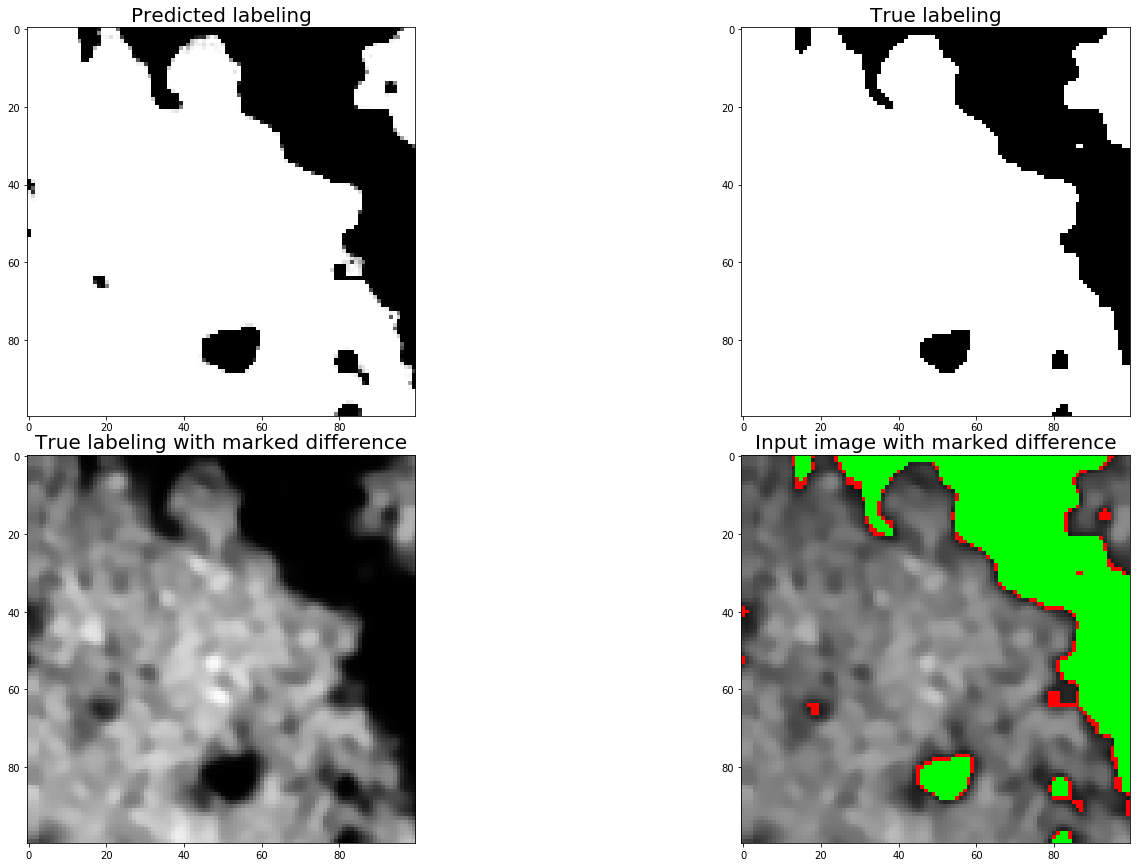

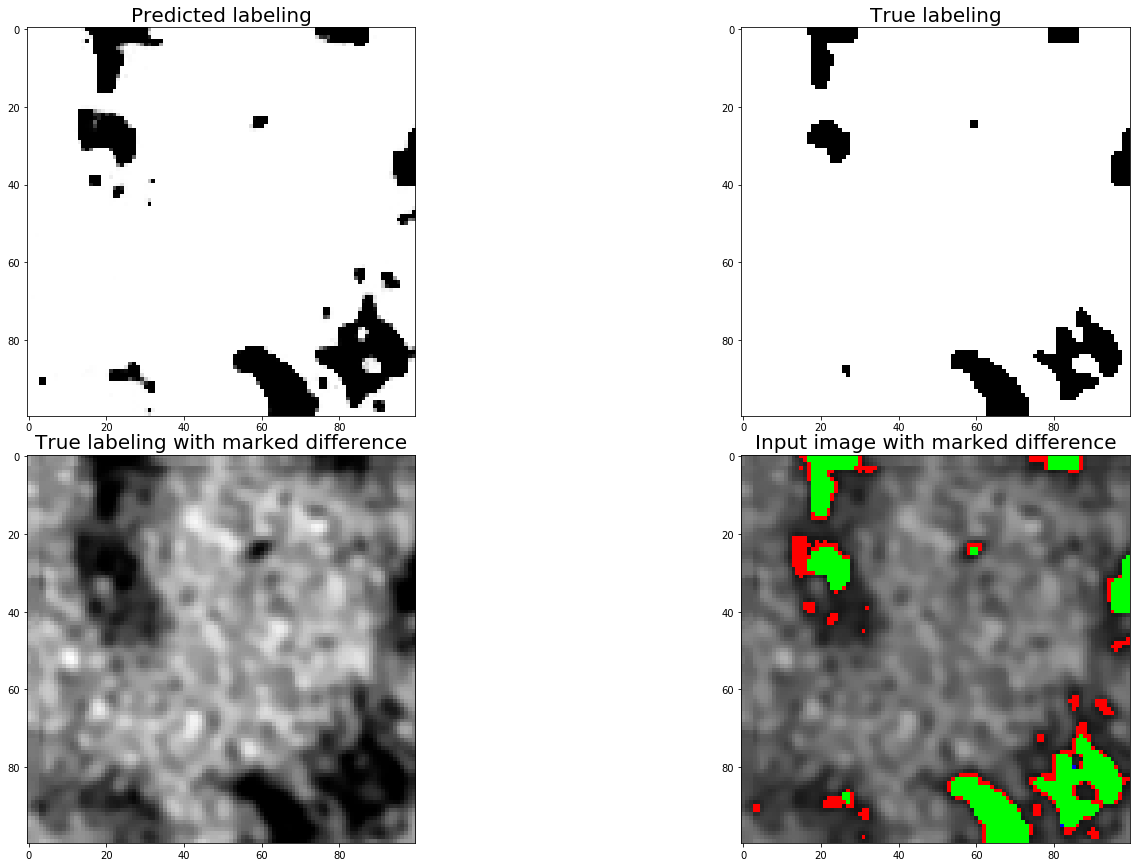

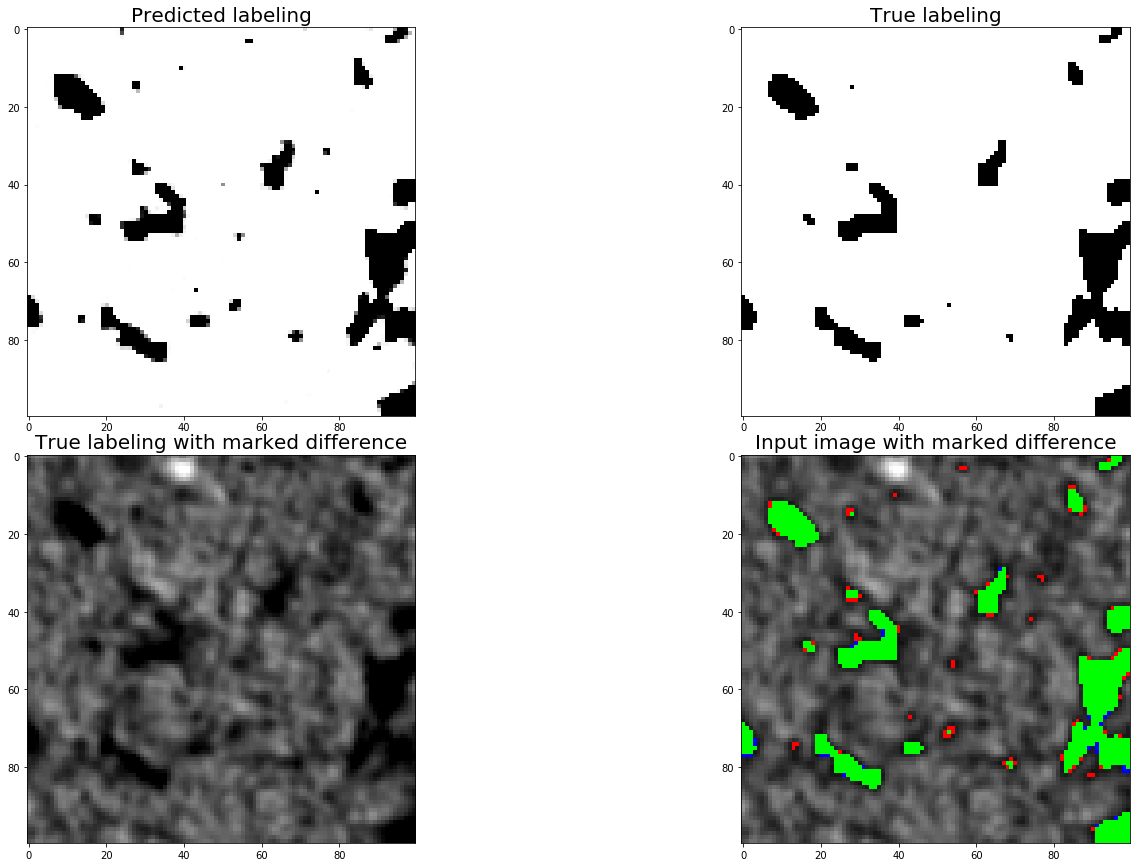

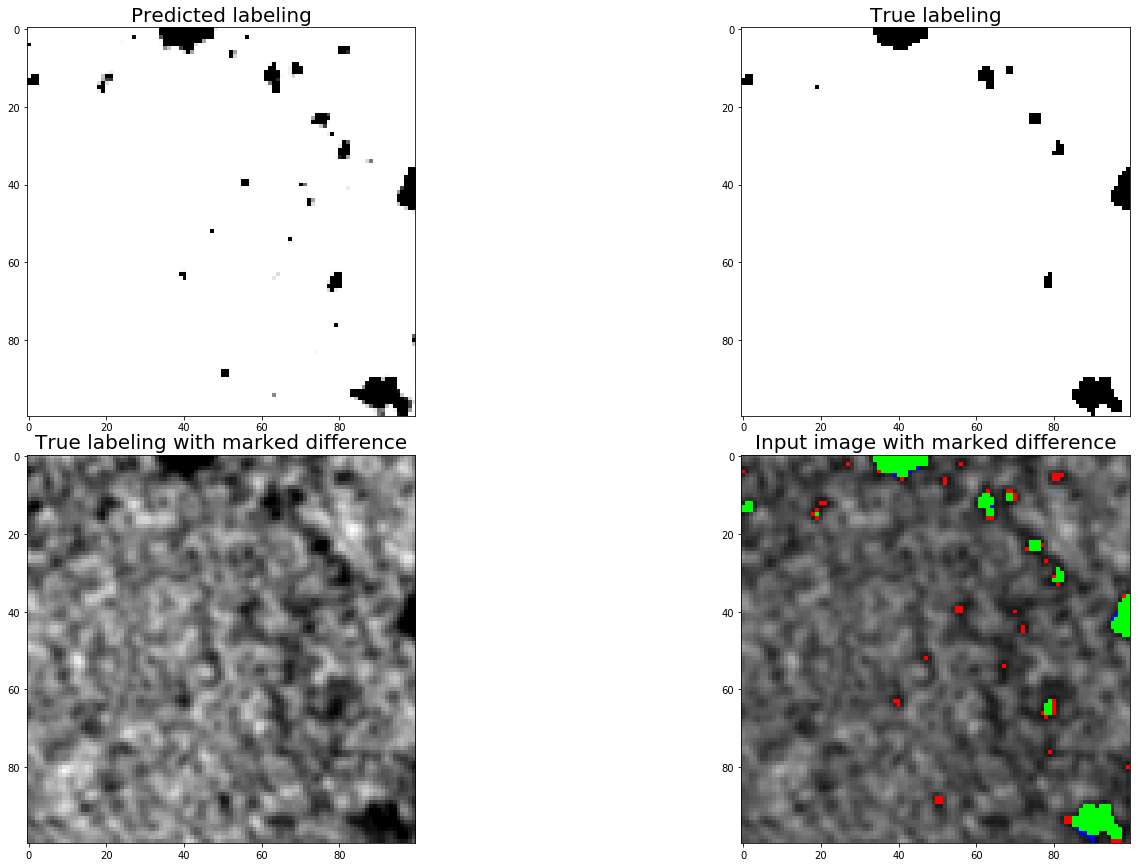

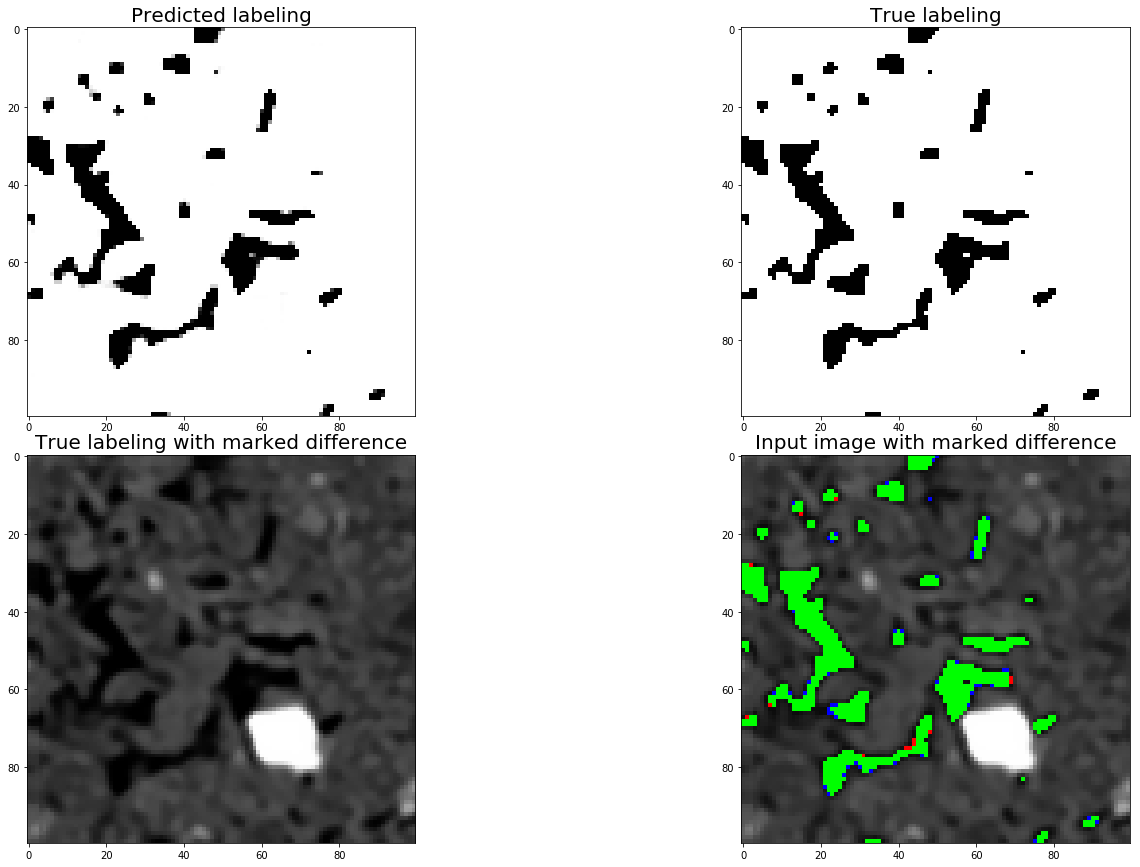

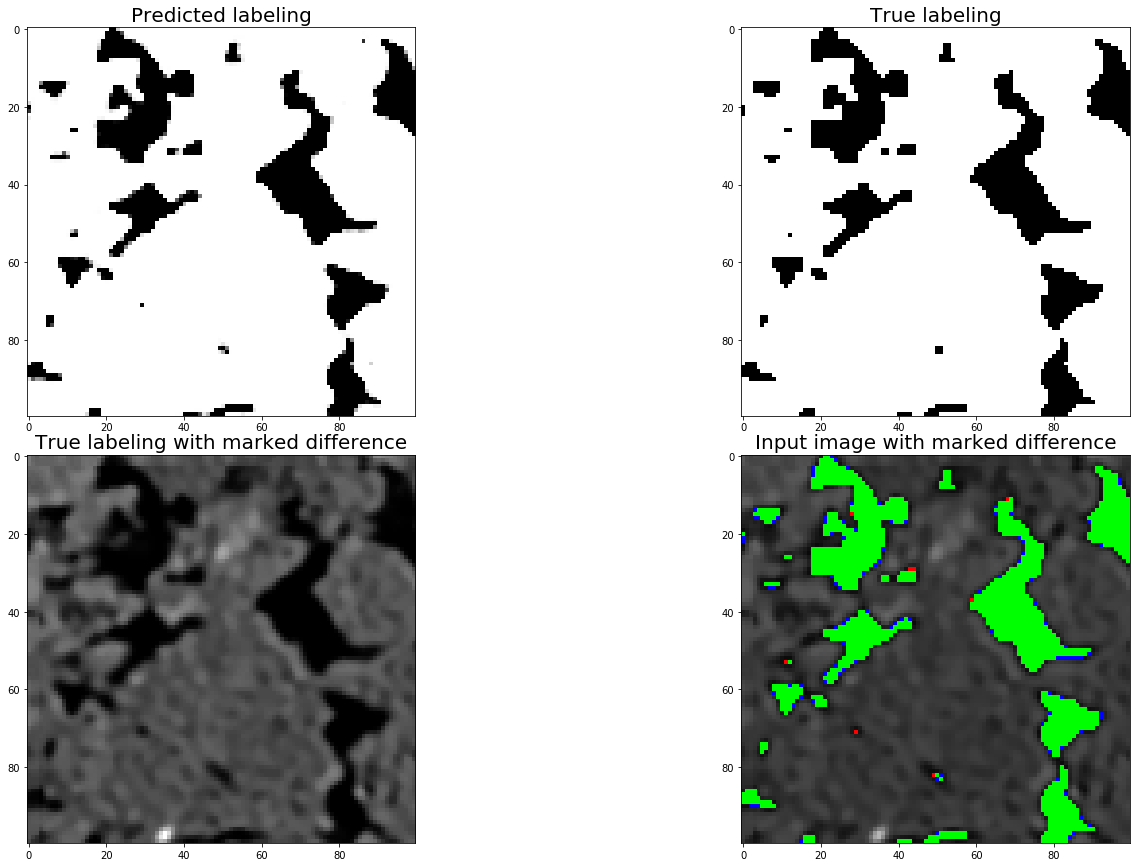

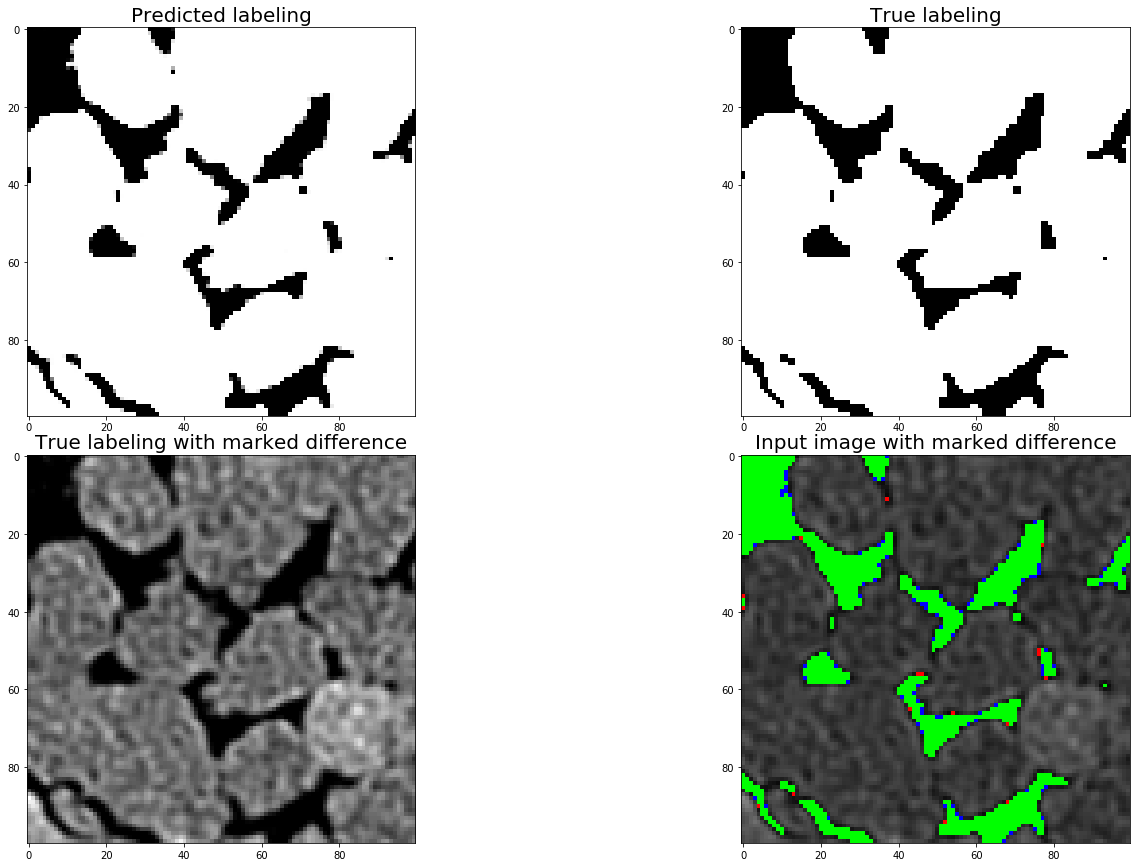

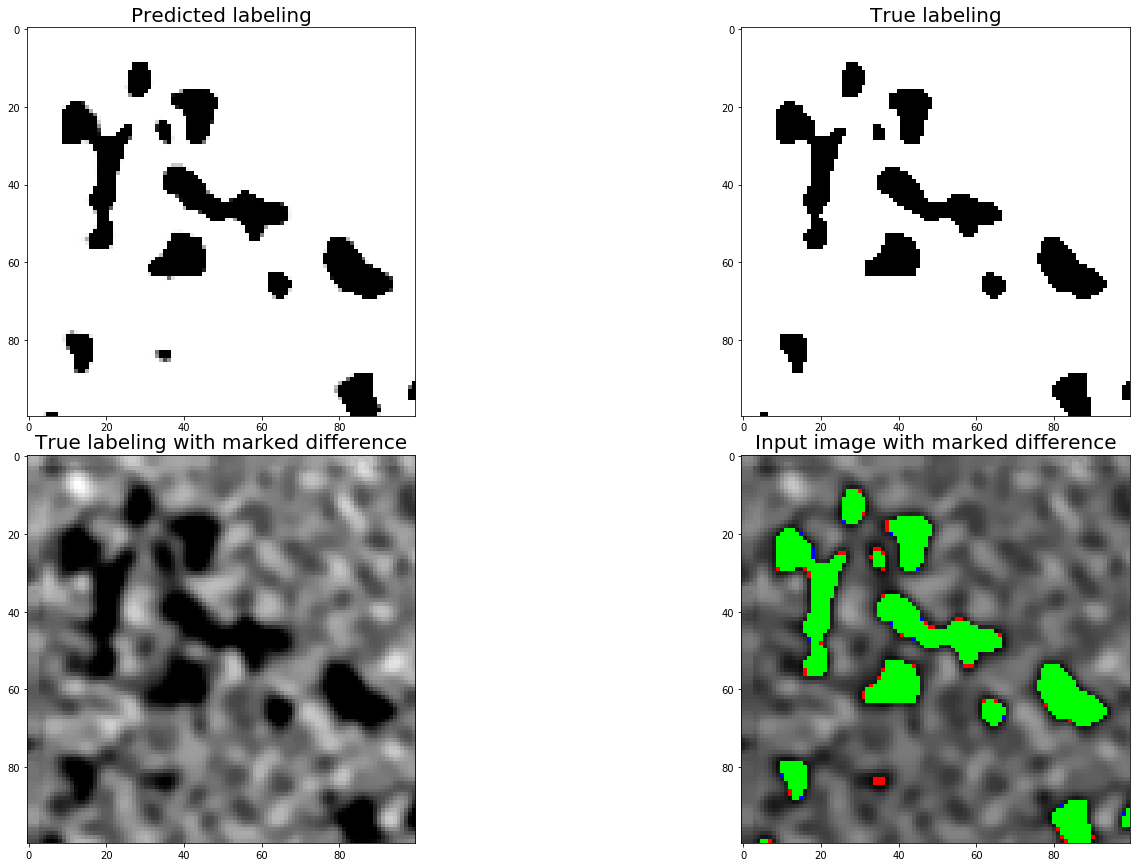

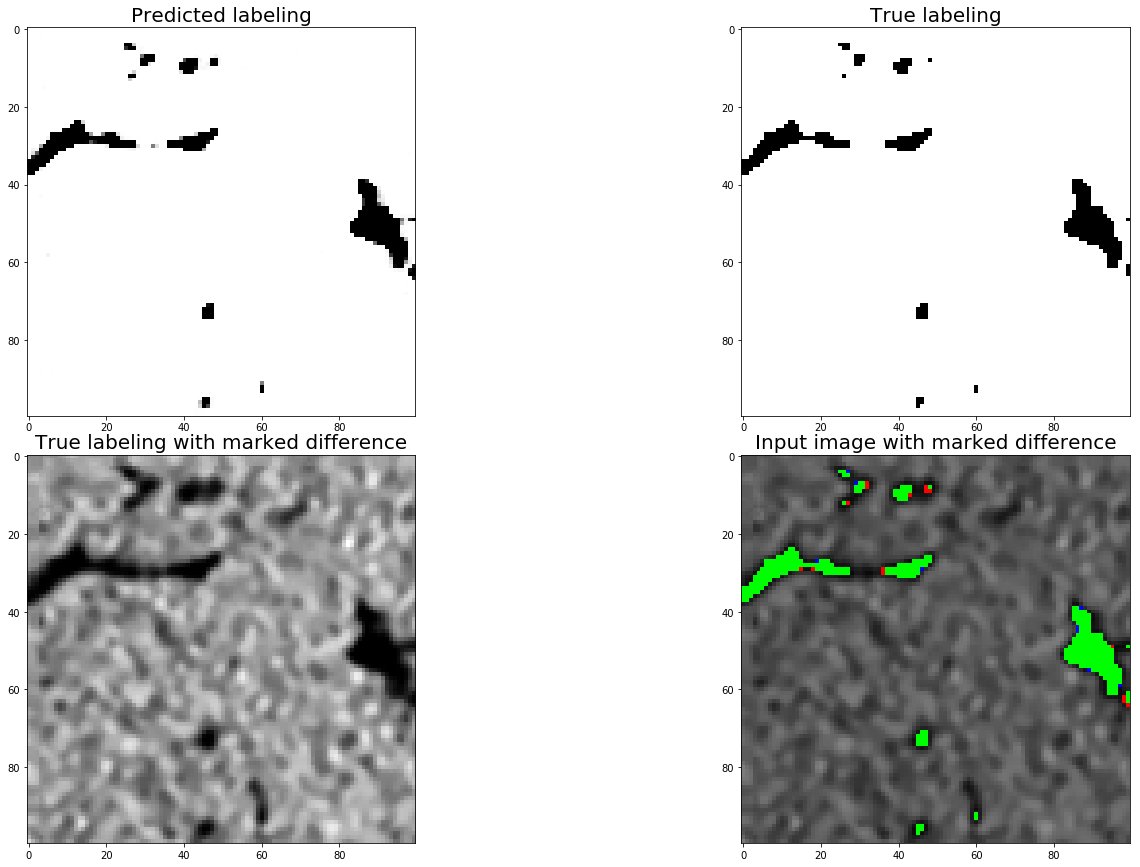

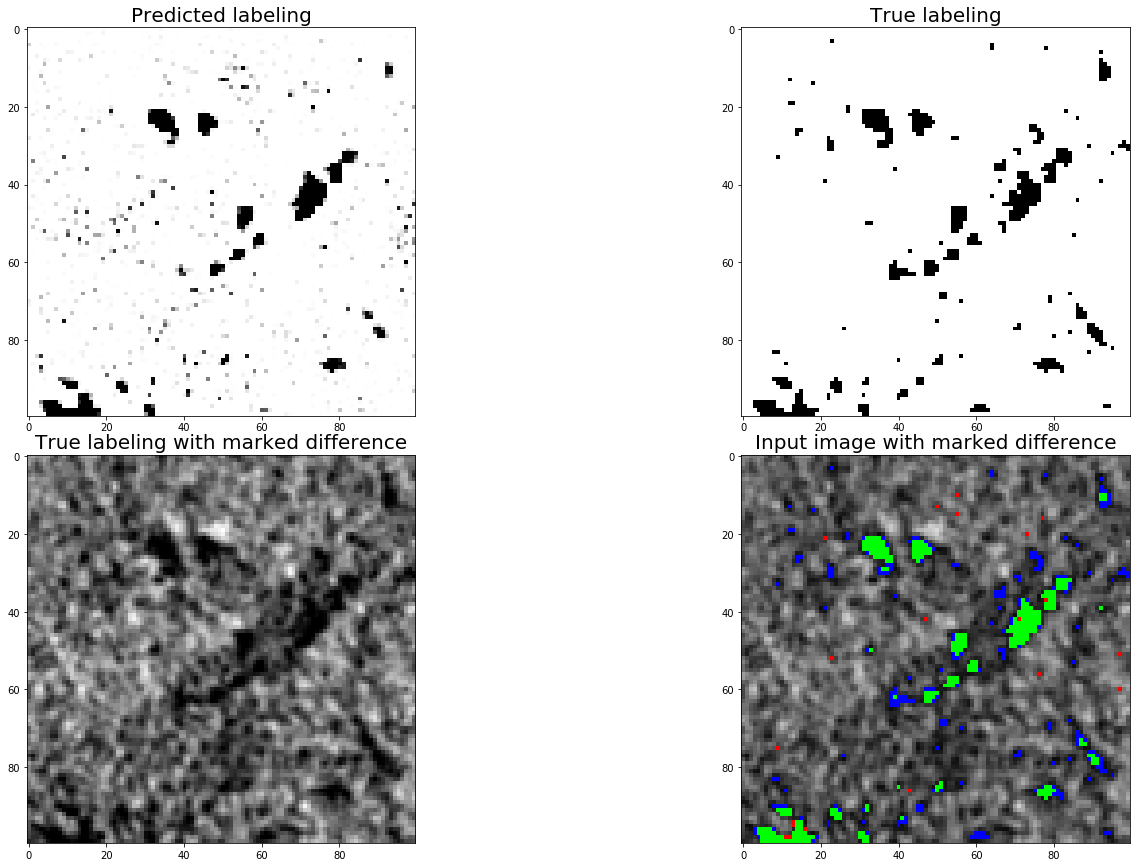

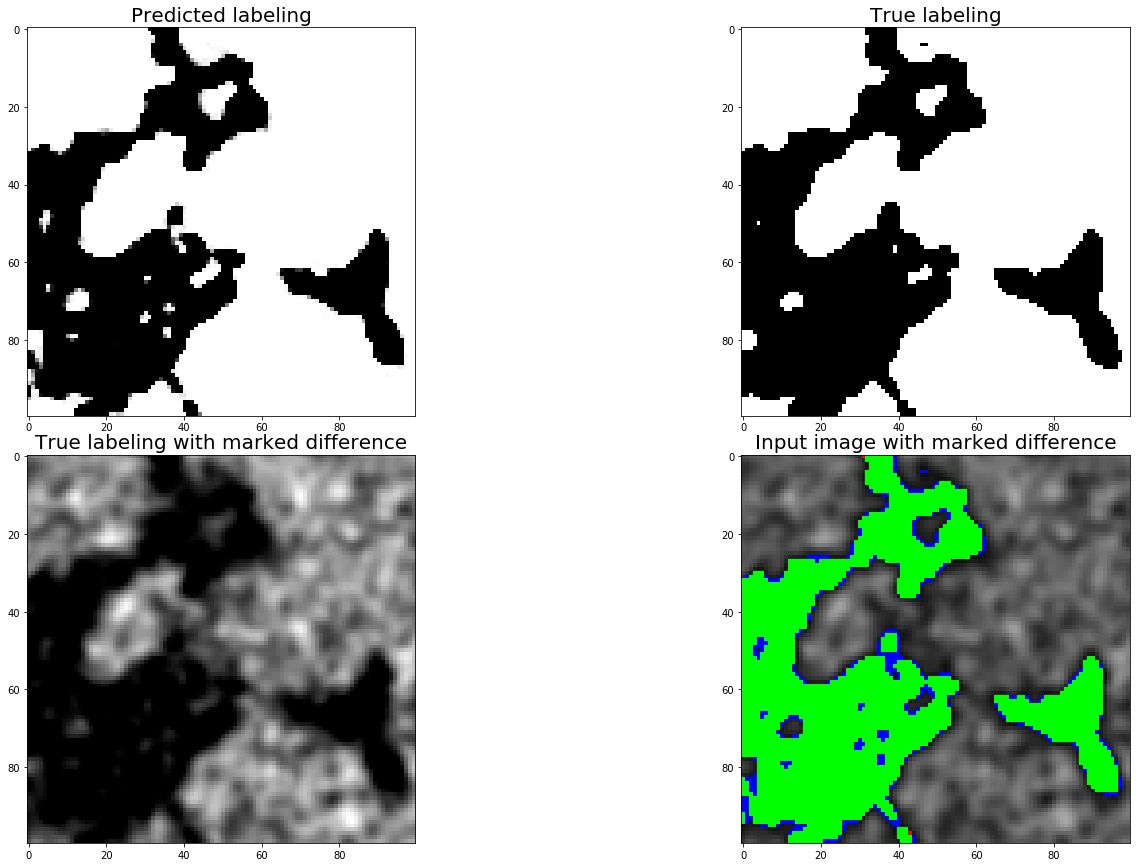

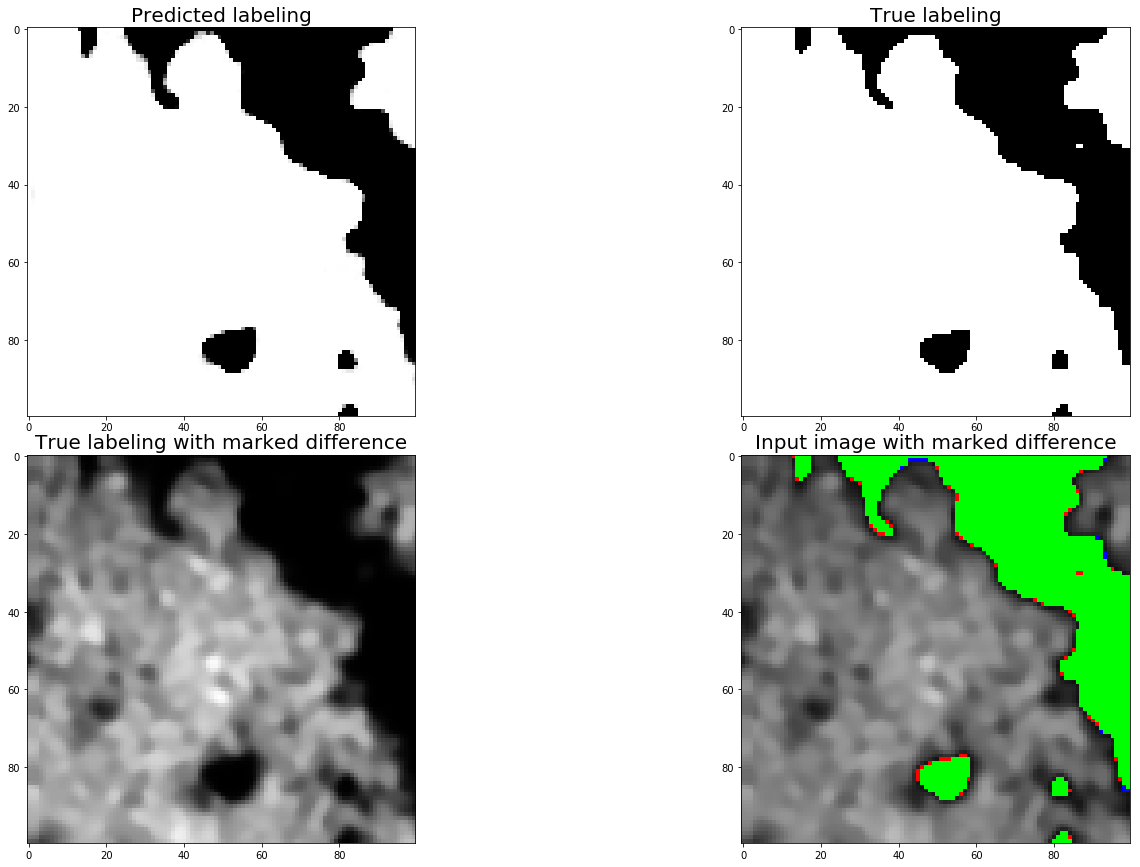

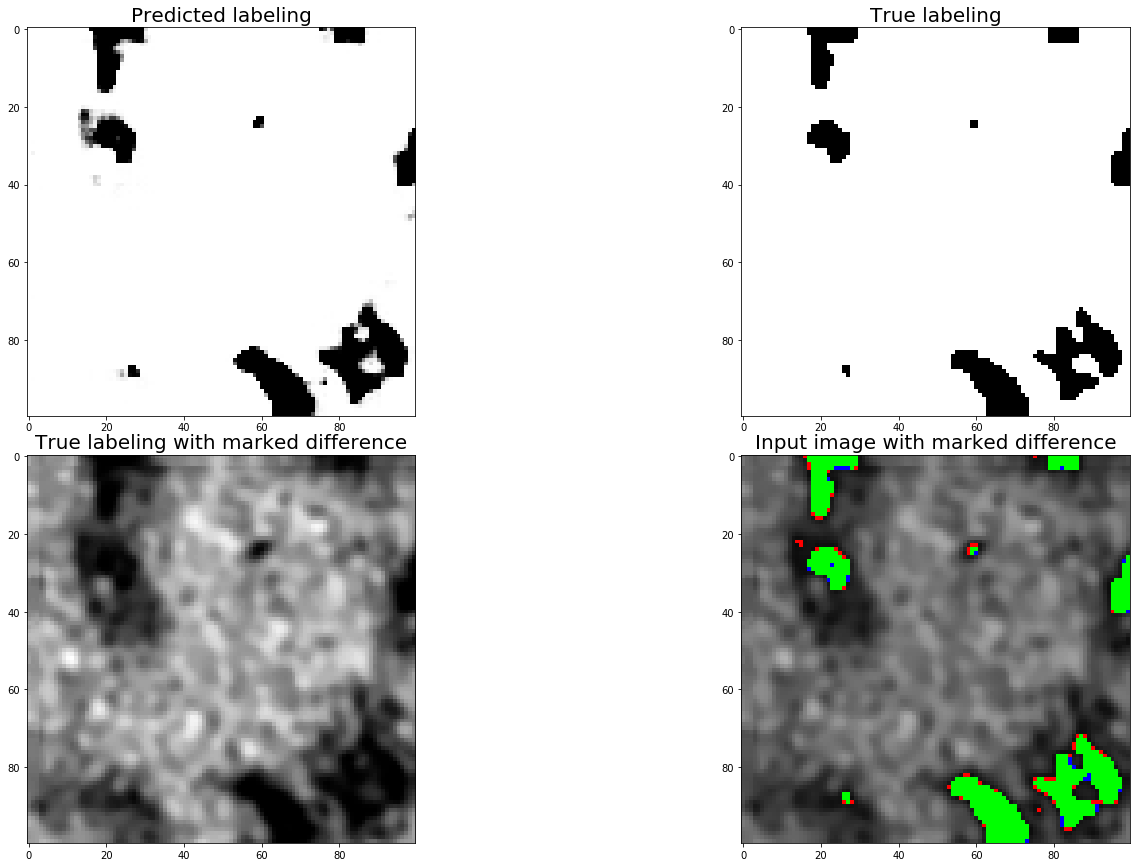

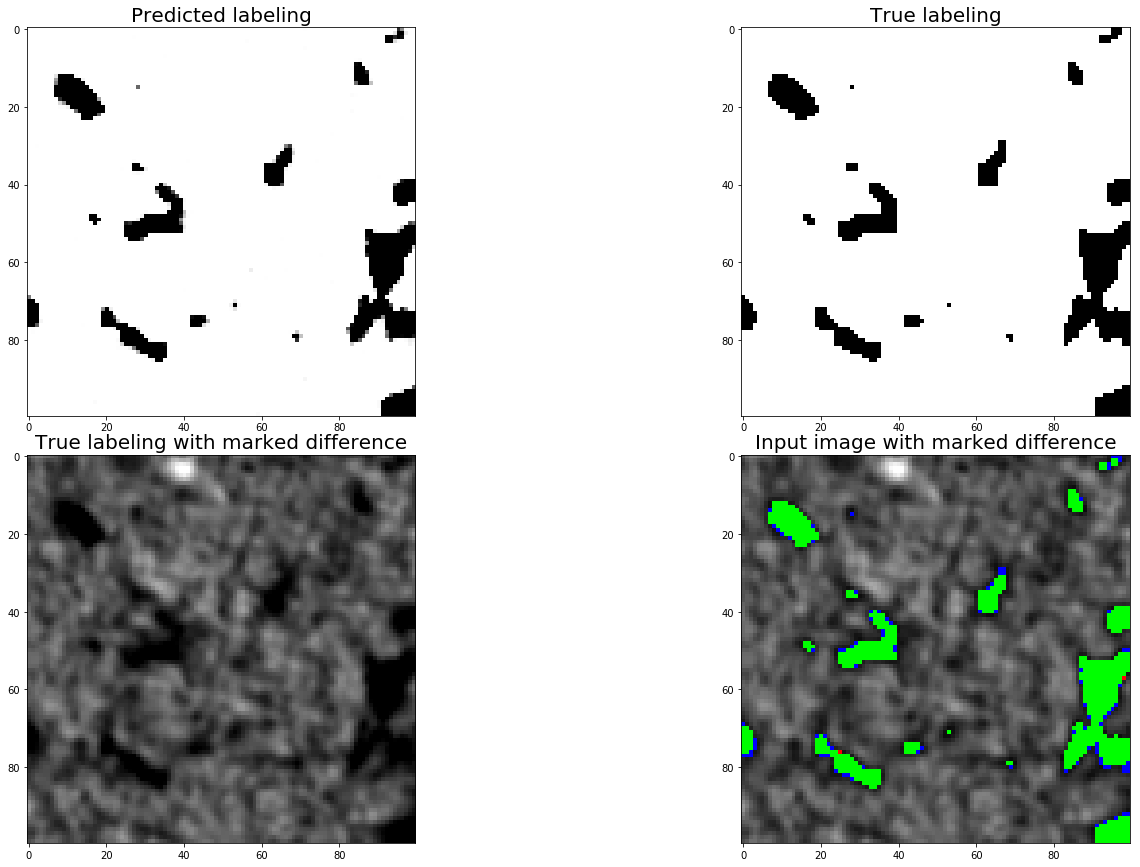

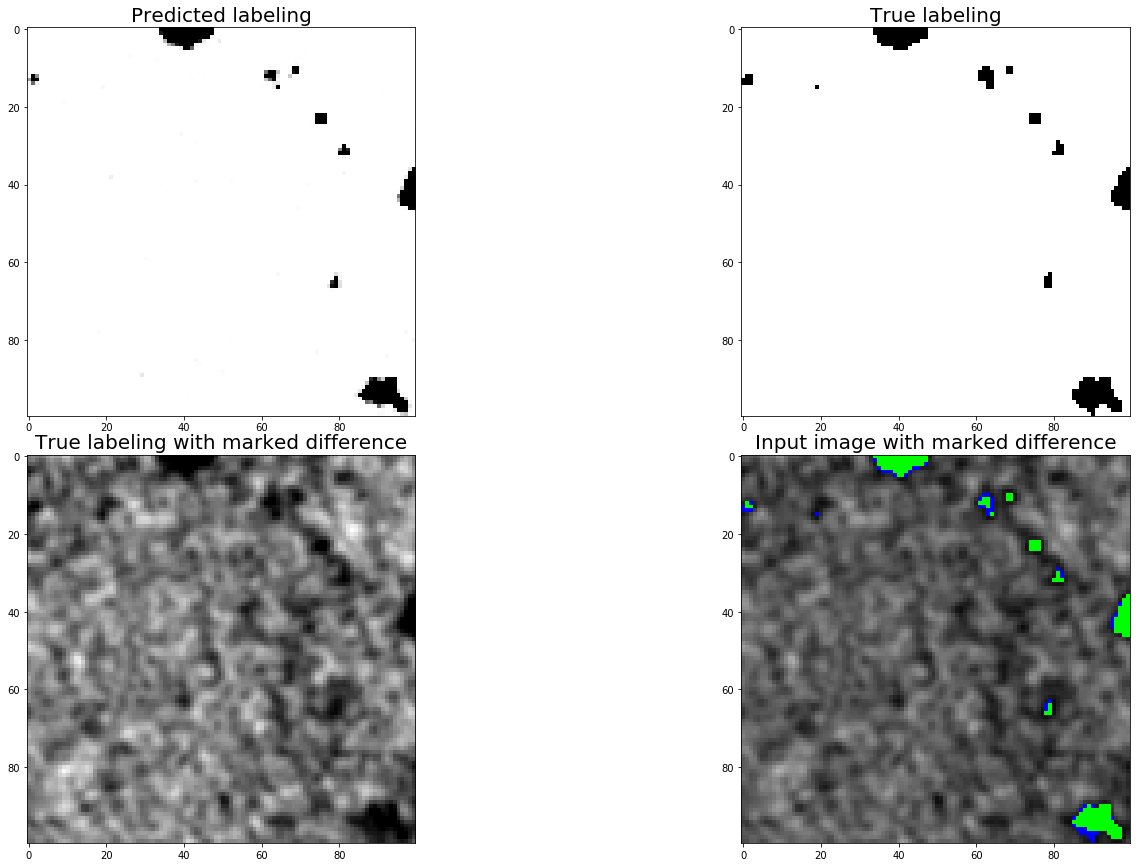

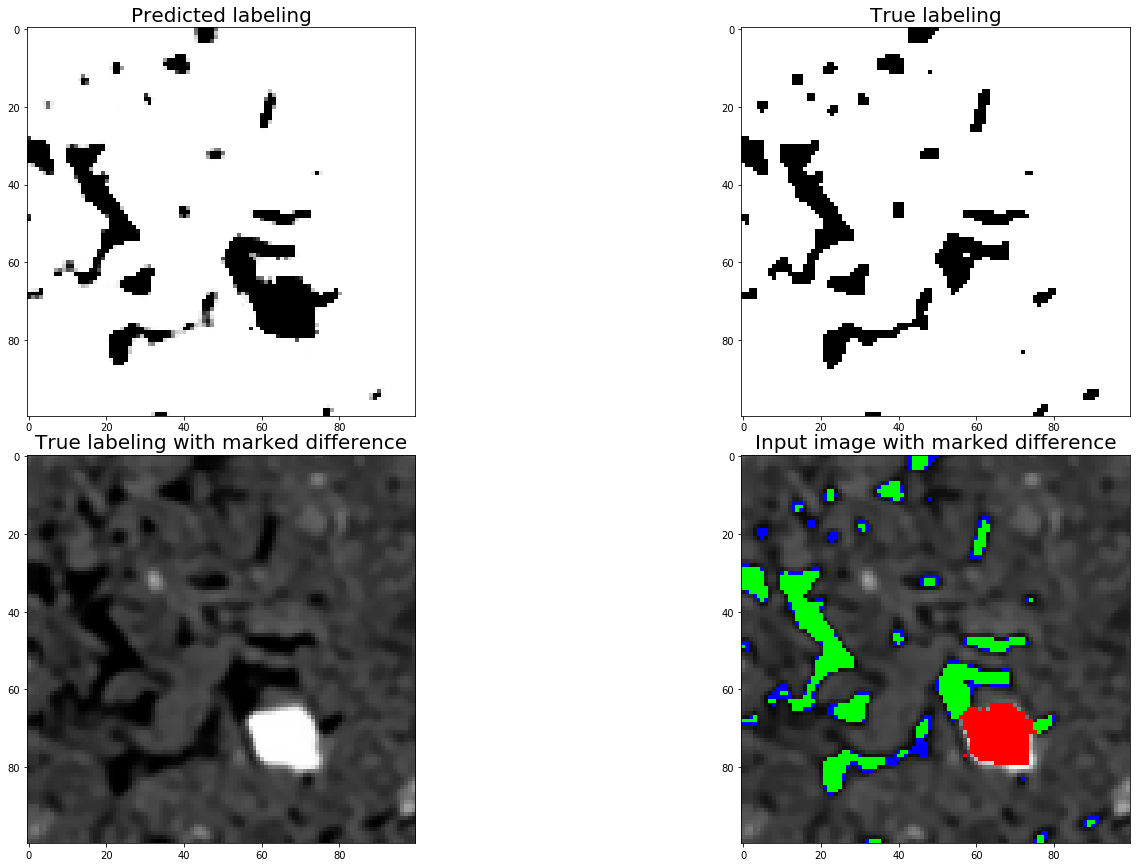

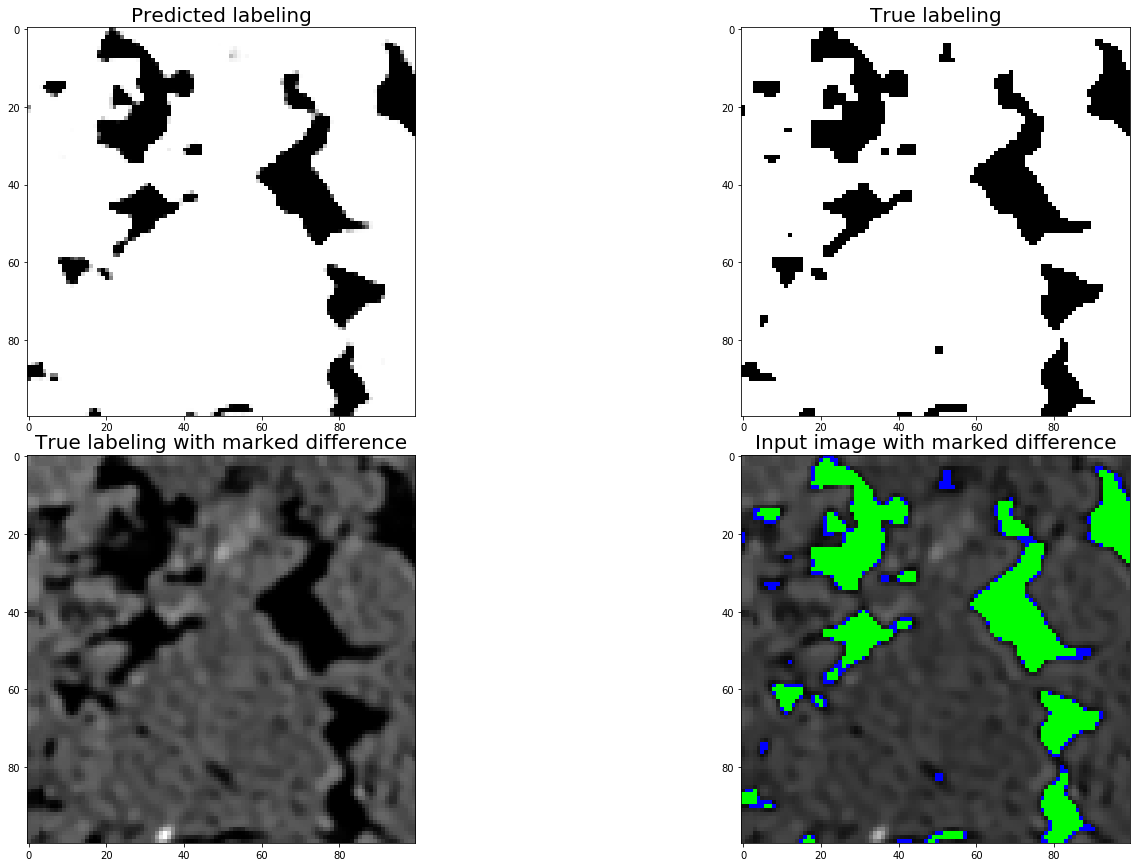

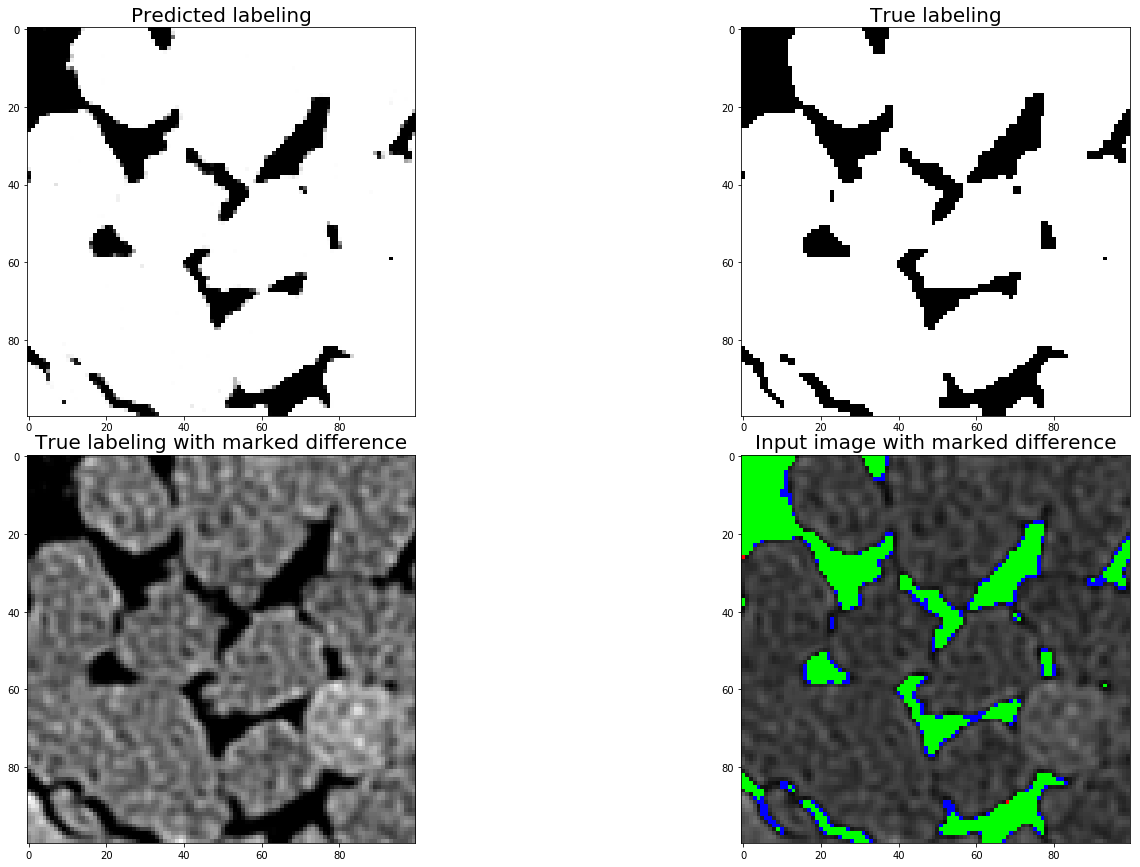

In [90]:
for trained_stack_name in trained_stack_names:
    weights_name = ''.join([trained_stack_name, '_weights/UNet_params_ep009.jbl'])
    weights_path = os.path.join('../output_data/weights', weights_name)
    predictor = create_predictor(weights_path)
    for predicting_stack_name in predicting_stack_names:
        input_stack_path = os.path.join('../binary_data', predicting_stack_name, 'NLM')
        output_stack_path = os.path.join('../binary_data', predicting_stack_name, 'CAC')
        input_img, output_img, prediction = get_predictions(input_stack_path, output_stack_path, predictor, image_number)
        folder_name = trained_stack_name
        try:
            os.mkdir('../output_data/predictions/' + folder_name)
        except:
            pass
        out_path = '../output_data/predictions/' + folder_name + '/' + predicting_stack_name + 'jpg'
        compare(input_img[lx:rx, ly:ry], prediction[lx:rx, ly:ry], output_img[lx:rx, ly:ry], out_path, threshold)